## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


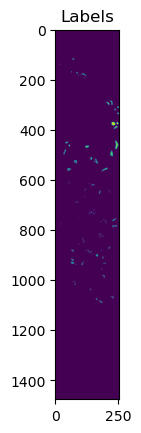

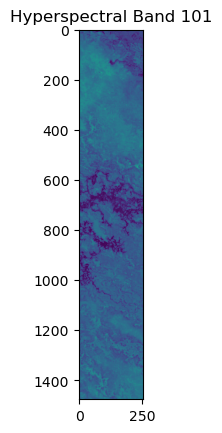

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(280, 5, 5, 145)
(70, 5, 5, 145)
(2898, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2202, PSNR: -10.6885


Epoch [1/50] Training Loss: 0.2111, PSNR: -8.7027
	[Val]   Batch [1/11] Loss: 0.2041, PSNR: -6.1357
	[Val]   Batch [10/11] Loss: 0.2043, PSNR: -8.3748
Epoch [1/50] Validation Loss: 0.2041, PSNR: -8.0668

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1968, PSNR: -7.5620


Epoch [2/50] Training Loss: 0.1887, PSNR: -8.2888
	[Val]   Batch [1/11] Loss: 0.1755, PSNR: -5.4803
	[Val]   Batch [10/11] Loss: 0.1758, PSNR: -7.7243
Epoch [2/50] Validation Loss: 0.1755, PSNR: -7.4117

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1746, PSNR: -7.3915


Epoch [3/50] Training Loss: 0.1674, PSNR: -7.6539
	[Val]   Batch [1/11] Loss: 0.1509, PSNR: -4.8232
	[Val]   Batch [10/11] Loss: 0.1512, PSNR: -7.0673
Epoch [3/50] Validation Loss: 0.1509, PSNR: -6.7550

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1529, PSNR: -7.8946


Epoch [4/50] Training Loss: 0.1469, PSNR: -7.1647
	[Val]   Batch [1/11] Loss: 0.1310, PSNR: -4.2085
	[Val]   Batch [10/11] Loss: 0.1311, PSNR: -6.4478
Epoch [4/50] Validation Loss: 0.1308, PSNR: -6.1347

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1343, PSNR: -6.7394


Epoch [5/50] Training Loss: 0.1277, PSNR: -6.5593
	[Val]   Batch [1/11] Loss: 0.1127, PSNR: -3.5544
	[Val]   Batch [10/11] Loss: 0.1128, PSNR: -5.7962
Epoch [5/50] Validation Loss: 0.1125, PSNR: -5.4811

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1162, PSNR: -6.6282


Epoch [6/50] Training Loss: 0.1103, PSNR: -5.9044
	[Val]   Batch [1/11] Loss: 0.0974, PSNR: -2.9233
	[Val]   Batch [10/11] Loss: 0.0976, PSNR: -5.1679
Epoch [6/50] Validation Loss: 0.0974, PSNR: -4.8532

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.0999, PSNR: -5.8858


Epoch [7/50] Training Loss: 0.0948, PSNR: -5.2843
	[Val]   Batch [1/11] Loss: 0.0837, PSNR: -2.2634
	[Val]   Batch [10/11] Loss: 0.0839, PSNR: -4.5100
Epoch [7/50] Validation Loss: 0.0837, PSNR: -4.1956

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0869, PSNR: -4.0673


Epoch [8/50] Training Loss: 0.0815, PSNR: -4.4908
	[Val]   Batch [1/11] Loss: 0.0733, PSNR: -1.6892
	[Val]   Batch [10/11] Loss: 0.0734, PSNR: -3.9318
Epoch [8/50] Validation Loss: 0.0733, PSNR: -3.6208

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0743, PSNR: -6.2001


Epoch [9/50] Training Loss: 0.0703, PSNR: -4.0762
	[Val]   Batch [1/11] Loss: 0.0628, PSNR: -1.0196
	[Val]   Batch [10/11] Loss: 0.0629, PSNR: -3.2596
Epoch [9/50] Validation Loss: 0.0628, PSNR: -2.9501

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0642, PSNR: -3.9665


Epoch [10/50] Training Loss: 0.0609, PSNR: -3.4809
	[Val]   Batch [1/11] Loss: 0.0563, PSNR: -0.5389
	[Val]   Batch [10/11] Loss: 0.0563, PSNR: -2.7781
Epoch [10/50] Validation Loss: 0.0562, PSNR: -2.4682

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0552, PSNR: -3.8769


Epoch [11/50] Training Loss: 0.0531, PSNR: -2.8788
	[Val]   Batch [1/11] Loss: 0.0494, PSNR: 0.0275
	[Val]   Batch [10/11] Loss: 0.0494, PSNR: -2.2126
Epoch [11/50] Validation Loss: 0.0494, PSNR: -1.9013

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0480, PSNR: -3.2693


Epoch [12/50] Training Loss: 0.0466, PSNR: -2.1989
	[Val]   Batch [1/11] Loss: 0.0438, PSNR: 0.5492
	[Val]   Batch [10/11] Loss: 0.0438, PSNR: -1.6899
Epoch [12/50] Validation Loss: 0.0438, PSNR: -1.3793

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0422, PSNR: -0.8736


Epoch [13/50] Training Loss: 0.0412, PSNR: -1.6178
	[Val]   Batch [1/11] Loss: 0.0395, PSNR: 0.9986
	[Val]   Batch [10/11] Loss: 0.0395, PSNR: -1.2406
Epoch [13/50] Validation Loss: 0.0395, PSNR: -0.9301

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0378, PSNR: -1.6644


Epoch [14/50] Training Loss: 0.0367, PSNR: -1.0823
	[Val]   Batch [1/11] Loss: 0.0353, PSNR: 1.4824
	[Val]   Batch [10/11] Loss: 0.0354, PSNR: -0.7571
Epoch [14/50] Validation Loss: 0.0353, PSNR: -0.4462

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0339, PSNR: 1.6546


Epoch [15/50] Training Loss: 0.0329, PSNR: -0.6242
	[Val]   Batch [1/11] Loss: 0.0320, PSNR: 1.9069
	[Val]   Batch [10/11] Loss: 0.0321, PSNR: -0.3342
Epoch [15/50] Validation Loss: 0.0320, PSNR: -0.0225

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0302, PSNR: 2.1681


Epoch [16/50] Training Loss: 0.0297, PSNR: -0.2421
	[Val]   Batch [1/11] Loss: 0.0289, PSNR: 2.3564
	[Val]   Batch [10/11] Loss: 0.0289, PSNR: 0.1149
Epoch [16/50] Validation Loss: 0.0289, PSNR: 0.4261

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0279, PSNR: -0.4154


Epoch [17/50] Training Loss: 0.0269, PSNR: 0.1696
	[Val]   Batch [1/11] Loss: 0.0263, PSNR: 2.7689
	[Val]   Batch [10/11] Loss: 0.0263, PSNR: 0.5275
Epoch [17/50] Validation Loss: 0.0263, PSNR: 0.8390

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0258, PSNR: -1.4158


Epoch [18/50] Training Loss: 0.0245, PSNR: 0.4970
	[Val]   Batch [1/11] Loss: 0.0240, PSNR: 3.1554
	[Val]   Batch [10/11] Loss: 0.0241, PSNR: 0.9135
Epoch [18/50] Validation Loss: 0.0240, PSNR: 1.2251

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0223, PSNR: 1.8987


Epoch [19/50] Training Loss: 0.0224, PSNR: 0.9873
	[Val]   Batch [1/11] Loss: 0.0221, PSNR: 3.5177
	[Val]   Batch [10/11] Loss: 0.0221, PSNR: 1.2755
Epoch [19/50] Validation Loss: 0.0221, PSNR: 1.5877

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0210, PSNR: -0.9623


Epoch [20/50] Training Loss: 0.0206, PSNR: 1.2887
	[Val]   Batch [1/11] Loss: 0.0202, PSNR: 3.9105
	[Val]   Batch [10/11] Loss: 0.0202, PSNR: 1.6688
Epoch [20/50] Validation Loss: 0.0202, PSNR: 1.9809

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0197, PSNR: 4.0212


Epoch [21/50] Training Loss: 0.0190, PSNR: 1.9082
	[Val]   Batch [1/11] Loss: 0.0188, PSNR: 4.2141
	[Val]   Batch [10/11] Loss: 0.0189, PSNR: 1.9724
Epoch [21/50] Validation Loss: 0.0188, PSNR: 2.2847

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0179, PSNR: 3.1256


Epoch [22/50] Training Loss: 0.0175, PSNR: 1.9589
	[Val]   Batch [1/11] Loss: 0.0174, PSNR: 4.5655
	[Val]   Batch [10/11] Loss: 0.0174, PSNR: 2.3241
Epoch [22/50] Validation Loss: 0.0174, PSNR: 2.6349

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0165, PSNR: 0.5307


Epoch [23/50] Training Loss: 0.0163, PSNR: 2.3333
	[Val]   Batch [1/11] Loss: 0.0161, PSNR: 4.8930
	[Val]   Batch [10/11] Loss: 0.0161, PSNR: 2.6516
Epoch [23/50] Validation Loss: 0.0161, PSNR: 2.9623

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0158, PSNR: 3.0344


Epoch [24/50] Training Loss: 0.0151, PSNR: 2.6532
	[Val]   Batch [1/11] Loss: 0.0152, PSNR: 5.1493
	[Val]   Batch [10/11] Loss: 0.0152, PSNR: 2.9076
Epoch [24/50] Validation Loss: 0.0152, PSNR: 3.2186

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0143, PSNR: 1.1910


Epoch [25/50] Training Loss: 0.0141, PSNR: 3.0010
	[Val]   Batch [1/11] Loss: 0.0142, PSNR: 5.4469
	[Val]   Batch [10/11] Loss: 0.0142, PSNR: 3.2043
Epoch [25/50] Validation Loss: 0.0142, PSNR: 3.5158

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0135, PSNR: 4.0713


Epoch [26/50] Training Loss: 0.0132, PSNR: 3.3914
	[Val]   Batch [1/11] Loss: 0.0131, PSNR: 5.7749
	[Val]   Batch [10/11] Loss: 0.0132, PSNR: 3.5326
Epoch [26/50] Validation Loss: 0.0131, PSNR: 3.8441

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0121, PSNR: 3.8829


Epoch [27/50] Training Loss: 0.0124, PSNR: 3.5456
	[Val]   Batch [1/11] Loss: 0.0124, PSNR: 6.0236
	[Val]   Batch [10/11] Loss: 0.0124, PSNR: 3.7820
Epoch [27/50] Validation Loss: 0.0124, PSNR: 4.0932

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0123, PSNR: 6.0780


Epoch [28/50] Training Loss: 0.0116, PSNR: 3.7881
	[Val]   Batch [1/11] Loss: 0.0117, PSNR: 6.2811
	[Val]   Batch [10/11] Loss: 0.0117, PSNR: 4.0385
Epoch [28/50] Validation Loss: 0.0117, PSNR: 4.3506

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 3.1796


Epoch [29/50] Training Loss: 0.0109, PSNR: 4.0161
	[Val]   Batch [1/11] Loss: 0.0110, PSNR: 6.5505
	[Val]   Batch [10/11] Loss: 0.0110, PSNR: 4.3082
Epoch [29/50] Validation Loss: 0.0110, PSNR: 4.6199

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0102, PSNR: 3.4425


Epoch [30/50] Training Loss: 0.0103, PSNR: 4.3553
	[Val]   Batch [1/11] Loss: 0.0103, PSNR: 6.8372
	[Val]   Batch [10/11] Loss: 0.0103, PSNR: 4.5948
Epoch [30/50] Validation Loss: 0.0103, PSNR: 4.9070

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 4.0415


Epoch [31/50] Training Loss: 0.0097, PSNR: 4.7839
	[Val]   Batch [1/11] Loss: 0.0098, PSNR: 7.0630
	[Val]   Batch [10/11] Loss: 0.0098, PSNR: 4.8216
Epoch [31/50] Validation Loss: 0.0098, PSNR: 5.1340

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0095, PSNR: 5.8596


Epoch [32/50] Training Loss: 0.0091, PSNR: 4.9722
	[Val]   Batch [1/11] Loss: 0.0093, PSNR: 7.2746
	[Val]   Batch [10/11] Loss: 0.0093, PSNR: 5.0330
Epoch [32/50] Validation Loss: 0.0093, PSNR: 5.3452

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0088, PSNR: 3.5794


Epoch [33/50] Training Loss: 0.0086, PSNR: 5.1412
	[Val]   Batch [1/11] Loss: 0.0088, PSNR: 7.5092
	[Val]   Batch [10/11] Loss: 0.0088, PSNR: 5.2667
Epoch [33/50] Validation Loss: 0.0088, PSNR: 5.5794

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0083, PSNR: 7.7495


Epoch [34/50] Training Loss: 0.0082, PSNR: 5.3837
	[Val]   Batch [1/11] Loss: 0.0083, PSNR: 7.7619
	[Val]   Batch [10/11] Loss: 0.0083, PSNR: 5.5187
Epoch [34/50] Validation Loss: 0.0083, PSNR: 5.8332

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 3.1827


Epoch [35/50] Training Loss: 0.0078, PSNR: 5.4163
	[Val]   Batch [1/11] Loss: 0.0079, PSNR: 7.9748
	[Val]   Batch [10/11] Loss: 0.0079, PSNR: 5.7323
Epoch [35/50] Validation Loss: 0.0079, PSNR: 6.0467

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0076, PSNR: 8.1668


Epoch [36/50] Training Loss: 0.0074, PSNR: 5.7166
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.2100
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9669
Epoch [36/50] Validation Loss: 0.0075, PSNR: 6.2815

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 6.4457


Epoch [37/50] Training Loss: 0.0071, PSNR: 6.0789
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.4178
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1751
Epoch [37/50] Validation Loss: 0.0071, PSNR: 6.4894

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 6.6918


Epoch [38/50] Training Loss: 0.0067, PSNR: 6.2136
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6202
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.3780
Epoch [38/50] Validation Loss: 0.0068, PSNR: 6.6927

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.5238


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.5376
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8149
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.5730
Epoch [39/50] Validation Loss: 0.0065, PSNR: 6.8879

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.1140


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.8356
	[Val]   Batch [1/11] Loss: 0.0062, PSNR: 9.0390
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7982
Epoch [40/50] Validation Loss: 0.0062, PSNR: 7.1115

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0061, PSNR: 9.1047


Epoch [41/50] Training Loss: 0.0058, PSNR: 6.5760
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2387
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 6.9992
Epoch [41/50] Validation Loss: 0.0059, PSNR: 7.3112

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 5.0398


Epoch [42/50] Training Loss: 0.0056, PSNR: 6.9851
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4029
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1639
Epoch [42/50] Validation Loss: 0.0057, PSNR: 7.4756

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 6.7767


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.2984
	[Val]   Batch [1/11] Loss: 0.0054, PSNR: 9.6191
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.3802
Epoch [43/50] Validation Loss: 0.0054, PSNR: 7.6920

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 5.9391


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.4133
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7795
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5401
Epoch [44/50] Validation Loss: 0.0052, PSNR: 7.8524

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 10.2452


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.5786
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9790
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7397
Epoch [45/50] Validation Loss: 0.0050, PSNR: 8.0523

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 8.2282


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.6427
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1569
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.9180
Epoch [46/50] Validation Loss: 0.0048, PSNR: 8.2305

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 8.8598


Epoch [47/50] Training Loss: 0.0045, PSNR: 7.9040
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3151
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0767
Epoch [47/50] Validation Loss: 0.0046, PSNR: 8.3889

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.8361


Epoch [48/50] Training Loss: 0.0043, PSNR: 7.9707
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5293
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2899
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.6025

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.9376


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.3964
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6777
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4379
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.7505

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 7.2116


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4979
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8726
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.6316
Epoch [50/50] Validation Loss: 0.0041, PSNR: 8.9453


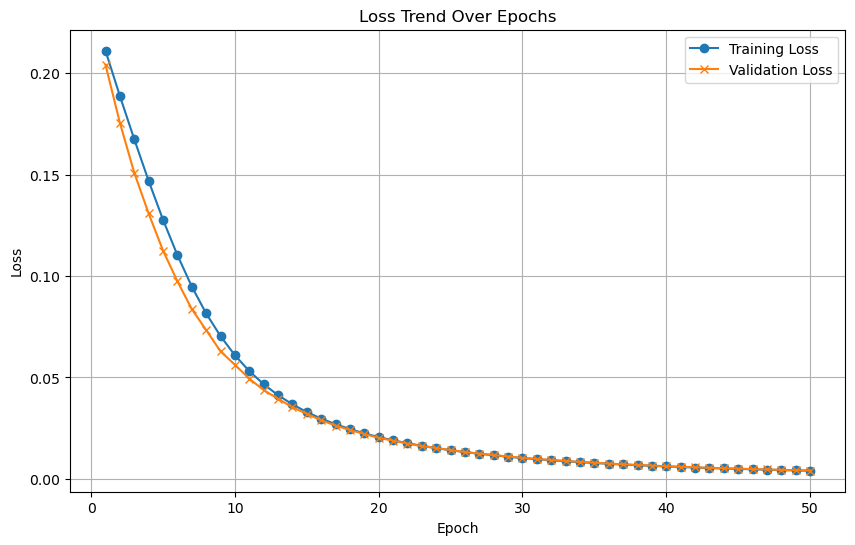

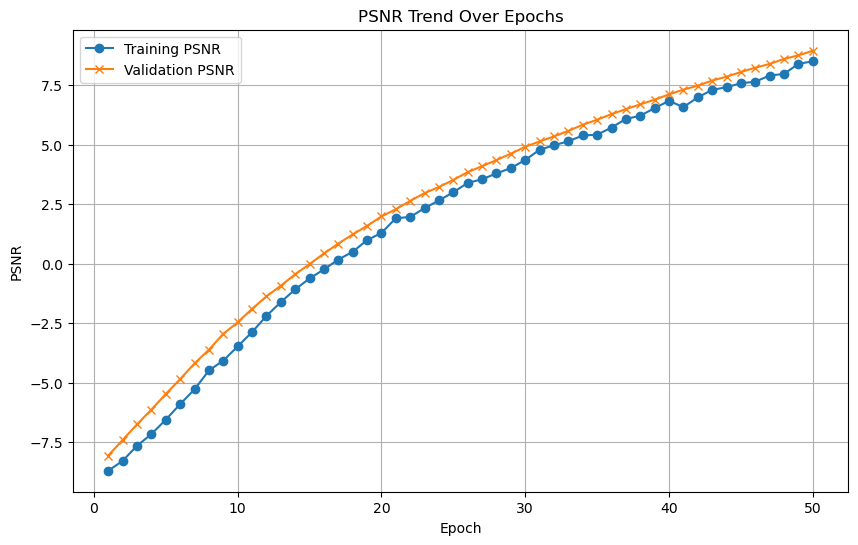

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6398
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6444. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5979
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5742
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5440
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.5307
    Validati

    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.3750
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3689
    Validation Batch [1/1], Loss: 2.6451
Validation Loss: 2.6451, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3541
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3548
    Validation Batch [1/1], Loss: 2.6454
Validation Loss: 2.6454, Va

Epoch [23/1000] completed, Average Training Loss: 2.2992
    Validation Batch [1/1], Loss: 2.6460
Validation Loss: 2.6460, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2817
    Validation Batch [1/1], Loss: 2.6461
Validation Loss: 2.6461, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2923
    Validation Batch [1/1], Loss: 2.6463
Validation Loss: 2.6463, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2619
    Validation Batch [1/1], Loss: 2.6465
Validation Loss: 2.6465, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2585
    Validat

Epoch [39/1000] completed, Average Training Loss: 2.1439
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 8.57%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.1340
    Validation Batch [1/1], Loss: 2.6445
Validation Loss: 2.6445, Validation Accuracy: 8.57%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1391
    Validation Batch [1/1], Loss: 2.6439
Validation Loss: 2.6439, Validation Accuracy: 7.14%
Validation loss improved from 2.6444 to 2.6439. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.1057
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6439 to 2.6433. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Train

Epoch [46/1000] completed, Average Training Loss: 2.0910
    Validation Batch [1/1], Loss: 2.6380
Validation Loss: 2.6380, Validation Accuracy: 7.14%
Validation loss improved from 2.6398 to 2.6380. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.0790
    Validation Batch [1/1], Loss: 2.6360
Validation Loss: 2.6360, Validation Accuracy: 7.14%
Validation loss improved from 2.6380 to 2.6360. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.0584
    Validation Batch [1/1], Loss: 2.6332
Validation Loss: 2.6332, Validation Accuracy: 7.14%
Validation loss improved from 2.6360 to 2.6332. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.0575
    Validation Batch [1/1], Loss: 2.6295
Validation Loss: 2.6295, Validation Accuracy: 7.14%
Validation loss improved from 2.6332 to 2.6295. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/10

    Validation Batch [1/1], Loss: 2.5344
Validation Loss: 2.5344, Validation Accuracy: 15.71%
Validation loss improved from 2.5452 to 2.5344. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.9539
    Validation Batch [1/1], Loss: 2.5223
Validation Loss: 2.5223, Validation Accuracy: 17.14%
Validation loss improved from 2.5344 to 2.5223. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.9187
    Validation Batch [1/1], Loss: 2.5096
Validation Loss: 2.5096, Validation Accuracy: 17.14%
Validation loss improved from 2.5223 to 2.5096. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9189
    Validation Batch [1/1], Loss: 2.4963
Validation Loss: 2.4963, Validation Accuracy: 18.57%
Validation loss improved from 2.5096 to 2.4963. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.9111
    Vali

Epoch [69/1000] completed, Average Training Loss: 1.8845
    Validation Batch [1/1], Loss: 2.4348
Validation Loss: 2.4348, Validation Accuracy: 25.71%
Validation loss improved from 2.4529 to 2.4348. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.8488
    Validation Batch [1/1], Loss: 2.4142
Validation Loss: 2.4142, Validation Accuracy: 27.14%
Validation loss improved from 2.4348 to 2.4142. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.8589
    Validation Batch [1/1], Loss: 2.3921
Validation Loss: 2.3921, Validation Accuracy: 27.14%
Validation loss improved from 2.4142 to 2.3921. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.8449
    Validation Batch [1/1], Loss: 2.3680
Validation Loss: 2.3680, Validation Accuracy: 27.14%
Validation loss improved from 2.3921 to 2.3680. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [7

Epoch [85/1000] completed, Average Training Loss: 1.7476
    Validation Batch [1/1], Loss: 2.0238
Validation Loss: 2.0238, Validation Accuracy: 61.43%
Validation loss improved from 2.0520 to 2.0238. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.7175
    Validation Batch [1/1], Loss: 1.9995
Validation Loss: 1.9995, Validation Accuracy: 58.57%
Validation loss improved from 2.0238 to 1.9995. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.7278
    Validation Batch [1/1], Loss: 1.9688
Validation Loss: 1.9688, Validation Accuracy: 65.71%
Validation loss improved from 1.9995 to 1.9688. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.7242
    Validation Batch [1/1], Loss: 1.9378
Validation Loss: 1.9378, Validation Accuracy: 70.00%
Validation loss improved from 1.9688 to 1.9378. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [8

    Validation Batch [1/1], Loss: 1.8796
Validation Loss: 1.8796, Validation Accuracy: 67.14%
Validation loss improved from 1.8916 to 1.8796. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.6794
    Validation Batch [1/1], Loss: 1.8545
Validation Loss: 1.8545, Validation Accuracy: 64.29%
Validation loss improved from 1.8796 to 1.8545. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.6572
    Validation Batch [1/1], Loss: 1.8343
Validation Loss: 1.8343, Validation Accuracy: 65.71%
Validation loss improved from 1.8545 to 1.8343. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.6394
    Validation Batch [1/1], Loss: 1.8087
Validation Loss: 1.8087, Validation Accuracy: 70.00%
Validation loss improved from 1.8343 to 1.8087. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.6503
    Vali

Epoch [108/1000] completed, Average Training Loss: 1.5146
    Validation Batch [1/1], Loss: 1.6168
Validation Loss: 1.6168, Validation Accuracy: 80.00%
Validation loss improved from 1.6271 to 1.6168. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.5407
    Validation Batch [1/1], Loss: 1.5889
Validation Loss: 1.5889, Validation Accuracy: 80.00%
Validation loss improved from 1.6168 to 1.5889. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.4845
    Validation Batch [1/1], Loss: 1.5808
Validation Loss: 1.5808, Validation Accuracy: 78.57%
Validation loss improved from 1.5889 to 1.5808. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.4812
    Validation Batch [1/1], Loss: 1.5840
Validation Loss: 1.5840, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000

    Validation Batch [1/1], Loss: 1.5700
Validation Loss: 1.5700, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.4838
    Validation Batch [1/1], Loss: 1.5485
Validation Loss: 1.5485, Validation Accuracy: 80.00%
Validation loss improved from 1.5631 to 1.5485. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.4630
    Validation Batch [1/1], Loss: 1.5322
Validation Loss: 1.5322, Validation Accuracy: 85.71%
Validation loss improved from 1.5485 to 1.5322. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.4569
    Validation Batch [1/1], Loss: 1.5426
Validation Loss: 1.5426, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.4316
    Validation Batch [1/1], Lo

Epoch [131/1000] completed, Average Training Loss: 1.3557
    Validation Batch [1/1], Loss: 1.3976
Validation Loss: 1.3976, Validation Accuracy: 90.00%
Validation loss improved from 1.3990 to 1.3976. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.3266
    Validation Batch [1/1], Loss: 1.3812
Validation Loss: 1.3812, Validation Accuracy: 88.57%
Validation loss improved from 1.3976 to 1.3812. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.3483
    Validation Batch [1/1], Loss: 1.3657
Validation Loss: 1.3657, Validation Accuracy: 87.14%
Validation loss improved from 1.3812 to 1.3657. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.3076
    Validation Batch [1/1], Loss: 1.3655
Validation Loss: 1.3655, Validation Accuracy: 87.14%
Validation loss improved from 1.3657 to 1.3655. Saving model...

LOG: Epoch [135/1000] - Training


    Validation Batch [1/1], Loss: 1.3502
Validation Loss: 1.3502, Validation Accuracy: 90.00%
Validation loss improved from 1.3506 to 1.3502. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.2500
    Validation Batch [1/1], Loss: 1.3300
Validation Loss: 1.3300, Validation Accuracy: 85.71%
Validation loss improved from 1.3502 to 1.3300. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.2494
    Validation Batch [1/1], Loss: 1.3246
Validation Loss: 1.3246, Validation Accuracy: 91.43%
Validation loss improved from 1.3300 to 1.3246. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.2757
    Validation Batch [1/1], Loss: 1.3399
Validation Loss: 1.3399, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2322
    Validation 

Epoch [154/1000] completed, Average Training Loss: 1.1502
    Validation Batch [1/1], Loss: 1.2026
Validation Loss: 1.2026, Validation Accuracy: 91.43%
Validation loss improved from 1.2214 to 1.2026. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.1091
    Validation Batch [1/1], Loss: 1.1903
Validation Loss: 1.1903, Validation Accuracy: 92.86%
Validation loss improved from 1.2026 to 1.1903. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.1149
    Validation Batch [1/1], Loss: 1.1914
Validation Loss: 1.1914, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.1121
    Validation Batch [1/1], Loss: 1.1782
Validation Loss: 1.1782, Validation Accuracy: 94.29%
Validation loss improved from 1.1903 to 1.1782. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000

    Validation Batch [1/1], Loss: 1.1503
Validation Loss: 1.1503, Validation Accuracy: 94.29%
Validation loss improved from 1.1603 to 1.1503. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.0707
    Validation Batch [1/1], Loss: 1.1222
Validation Loss: 1.1222, Validation Accuracy: 92.86%
Validation loss improved from 1.1503 to 1.1222. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.0587
    Validation Batch [1/1], Loss: 1.1292
Validation Loss: 1.1292, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.0596
    Validation Batch [1/1], Loss: 1.1307
Validation Loss: 1.1307, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.0719
    Validation Batch [1/1], Lo

Epoch [177/1000] completed, Average Training Loss: 0.9585
    Validation Batch [1/1], Loss: 1.0098
Validation Loss: 1.0098, Validation Accuracy: 95.71%
Validation loss improved from 1.0120 to 1.0098. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.9590
    Validation Batch [1/1], Loss: 1.0173
Validation Loss: 1.0173, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.9556
    Validation Batch [1/1], Loss: 0.9905
Validation Loss: 0.9905, Validation Accuracy: 95.71%
Validation loss improved from 1.0098 to 0.9905. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.9266
    Validation Batch [1/1], Loss: 0.9988
Validation Loss: 0.9988, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Av

Epoch [184/1000] completed, Average Training Loss: 0.9082
    Validation Batch [1/1], Loss: 0.9580
Validation Loss: 0.9580, Validation Accuracy: 92.86%
Validation loss improved from 0.9844 to 0.9580. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.8996
    Validation Batch [1/1], Loss: 0.9638
Validation Loss: 0.9638, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.8624
    Validation Batch [1/1], Loss: 0.9763
Validation Loss: 0.9763, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.8880
    Validation Batch [1/1], Loss: 0.9410
Validation Loss: 0.9410, Validation Accuracy: 95.71%
Validation loss improved from 0.9580 to 0.9410. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Av

Epoch [201/1000] completed, Average Training Loss: 0.7739
    Validation Batch [1/1], Loss: 0.8579
Validation Loss: 0.8579, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.7896
    Validation Batch [1/1], Loss: 0.8622
Validation Loss: 0.8622, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.7577
    Validation Batch [1/1], Loss: 0.8211
Validation Loss: 0.8211, Validation Accuracy: 97.14%
Validation loss improved from 0.8504 to 0.8211. Saving model...

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.7136
    Validation Batch [1/1], Loss: 0.8158
Validation Loss: 0.8158, Validation Accuracy: 97.14%
Validation loss improved from 0.8211 to 0.8158. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Av

    Validation Batch [1/1], Loss: 0.8246
Validation Loss: 0.8246, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.7337
    Validation Batch [1/1], Loss: 0.8038
Validation Loss: 0.8038, Validation Accuracy: 97.14%
Validation loss improved from 0.8158 to 0.8038. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.7159
    Validation Batch [1/1], Loss: 0.8309
Validation Loss: 0.8309, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.7474
    Validation Batch [1/1], Loss: 0.7766
Validation Loss: 0.7766, Validation Accuracy: 97.14%
Validation loss improved from 0.8038 to 0.7766. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.7310
    Validation Batch [1/1], Lo

Epoch [224/1000] completed, Average Training Loss: 0.6037
    Validation Batch [1/1], Loss: 0.7349
Validation Loss: 0.7349, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.6263
    Validation Batch [1/1], Loss: 0.6890
Validation Loss: 0.6890, Validation Accuracy: 97.14%
Validation loss improved from 0.7028 to 0.6890. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.6227
    Validation Batch [1/1], Loss: 0.6793
Validation Loss: 0.6793, Validation Accuracy: 97.14%
Validation loss improved from 0.6890 to 0.6793. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.5952
    Validation Batch [1/1], Loss: 0.6878
Validation Loss: 0.6878, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6722
Validation Loss: 0.6722, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.5750
    Validation Batch [1/1], Loss: 0.6501
Validation Loss: 0.6501, Validation Accuracy: 97.14%
Validation loss improved from 0.6655 to 0.6501. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.5485
    Validation Batch [1/1], Loss: 0.6508
Validation Loss: 0.6508, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.5875
    Validation Batch [1/1], Loss: 0.6653
Validation Loss: 0.6653, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.5640
    Validation Batch [1/1], Loss: 0.6431
Vali

Epoch [247/1000] completed, Average Training Loss: 0.5256
    Validation Batch [1/1], Loss: 0.5722
Validation Loss: 0.5722, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.4922
    Validation Batch [1/1], Loss: 0.5856
Validation Loss: 0.5856, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.4876
    Validation Batch [1/1], Loss: 0.5810
Validation Loss: 0.5810, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.5012
    Validation Batch [1/1], Loss: 0.5615
Validation Loss: 0.5615, Validation Accuracy: 97.14%
Validation loss improved from 0.5660 to 0.5615. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training 

Epoch [255/1000] completed, Average Training Loss: 0.4865
    Validation Batch [1/1], Loss: 0.5281
Validation Loss: 0.5281, Validation Accuracy: 97.14%
Validation loss improved from 0.5425 to 0.5281. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.4708
    Validation Batch [1/1], Loss: 0.5248
Validation Loss: 0.5248, Validation Accuracy: 97.14%
Validation loss improved from 0.5281 to 0.5248. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.4681
    Validation Batch [1/1], Loss: 0.5239
Validation Loss: 0.5239, Validation Accuracy: 97.14%
Validation loss improved from 0.5248 to 0.5239. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.4463
    Validation Batch [1/1], Loss: 0.5210
Validation Loss: 0.5210, Validation Accuracy: 97.14%
Validation loss improved from 0.5239 to 0.5210. Saving model...

LOG: Epoch [259/1000] - Training


Epoch [268/1000] completed, Average Training Loss: 0.4048
    Validation Batch [1/1], Loss: 0.4759
Validation Loss: 0.4759, Validation Accuracy: 97.14%
Validation loss improved from 0.4778 to 0.4759. Saving model...

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.4206
    Validation Batch [1/1], Loss: 0.4810
Validation Loss: 0.4810, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4263
    Validation Batch [1/1], Loss: 0.4968
Validation Loss: 0.4968, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.4342
    Validation Batch [1/1], Loss: 0.4796
Validation Loss: 0.4796, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training 

Epoch [279/1000] completed, Average Training Loss: 0.3754
    Validation Batch [1/1], Loss: 0.4397
Validation Loss: 0.4397, Validation Accuracy: 97.14%
Validation loss improved from 0.4414 to 0.4397. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3915
    Validation Batch [1/1], Loss: 0.4438
Validation Loss: 0.4438, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.3421
    Validation Batch [1/1], Loss: 0.4420
Validation Loss: 0.4420, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.3637
    Validation Batch [1/1], Loss: 0.4375
Validation Loss: 0.4375, Validation Accuracy: 97.14%
Validation loss improved from 0.4397 to 0.4375. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Av

Epoch [289/1000] completed, Average Training Loss: 0.3541
    Validation Batch [1/1], Loss: 0.4127
Validation Loss: 0.4127, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.3197
    Validation Batch [1/1], Loss: 0.4070
Validation Loss: 0.4070, Validation Accuracy: 97.14%
Validation loss improved from 0.4112 to 0.4070. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.3089
    Validation Batch [1/1], Loss: 0.3984
Validation Loss: 0.3984, Validation Accuracy: 95.71%
Validation loss improved from 0.4070 to 0.3984. Saving model...

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.3027
    Validation Batch [1/1], Loss: 0.3931
Validation Loss: 0.3931, Validation Accuracy: 95.71%
Validation loss improved from 0.3984 to 0.3931. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000

Epoch [302/1000] completed, Average Training Loss: 0.3162
    Validation Batch [1/1], Loss: 0.3782
Validation Loss: 0.3782, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.2970
    Validation Batch [1/1], Loss: 0.3749
Validation Loss: 0.3749, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.2919
    Validation Batch [1/1], Loss: 0.3793
Validation Loss: 0.3793, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.2947
    Validation Batch [1/1], Loss: 0.3814
Validation Loss: 0.3814, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3141
  

Epoch [312/1000] completed, Average Training Loss: 0.2756
    Validation Batch [1/1], Loss: 0.3690
Validation Loss: 0.3690, Validation Accuracy: 97.14%
Validation loss improved from 0.3726 to 0.3690. Saving model...

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.2762
    Validation Batch [1/1], Loss: 0.3574
Validation Loss: 0.3574, Validation Accuracy: 97.14%
Validation loss improved from 0.3690 to 0.3574. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.2960
    Validation Batch [1/1], Loss: 0.3459
Validation Loss: 0.3459, Validation Accuracy: 97.14%
Validation loss improved from 0.3574 to 0.3459. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.2714
    Validation Batch [1/1], Loss: 0.3638
Validation Loss: 0.3638, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000

    Validation Batch [1/1], Loss: 0.3241
Validation Loss: 0.3241, Validation Accuracy: 95.71%
Validation loss improved from 0.3436 to 0.3241. Saving model...

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.2593
    Validation Batch [1/1], Loss: 0.3272
Validation Loss: 0.3272, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.2558
    Validation Batch [1/1], Loss: 0.3373
Validation Loss: 0.3373, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2663
    Validation Batch [1/1], Loss: 0.3401
Validation Loss: 0.3401, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2356
    Validation Batch [1/1], Loss: 0.3170
Vali

    Validation Batch [1/1], Loss: 0.3230
Validation Loss: 0.3230, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.2219
    Validation Batch [1/1], Loss: 0.3141
Validation Loss: 0.3141, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 0.3083
Validation Loss: 0.3083, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2579
    Validation Batch [1/1], Loss: 0.3068
Validation Loss: 0.3068, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2270
    Validation Batch [1/1], Loss: 0.3164
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.2890
Validation Loss: 0.2890, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.1954
    Validation Batch [1/1], Loss: 0.2917
Validation Loss: 0.2917, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2058
    Validation Batch [1/1], Loss: 0.2916
Validation Loss: 0.2916, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.2013
    Validation Batch [1/1], Loss: 0.2964
Validation Loss: 0.2964, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.2133
    Validation Batch [1/1], Loss: 0.2962
Validation Loss: 0.

Epoch [357/1000] completed, Average Training Loss: 0.1831
    Validation Batch [1/1], Loss: 0.2911
Validation Loss: 0.2911, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.1991
    Validation Batch [1/1], Loss: 0.2915
Validation Loss: 0.2915, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.2037
    Validation Batch [1/1], Loss: 0.2814
Validation Loss: 0.2814, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.1778
    Validation Batch [1/1], Loss: 0.2727
Validation Loss: 0.2727, Validation Accuracy: 97.14%
Validation loss improved from 0.2792 to 0.2727. Saving model...

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2969
Validation Loss: 0.2969, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1779
    Validation Batch [1/1], Loss: 0.2789
Validation Loss: 0.2789, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1788
    Validation Batch [1/1], Loss: 0.2573
Validation Loss: 0.2573, Validation Accuracy: 97.14%
Validation loss improved from 0.2645 to 0.2573. Saving model...

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1786
    Validation Batch [1/1], Loss: 0.2535
Validation Loss: 0.2535, Validation Accuracy: 97.14%
Validation loss improved from 0.2573 to 0.2535. Saving model...

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1678
    Validation Batch [1/1], Lo

Epoch [380/1000] completed, Average Training Loss: 0.1620
    Validation Batch [1/1], Loss: 0.2523
Validation Loss: 0.2523, Validation Accuracy: 97.14%
Validation loss improved from 0.2535 to 0.2523. Saving model...

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1693
    Validation Batch [1/1], Loss: 0.2444
Validation Loss: 0.2444, Validation Accuracy: 97.14%
Validation loss improved from 0.2523 to 0.2444. Saving model...

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1573
    Validation Batch [1/1], Loss: 0.2577
Validation Loss: 0.2577, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1483
    Validation Batch [1/1], Loss: 0.2709
Validation Loss: 0.2709, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Av

Epoch [396/1000] completed, Average Training Loss: 0.1447
    Validation Batch [1/1], Loss: 0.2399
Validation Loss: 0.2399, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1469
    Validation Batch [1/1], Loss: 0.2337
Validation Loss: 0.2337, Validation Accuracy: 97.14%
Validation loss improved from 0.2386 to 0.2337. Saving model...

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1326
    Validation Batch [1/1], Loss: 0.2429
Validation Loss: 0.2429, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1549
    Validation Batch [1/1], Loss: 0.2449
Validation Loss: 0.2449, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training 

Epoch [404/1000] completed, Average Training Loss: 0.1415
    Validation Batch [1/1], Loss: 0.2347
Validation Loss: 0.2347, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1317
    Validation Batch [1/1], Loss: 0.2487
Validation Loss: 0.2487, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1275
    Validation Batch [1/1], Loss: 0.2497
Validation Loss: 0.2497, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1386
    Validation Batch [1/1], Loss: 0.2483
Validation Loss: 0.2483, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1280
  

    Validation Batch [1/1], Loss: 0.2238
Validation Loss: 0.2238, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.2347
Validation Loss: 0.2347, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1380
    Validation Batch [1/1], Loss: 0.2534
Validation Loss: 0.2534, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1354
    Validation Batch [1/1], Loss: 0.2522
Validation Loss: 0.2522, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [423/1000] - Training


Epoch [423/1000] completed, Average Training Loss: 0.1223
    Validation Batch [1/1], Loss: 0.2397
Validation Loss: 0.2397, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1169
    Validation Batch [1/1], Loss: 0.2308
Validation Loss: 0.2308, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 0.2298
Validation Loss: 0.2298, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1187
    Validation Batch [1/1], Loss: 0.2293
Validation Loss: 0.2293, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1423
 

Epoch [432/1000] completed, Average Training Loss: 0.1138
    Validation Batch [1/1], Loss: 0.2065
Validation Loss: 0.2065, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1140
    Validation Batch [1/1], Loss: 0.2089
Validation Loss: 0.2089, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1073
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1176
    Validation Batch [1/1], Loss: 0.2090
Validation Loss: 0.2090, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1179
  

Epoch [446/1000] completed, Average Training Loss: 0.1062
    Validation Batch [1/1], Loss: 0.2513
Validation Loss: 0.2513, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1155
    Validation Batch [1/1], Loss: 0.2515
Validation Loss: 0.2515, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1058
    Validation Batch [1/1], Loss: 0.2370
Validation Loss: 0.2370, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.2146
Validation Loss: 0.2146, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.100

    Validation Batch [1/1], Loss: 0.2237
Validation Loss: 0.2237, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0930
    Validation Batch [1/1], Loss: 0.2368
Validation Loss: 0.2368, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1114
    Validation Batch [1/1], Loss: 0.2177
Validation Loss: 0.2177, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0924
    Validation Batch [1/1], Loss: 0.1880
Validation Loss: 0.1880, Validation Accuracy: 97.14%
Validation loss improved from 0.1936 to 0.1880. Saving model...

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0959
    Validation Batch [1/1], Loss: 0.1789
Vali

Epoch [468/1000] completed, Average Training Loss: 0.0864
    Validation Batch [1/1], Loss: 0.1927
Validation Loss: 0.1927, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0927
    Validation Batch [1/1], Loss: 0.1979
Validation Loss: 0.1979, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.2069
Validation Loss: 0.2069, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0925
    Validation Batch [1/1], Loss: 0.2118
Validation Loss: 0.2118, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0959

Epoch [478/1000] completed, Average Training Loss: 0.0923
    Validation Batch [1/1], Loss: 0.1842
Validation Loss: 0.1842, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0834
    Validation Batch [1/1], Loss: 0.2025
Validation Loss: 0.2025, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0921
    Validation Batch [1/1], Loss: 0.2185
Validation Loss: 0.2185, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.0874
    Validation Batch [1/1], Loss: 0.2132
Validation Loss: 0.2132, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0884
  

    Validation Batch [1/1], Loss: 0.1818
Validation Loss: 0.1818, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.1793
Validation Loss: 0.1793, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.2013
Validation Loss: 0.2013, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0784
    Validation Batch [1/1], Loss: 0.2099
Validation Loss: 0.2099, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Loss: 0.2095
Validation Loss

Epoch [501/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.1896
Validation Loss: 0.1896, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.1750
Validation Loss: 0.1750, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.1741
Validation Loss: 0.1741, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 0.1920
Validation Loss: 0.1920, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.085

Epoch [515/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.1696
Validation Loss: 0.1696, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.1684
Validation Loss: 0.1684, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.1688
Validation Loss: 0.1688, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0773
    Validation Batch [1/1], Loss: 0.1708
Validation Loss: 0.1708, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0766
  

Epoch [523/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.1716
Validation Loss: 0.1716, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.1760
Validation Loss: 0.1760, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.1739
Validation Loss: 0.1739, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0644
    Validation Batch [1/1], Loss: 0.1704
Validation Loss: 0.1704, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.073

    Validation Batch [1/1], Loss: 0.1725
Validation Loss: 0.1725, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.1821
Validation Loss: 0.1821, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1916
Validation Loss: 0.1916, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.1966
Validation Loss: 0.1966, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.1895
Validation Loss: 0.

Epoch [546/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.1708
Validation Loss: 0.1708, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.1672
Validation Loss: 0.1672, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0509
    Validation Batch [1/1], Loss: 0.1772
Validation Loss: 0.1772, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.1851
Validation Loss: 0.1851, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.059

    Validation Batch [1/1], Loss: 0.1923
Validation Loss: 0.1923, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.1962
Validation Loss: 0.1962, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.1904
Validation Loss: 0.1904, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.1894
Validation Loss: 0.1894, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0587
    Validation Batch [1/1], Loss: 0.1652
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.1510
Validation Loss: 0.1510, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.1691
Validation Loss: 0.1691, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.1831
Validation Loss: 0.1831, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.

Epoch [584/1000] completed, Average Training Loss: 0.0596
    Validation Batch [1/1], Loss: 0.1554
Validation Loss: 0.1554, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.1711
Validation Loss: 0.1711, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0468
    Validation Batch [1/1], Loss: 0.1705
Validation Loss: 0.1705, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0517
    Validation Batch [1/1], Loss: 0.1595
Validation Loss: 0.1595, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0522
  

    Validation Batch [1/1], Loss: 0.1513
Validation Loss: 0.1513, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.1534
Validation Loss: 0.1534, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.1530
Validation Loss: 0.1530, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0551
    Validation Batch [1/1], Loss: 0.1574
Validation Loss: 0.1574, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.1579
Validation Loss:

Epoch [607/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.1341
Validation Loss: 0.1341, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.1337
Validation Loss: 0.1337, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.1437
Validation Loss: 0.1437, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.1475
Validation Loss: 0.1475, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.041

Epoch [613/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.1440
Validation Loss: 0.1440, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.1538
Validation Loss: 0.1538, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0528
    Validation Batch [1/1], Loss: 0.1692
Validation Loss: 0.1692, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.1887
Validation Loss: 0.1887, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.047

Epoch [632/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.1615
Validation Loss: 0.1615, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1596
Validation Loss: 0.1596, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.1600
Validation Loss: 0.1600, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0517
    Validation Batch [1/1], Loss: 0.1725
Validation Loss: 0.1725, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.043

Epoch [637/1000] completed, Average Training Loss: 0.0457
    Validation Batch [1/1], Loss: 0.1729
Validation Loss: 0.1729, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.1606
Validation Loss: 0.1606, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.1660
Validation Loss: 0.1660, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.1725
Validation Loss: 0.1725, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.037

Epoch [655/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.1539
Validation Loss: 0.1539, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.1442
Validation Loss: 0.1442, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.1338
Validation Loss: 0.1338, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.1357
Validation Loss: 0.1357, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.039

Epoch [660/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.1415
Validation Loss: 0.1415, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.1422
Validation Loss: 0.1422, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.1442
Validation Loss: 0.1442, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.1477
Validation Loss: 0.1477, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.039

Epoch [678/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.1707
Validation Loss: 0.1707, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.1622
Validation Loss: 0.1622, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.1499
Validation Loss: 0.1499, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 681. No improvement for 100 epochs.
Loading the best mo

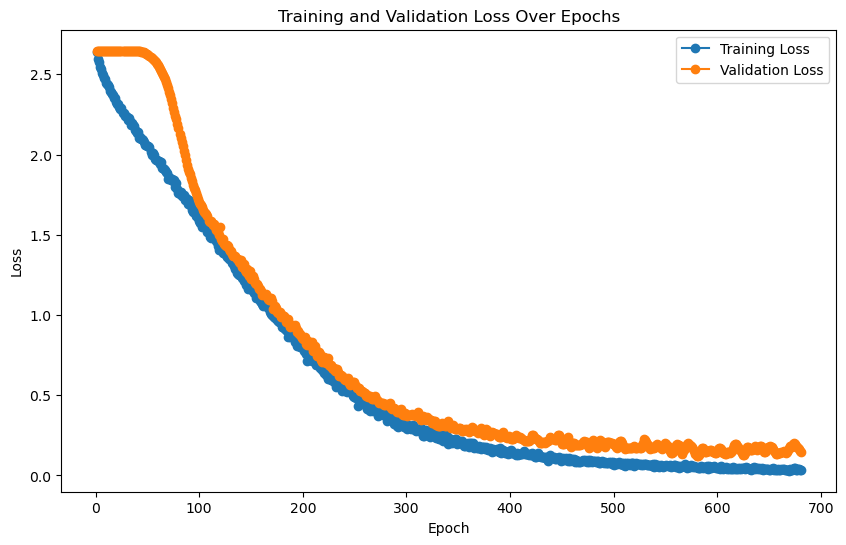

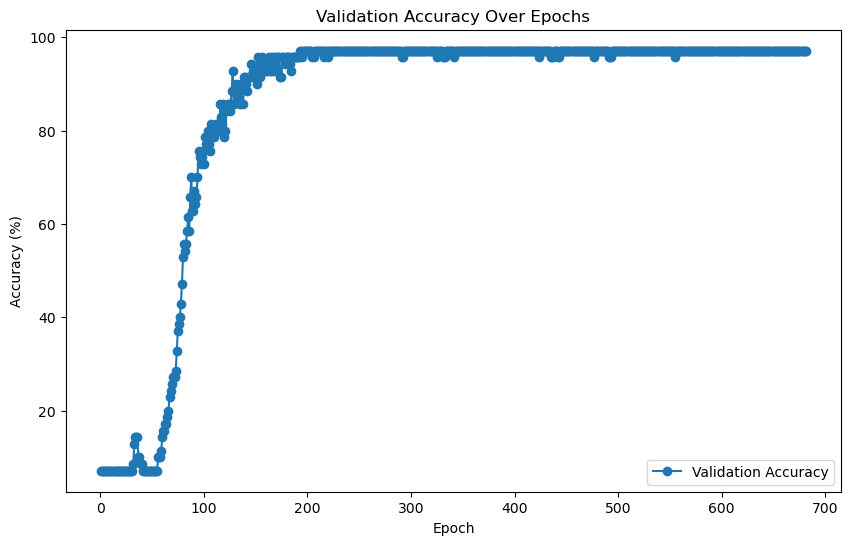


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0451

Final Test Loss: 0.1540, Test Accuracy: 97.10%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)

LOG: Training features shape: (280, 64), Training labels shape: (280,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2898, 64), Test labels shape: (2898,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)
Train reps shape: (280, 64)
Train labels shape: (280,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2898, 64)
Test labels shape: (2898,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6549  |  Val Loss: 2.6235
Validation loss improved from inf to 2.6235.
[Epoch 2/1000] Train Loss: 2.6131  |  Val Loss: 2.6034
Validation loss improved from 2.6235 to 2.6034.
[Epoch 3/1000] Train Loss: 2.5978  |  Val Loss: 2.5847
Validation loss improved from 2.6034 to 2.5847.
[Epoch 4/1000] Train Loss: 2.5789  |  Val Loss: 2.5707
Validation loss improved from 2.5847 to 2.5707.
[Epoch 5/1000] Train Loss: 2.5650  |  Val Loss: 2.5548
Validation loss improved from 2.5707 to 2.5548.
[Epoch 6/1000] Train Loss: 2.5464  |  Val Loss: 2.5398
Validation loss improved from 2.5548 to 2.5398.
[Epoch 7/1000] Train Loss: 2.5291  |  Val Loss: 2.5143
Validation loss improved from 2.5398 to 2.5143.
[Epoch 8/1000] Train Loss: 2.5026  |  Val Loss: 2.4888
Validation loss improved from 2.5143 to 2.4888.
[Epoch 9/1000] Train Loss: 2.4832  |  Val Loss: 2.4658
Validation loss improved from 2.4888 to 2.4658.
[Epoch 10/1000] Train Loss: 2.4553  |  Val Loss: 2.4394
Validation loss impr

[Epoch 16/1000] Train Loss: 2.2147  |  Val Loss: 2.1830
Validation loss improved from 2.2269 to 2.1830.


[Epoch 17/1000] Train Loss: 2.1678  |  Val Loss: 2.1481
Validation loss improved from 2.1830 to 2.1481.
[Epoch 18/1000] Train Loss: 2.1242  |  Val Loss: 2.1017
Validation loss improved from 2.1481 to 2.1017.
[Epoch 19/1000] Train Loss: 2.0894  |  Val Loss: 2.0704
Validation loss improved from 2.1017 to 2.0704.
[Epoch 20/1000] Train Loss: 2.0429  |  Val Loss: 2.0254
Validation loss improved from 2.0704 to 2.0254.
[Epoch 21/1000] Train Loss: 2.0136  |  Val Loss: 1.9896
Validation loss improved from 2.0254 to 1.9896.
[Epoch 22/1000] Train Loss: 1.9568  |  Val Loss: 1.9322
Validation loss improved from 1.9896 to 1.9322.
[Epoch 23/1000] Train Loss: 1.9154  |  Val Loss: 1.9133
Validation loss improved from 1.9322 to 1.9133.
[Epoch 24/1000] Train Loss: 1.8931  |  Val Loss: 1.8544
Validation loss improved from 1.9133 to 1.8544.
[Epoch 25/1000] Train Loss: 1.8437  |  Val Loss: 1.8295
Validation loss improved from 1.8544 to 1.8295.
[Epoch 26/1000] Train Loss: 1.8123  |  Val Loss: 1.7821
Validati

[Epoch 34/1000] Train Loss: 1.6027  |  Val Loss: 1.5857
Validation loss improved from 1.6057 to 1.5857.
[Epoch 35/1000] Train Loss: 1.5834  |  Val Loss: 1.5506
Validation loss improved from 1.5857 to 1.5506.
[Epoch 36/1000] Train Loss: 1.5682  |  Val Loss: 1.5360
Validation loss improved from 1.5506 to 1.5360.
[Epoch 37/1000] Train Loss: 1.5541  |  Val Loss: 1.5275
Validation loss improved from 1.5360 to 1.5275.
[Epoch 38/1000] Train Loss: 1.5402  |  Val Loss: 1.5852
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 1.5323  |  Val Loss: 1.5085
Validation loss improved from 1.5275 to 1.5085.
[Epoch 40/1000] Train Loss: 1.5294  |  Val Loss: 1.4762
Validation loss improved from 1.5085 to 1.4762.
[Epoch 41/1000] Train Loss: 1.4964  |  Val Loss: 1.4604
Validation loss improved from 1.4762 to 1.4604.
[Epoch 42/1000] Train Loss: 1.4803  |  Val Loss: 1.5221
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 1.4910  |  Val Loss: 1.4

[Epoch 52/1000] Train Loss: 1.4065  |  Val Loss: 1.3616
Validation loss improved from 1.3841 to 1.3616.
[Epoch 53/1000] Train Loss: 1.3925  |  Val Loss: 1.3854
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 1.3889  |  Val Loss: 1.3419
Validation loss improved from 1.3616 to 1.3419.
[Epoch 55/1000] Train Loss: 1.3837  |  Val Loss: 1.3382
Validation loss improved from 1.3419 to 1.3382.
[Epoch 56/1000] Train Loss: 1.3713  |  Val Loss: 1.3573
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.3708  |  Val Loss: 1.3227
Validation loss improved from 1.3382 to 1.3227.
[Epoch 58/1000] Train Loss: 1.3596  |  Val Loss: 1.3413
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 1.3704  |  Val Loss: 1.3609
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 1.3560  |  Val Loss: 1.3251
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 1.3613

[Epoch 71/1000] Train Loss: 1.3272  |  Val Loss: 1.2820
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 72/1000] Train Loss: 1.3217  |  Val Loss: 1.2625
Validation loss improved from 1.2707 to 1.2625.
[Epoch 73/1000] Train Loss: 1.3100  |  Val Loss: 1.2615
Validation loss improved from 1.2625 to 1.2615.
[Epoch 74/1000] Train Loss: 1.3424  |  Val Loss: 1.4131
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] Train Loss: 1.3485  |  Val Loss: 1.3418
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 1.3964  |  Val Loss: 1.2884
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 1.3461  |  Val Loss: 1.3171
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 1.3540  |  Val Loss: 1.2757
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 79/1000] Train Loss: 1.3037  |  Val Loss: 1.3556
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 80/1000] Train 

[Epoch 90/1000] Train Loss: 1.2737  |  Val Loss: 1.2528
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 1.2931  |  Val Loss: 1.2331
Validation loss improved from 1.2376 to 1.2331.
[Epoch 92/1000] Train Loss: 1.2746  |  Val Loss: 1.2377
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 1.2865  |  Val Loss: 1.2330
Validation loss improved from 1.2331 to 1.2330.
[Epoch 94/1000] Train Loss: 1.2713  |  Val Loss: 1.2460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 1.2807  |  Val Loss: 1.3087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 1.2949  |  Val Loss: 1.2264
Validation loss improved from 1.2330 to 1.2264.
[Epoch 97/1000] Train Loss: 1.2697  |  Val Loss: 1.2634
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.2648  |  Val Loss: 1.2171
Validation loss improved from 1.2264 to 1.2171.
[Epoch 99/1000] Train Loss: 1.2702

[Epoch 110/1000] Train Loss: 1.2604  |  Val Loss: 1.2819
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 111/1000] Train Loss: 1.2761  |  Val Loss: 1.2224
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 112/1000] Train Loss: 1.2555  |  Val Loss: 1.2321
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 113/1000] Train Loss: 1.2562  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 114/1000] Train Loss: 1.2498  |  Val Loss: 1.2001
Validation loss improved from 1.2075 to 1.2001.
[Epoch 115/1000] Train Loss: 1.2587  |  Val Loss: 1.3427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.2910  |  Val Loss: 1.2223
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 1.2569  |  Val Loss: 1.2819
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 1.2614  |  Val Loss: 1.1993
Validation loss improved from 1.2001 to 1.1993.
[Epoch 119/10

[Epoch 130/1000] Train Loss: 1.2566  |  Val Loss: 1.2153
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 131/1000] Train Loss: 1.2370  |  Val Loss: 1.2418
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 132/1000] Train Loss: 1.2450  |  Val Loss: 1.1990
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 133/1000] Train Loss: 1.2352  |  Val Loss: 1.2517
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 134/1000] Train Loss: 1.2378  |  Val Loss: 1.1916
Validation loss improved from 1.1953 to 1.1916.
[Epoch 135/1000] Train Loss: 1.2370  |  Val Loss: 1.1871
Validation loss improved from 1.1916 to 1.1871.
[Epoch 136/1000] Train Loss: 1.2280  |  Val Loss: 1.2442
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 1.2495  |  Val Loss: 1.1938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 138/1000] Train Loss: 1.2176  |  Val Loss: 1.2373
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 139/

[Epoch 149/1000] Train Loss: 1.2621  |  Val Loss: 1.1924
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 150/1000] Train Loss: 1.2237  |  Val Loss: 1.2085
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 151/1000] Train Loss: 1.2304  |  Val Loss: 1.2190
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 152/1000] Train Loss: 1.2260  |  Val Loss: 1.1856
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 153/1000] Train Loss: 1.2472  |  Val Loss: 1.2595
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 154/1000] Train Loss: 1.2256  |  Val Loss: 1.1952
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 155/1000] Train Loss: 1.2371  |  Val Loss: 1.1859
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 156/1000] Train Loss: 1.2357  |  Val Loss: 1.2753
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 157/1000] Train Loss: 1.2469  |  Val Loss: 1.2064
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 1.2458  |  Val Loss: 1.1724
Validation loss improved from 1.1826 to 1.1724.
[Epoch 167/1000] Train Loss: 1.2125  |  Val Loss: 1.1845
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 1.2326  |  Val Loss: 1.2246
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 1.2179  |  Val Loss: 1.1732
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 170/1000] Train Loss: 1.2141  |  Val Loss: 1.2187
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 171/1000] Train Loss: 1.2135  |  Val Loss: 1.1787
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 172/1000] Train Loss: 1.2347  |  Val Loss: 1.2832
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 173/1000] Train Loss: 1.2238  |  Val Loss: 1.1818
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 174/1000] Train Loss: 1.2293  |  Val Loss: 1.2682
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 186/1000] Train Loss: 1.2008  |  Val Loss: 1.1693
Validation loss improved from 1.1724 to 1.1693.
[Epoch 187/1000] Train Loss: 1.2288  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 1.2110  |  Val Loss: 1.1679
Validation loss improved from 1.1693 to 1.1679.
[Epoch 189/1000] Train Loss: 1.2151  |  Val Loss: 1.1981
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 1.1863  |  Val Loss: 1.2000
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 191/1000] Train Loss: 1.2197  |  Val Loss: 1.2174
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 192/1000] Train Loss: 1.2049  |  Val Loss: 1.2069
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 193/1000] Train Loss: 1.2271  |  Val Loss: 1.1752
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 194/1000] Train Loss: 1.2529  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 195/10

[Epoch 205/1000] Train Loss: 1.1979  |  Val Loss: 1.1631
Validation loss improved from 1.1667 to 1.1631.
[Epoch 206/1000] Train Loss: 1.2281  |  Val Loss: 1.1907
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 1.1900  |  Val Loss: 1.1762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 1.1849  |  Val Loss: 1.1876
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 1.1951  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 1.1845  |  Val Loss: 1.1700
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 211/1000] Train Loss: 1.2151  |  Val Loss: 1.2728
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 212/1000] Train Loss: 1.1985  |  Val Loss: 1.1715
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 213/1000] Train Loss: 1.2085  |  Val Loss: 1.1952
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 224/1000] Train Loss: 1.1775  |  Val Loss: 1.1967
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 225/1000] Train Loss: 1.1880  |  Val Loss: 1.1870
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 226/1000] Train Loss: 1.1825  |  Val Loss: 1.2002
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 227/1000] Train Loss: 1.1949  |  Val Loss: 1.1640
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 228/1000] Train Loss: 1.1875  |  Val Loss: 1.2999
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 229/1000] Train Loss: 1.2043  |  Val Loss: 1.1682
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 230/1000] Train Loss: 1.2268  |  Val Loss: 1.2458
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 231/1000] Train Loss: 1.1994  |  Val Loss: 1.1720
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 232/1000] Train Loss: 1.2097  |  Val Loss: 1.1617
!! Validation loss did NOT improve !! Patience: 15

[Epoch 242/1000] Train Loss: 1.1719  |  Val Loss: 1.1631
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 243/1000] Train Loss: 1.1708  |  Val Loss: 1.1686
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 244/1000] Train Loss: 1.1732  |  Val Loss: 1.1562
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 245/1000] Train Loss: 1.1854  |  Val Loss: 1.1863
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 246/1000] Train Loss: 1.1796  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 247/1000] Train Loss: 1.1685  |  Val Loss: 1.1560
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 248/1000] Train Loss: 1.1879  |  Val Loss: 1.2582
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 249/1000] Train Loss: 1.2012  |  Val Loss: 1.1714
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 250/1000] Train Loss: 1.2126  |  Val Loss: 1.3483
!! Validation loss did NOT improve !! Patience:

[Epoch 261/1000] Train Loss: 1.1666  |  Val Loss: 1.1998
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 262/1000] Train Loss: 1.1719  |  Val Loss: 1.1636
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 263/1000] Train Loss: 1.1608  |  Val Loss: 1.1807
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 264/1000] Train Loss: 1.1569  |  Val Loss: 1.1938
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 265/1000] Train Loss: 1.1827  |  Val Loss: 1.2159
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 266/1000] Train Loss: 1.1833  |  Val Loss: 1.1385
Validation loss improved from 1.1391 to 1.1385.
[Epoch 267/1000] Train Loss: 1.2089  |  Val Loss: 1.2979
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 1.2045  |  Val Loss: 1.1636
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 269/1000] Train Loss: 1.1964  |  Val Loss: 1.2904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 279/1000] Train Loss: 1.1617  |  Val Loss: 1.1439
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 280/1000] Train Loss: 1.1626  |  Val Loss: 1.2015
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 281/1000] Train Loss: 1.1592  |  Val Loss: 1.1390
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 282/1000] Train Loss: 1.1526  |  Val Loss: 1.2160
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 283/1000] Train Loss: 1.1675  |  Val Loss: 1.1430
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 284/1000] Train Loss: 1.1631  |  Val Loss: 1.2037
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 285/1000] Train Loss: 1.1573  |  Val Loss: 1.1628
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 286/1000] Train Loss: 1.1473  |  Val Loss: 1.2044
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 287/1000] Train Loss: 1.1431  |  Val Loss: 1.1511
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 1.1601  |  Val Loss: 1.1886
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 300/1000] Train Loss: 1.1667  |  Val Loss: 1.1519
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 301/1000] Train Loss: 1.1415  |  Val Loss: 1.1659
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 302/1000] Train Loss: 1.1362  |  Val Loss: 1.1358
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 303/1000] Train Loss: 1.1401  |  Val Loss: 1.1747
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 304/1000] Train Loss: 1.1369  |  Val Loss: 1.1303
Validation loss improved from 1.1339 to 1.1303.
[Epoch 305/1000] Train Loss: 1.1538  |  Val Loss: 1.1853
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Train Loss: 1.1461  |  Val Loss: 1.1424
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 307/1000] Train Loss: 1.1655  |  Val Loss: 1.1263
Validation loss improved from 1.1303 to 1.1263.
[Epoch 3

[Epoch 318/1000] Train Loss: 1.1487  |  Val Loss: 1.2073
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 319/1000] Train Loss: 1.1396  |  Val Loss: 1.1295
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 320/1000] Train Loss: 1.1643  |  Val Loss: 1.1657
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 321/1000] Train Loss: 1.1616  |  Val Loss: 1.1716
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 322/1000] Train Loss: 1.1343  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 323/1000] Train Loss: 1.1587  |  Val Loss: 1.2130
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 324/1000] Train Loss: 1.1583  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 325/1000] Train Loss: 1.1341  |  Val Loss: 1.1411
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 326/1000] Train Loss: 1.1388  |  Val Loss: 1.1982
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 337/1000] Train Loss: 1.1262  |  Val Loss: 1.1417
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 338/1000] Train Loss: 1.1130  |  Val Loss: 1.1489
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 339/1000] Train Loss: 1.1204  |  Val Loss: 1.1257
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 340/1000] Train Loss: 1.1299  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 341/1000] Train Loss: 1.1267  |  Val Loss: 1.0958
Validation loss improved from 1.1112 to 1.0958.
[Epoch 342/1000] Train Loss: 1.1540  |  Val Loss: 1.2376
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/1000] Train Loss: 1.1594  |  Val Loss: 1.1123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 344/1000] Train Loss: 1.1271  |  Val Loss: 1.2063
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 345/1000] Train Loss: 1.1273  |  Val Loss: 1.1043
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 358/1000] Train Loss: 1.1400  |  Val Loss: 1.2288
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 359/1000] Train Loss: 1.1101  |  Val Loss: 1.1152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 360/1000] Train Loss: 1.1493  |  Val Loss: 1.2376
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 361/1000] Train Loss: 1.1172  |  Val Loss: 1.0957
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 362/1000] Train Loss: 1.1316  |  Val Loss: 1.2310
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 363/1000] Train Loss: 1.1274  |  Val Loss: 1.0834
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 364/1000] Train Loss: 1.1405  |  Val Loss: 1.2039
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 365/1000] Train Loss: 1.1187  |  Val Loss: 1.1282
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 366/1000] Train Loss: 1.1562  |  Val Loss: 1.1202
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 376/1000] Train Loss: 1.0884  |  Val Loss: 1.0913
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 377/1000] Train Loss: 1.0769  |  Val Loss: 1.1047
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 378/1000] Train Loss: 1.0742  |  Val Loss: 1.0950
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 379/1000] Train Loss: 1.0790  |  Val Loss: 1.1390
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 380/1000] Train Loss: 1.0853  |  Val Loss: 1.0832
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 381/1000] Train Loss: 1.1126  |  Val Loss: 1.1305
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 382/1000] Train Loss: 1.0993  |  Val Loss: 1.0870
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 383/1000] Train Loss: 1.0872  |  Val Loss: 1.1274
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 384/1000] Train Loss: 1.0753  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 1

[Epoch 395/1000] Train Loss: 1.0785  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 396/1000] Train Loss: 1.0991  |  Val Loss: 1.0749
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 397/1000] Train Loss: 1.0964  |  Val Loss: 1.1530
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 398/1000] Train Loss: 1.0662  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 399/1000] Train Loss: 1.0738  |  Val Loss: 1.1413
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 400/1000] Train Loss: 1.0932  |  Val Loss: 1.0963
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 401/1000] Train Loss: 1.0869  |  Val Loss: 1.0826
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 402/1000] Train Loss: 1.0676  |  Val Loss: 1.1173
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 403/1000] Train Loss: 1.0581  |  Val Loss: 1.1012
!! Validation loss did NOT improve !! Patience: 15

[Epoch 415/1000] Train Loss: 1.0588  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 416/1000] Train Loss: 1.0626  |  Val Loss: 1.0807
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 417/1000] Train Loss: 1.0437  |  Val Loss: 1.0672
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 418/1000] Train Loss: 1.0547  |  Val Loss: 1.0613
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 419/1000] Train Loss: 1.0503  |  Val Loss: 1.1303
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 420/1000] Train Loss: 1.0698  |  Val Loss: 1.0628
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 421/1000] Train Loss: 1.0521  |  Val Loss: 1.2031
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 422/1000] Train Loss: 1.0920  |  Val Loss: 1.0775
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 423/1000] Train Loss: 1.0942  |  Val Loss: 1.2148
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 434/1000] Train Loss: 1.0687  |  Val Loss: 1.0439
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 435/1000] Train Loss: 1.0587  |  Val Loss: 1.0693
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 436/1000] Train Loss: 1.0337  |  Val Loss: 1.0371
Validation loss improved from 1.0421 to 1.0371.
[Epoch 437/1000] Train Loss: 1.0335  |  Val Loss: 1.0870
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 438/1000] Train Loss: 1.0289  |  Val Loss: 1.0350
Validation loss improved from 1.0371 to 1.0350.
[Epoch 439/1000] Train Loss: 1.0522  |  Val Loss: 1.1011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 440/1000] Train Loss: 1.0342  |  Val Loss: 1.0335
Validation loss improved from 1.0350 to 1.0335.
[Epoch 441/1000] Train Loss: 1.0221  |  Val Loss: 1.1132
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 442/1000] Train Loss: 1.0411  |  Val Loss: 1.0301
Validation loss improved from 1.0335 to 1.0301.
[Epoch 443/1000] Train Lo

[Epoch 453/1000] Train Loss: 1.0229  |  Val Loss: 1.0027
Validation loss improved from 1.0284 to 1.0027.
[Epoch 454/1000] Train Loss: 1.0248  |  Val Loss: 1.1535
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 455/1000] Train Loss: 1.0310  |  Val Loss: 1.0188
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 456/1000] Train Loss: 1.0412  |  Val Loss: 1.1690
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 457/1000] Train Loss: 1.0604  |  Val Loss: 1.0328
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 458/1000] Train Loss: 0.9990  |  Val Loss: 1.1387
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 459/1000] Train Loss: 1.0659  |  Val Loss: 1.0335
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 460/1000] Train Loss: 1.0230  |  Val Loss: 1.1554
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 461/1000] Train Loss: 1.0341  |  Val Loss: 1.0495
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 472/1000] Train Loss: 0.9949  |  Val Loss: 1.0355
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 473/1000] Train Loss: 0.9761  |  Val Loss: 0.9962
Validation loss improved from 1.0027 to 0.9962.
[Epoch 474/1000] Train Loss: 0.9757  |  Val Loss: 1.0431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 475/1000] Train Loss: 0.9946  |  Val Loss: 1.0306
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 476/1000] Train Loss: 0.9979  |  Val Loss: 1.0154
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 477/1000] Train Loss: 0.9795  |  Val Loss: 1.0468
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 478/1000] Train Loss: 0.9787  |  Val Loss: 1.0150
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 479/1000] Train Loss: 0.9789  |  Val Loss: 1.0508
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 480/1000] Train Loss: 0.9801  |  Val Loss: 0.9976
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 491/1000] Train Loss: 0.9664  |  Val Loss: 1.0523
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 492/1000] Train Loss: 0.9803  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 493/1000] Train Loss: 0.9760  |  Val Loss: 0.9842
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 494/1000] Train Loss: 0.9678  |  Val Loss: 1.0285
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 495/1000] Train Loss: 0.9606  |  Val Loss: 0.9727
Validation loss improved from 0.9786 to 0.9727.
[Epoch 496/1000] Train Loss: 0.9582  |  Val Loss: 1.0579
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 497/1000] Train Loss: 0.9669  |  Val Loss: 0.9815
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 498/1000] Train Loss: 1.0039  |  Val Loss: 1.0751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 499/1000] Train Loss: 0.9809  |  Val Loss: 0.9750
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 510/1000] Train Loss: 0.9626  |  Val Loss: 0.9777
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 511/1000] Train Loss: 1.0003  |  Val Loss: 1.0525
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 512/1000] Train Loss: 0.9492  |  Val Loss: 0.9643
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 513/1000] Train Loss: 0.9607  |  Val Loss: 0.9921
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 514/1000] Train Loss: 0.9606  |  Val Loss: 1.0528
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 515/1000] Train Loss: 0.9511  |  Val Loss: 0.9680
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 516/1000] Train Loss: 0.9541  |  Val Loss: 0.9991
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 517/1000] Train Loss: 0.9499  |  Val Loss: 0.9735
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 518/1000] Train Loss: 0.9602  |  Val Loss: 1.0104
!! Validation loss did NOT improve !! Patience: 

[Epoch 528/1000] Train Loss: 0.9459  |  Val Loss: 0.9678
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 529/1000] Train Loss: 0.9311  |  Val Loss: 1.0052
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 530/1000] Train Loss: 0.9316  |  Val Loss: 0.9683
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 531/1000] Train Loss: 0.9117  |  Val Loss: 0.9901
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 532/1000] Train Loss: 0.9261  |  Val Loss: 0.9539
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 533/1000] Train Loss: 0.9655  |  Val Loss: 0.9601
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 534/1000] Train Loss: 0.9457  |  Val Loss: 1.0716
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 535/1000] Train Loss: 1.0269  |  Val Loss: 0.9287
Validation loss improved from 0.9417 to 0.9287.
[Epoch 536/1000] Train Loss: 0.9210  |  Val Loss: 0.9623
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 546/1000] Train Loss: 0.9518  |  Val Loss: 0.9403
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 547/1000] Train Loss: 0.9147  |  Val Loss: 0.9670
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 548/1000] Train Loss: 0.9279  |  Val Loss: 0.9641
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 549/1000] Train Loss: 0.9825  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 550/1000] Train Loss: 1.0059  |  Val Loss: 0.9636
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 551/1000] Train Loss: 1.0124  |  Val Loss: 1.0664
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 552/1000] Train Loss: 0.9621  |  Val Loss: 0.9189
Validation loss improved from 0.9287 to 0.9189.
[Epoch 553/1000] Train Loss: 0.9809  |  Val Loss: 1.0201
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 554/1000] Train Loss: 0.9218  |  Val Loss: 0.9105
Validation loss improved from 0.9189 to 0.9105.
[Epoch 

[Epoch 564/1000] Train Loss: 0.8977  |  Val Loss: 1.0247
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 565/1000] Train Loss: 0.8898  |  Val Loss: 0.9700
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 566/1000] Train Loss: 0.8786  |  Val Loss: 0.9809
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 567/1000] Train Loss: 0.8788  |  Val Loss: 0.9588
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 568/1000] Train Loss: 0.9176  |  Val Loss: 0.9697
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 569/1000] Train Loss: 0.9130  |  Val Loss: 0.9245
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 570/1000] Train Loss: 0.9718  |  Val Loss: 1.0103
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 571/1000] Train Loss: 0.9648  |  Val Loss: 1.0326
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 572/1000] Train Loss: 0.8988  |  Val Loss: 0.9200
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 582/1000] Train Loss: 0.8857  |  Val Loss: 0.8913
Validation loss improved from 0.8995 to 0.8913.
[Epoch 583/1000] Train Loss: 0.8725  |  Val Loss: 0.8944
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 584/1000] Train Loss: 0.8431  |  Val Loss: 0.8924
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 585/1000] Train Loss: 0.8435  |  Val Loss: 0.9026
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 586/1000] Train Loss: 0.8392  |  Val Loss: 0.9393
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 587/1000] Train Loss: 0.8502  |  Val Loss: 0.8814
Validation loss improved from 0.8913 to 0.8814.
[Epoch 588/1000] Train Loss: 0.8643  |  Val Loss: 0.9222
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 589/1000] Train Loss: 0.8432  |  Val Loss: 0.8796
Validation loss improved from 0.8814 to 0.8796.
[Epoch 590/1000] Train Loss: 0.8484  |  Val Loss: 0.9531
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 591/1000] Tr

[Epoch 601/1000] Train Loss: 0.8195  |  Val Loss: 0.8740
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 602/1000] Train Loss: 0.8222  |  Val Loss: 0.9056
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 603/1000] Train Loss: 0.8511  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 604/1000] Train Loss: 0.8453  |  Val Loss: 0.8974
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 605/1000] Train Loss: 0.8356  |  Val Loss: 0.8818
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 606/1000] Train Loss: 0.8600  |  Val Loss: 0.9699
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 607/1000] Train Loss: 0.8366  |  Val Loss: 0.8483
Validation loss improved from 0.8646 to 0.8483.
[Epoch 608/1000] Train Loss: 0.8512  |  Val Loss: 0.8869
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 609/1000] Train Loss: 0.8566  |  Val Loss: 0.8816
!! Validation loss did NOT improve !! Patience: 2/100
[Ep

[Epoch 620/1000] Train Loss: 0.8223  |  Val Loss: 0.8712
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 621/1000] Train Loss: 0.8134  |  Val Loss: 0.8810
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 622/1000] Train Loss: 0.8285  |  Val Loss: 0.8598
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 623/1000] Train Loss: 0.7910  |  Val Loss: 0.9501
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 624/1000] Train Loss: 0.8340  |  Val Loss: 0.8362
Validation loss improved from 0.8405 to 0.8362.
[Epoch 625/1000] Train Loss: 0.8412  |  Val Loss: 0.9094
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 626/1000] Train Loss: 0.8146  |  Val Loss: 0.8801
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 627/1000] Train Loss: 0.8195  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 628/1000] Train Loss: 0.8139  |  Val Loss: 0.9143
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 637/1000] Train Loss: 0.7850  |  Val Loss: 0.8371
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 638/1000] Train Loss: 0.7790  |  Val Loss: 0.8907
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 639/1000] Train Loss: 0.8026  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 640/1000] Train Loss: 0.7953  |  Val Loss: 0.8316
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 641/1000] Train Loss: 0.7839  |  Val Loss: 0.9132
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 642/1000] Train Loss: 0.8158  |  Val Loss: 0.8256
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 643/1000] Train Loss: 0.8232  |  Val Loss: 0.8782
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 644/1000] Train Loss: 0.8094  |  Val Loss: 0.8559
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 645/1000] Train Loss: 0.7959  |  Val Loss: 0.8592
!! Validation loss did NOT improve !! Patience: 1

[Epoch 656/1000] Train Loss: 0.7745  |  Val Loss: 0.8647
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 657/1000] Train Loss: 0.7830  |  Val Loss: 0.8002
Validation loss improved from 0.8059 to 0.8002.
[Epoch 658/1000] Train Loss: 0.7645  |  Val Loss: 0.8409
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 659/1000] Train Loss: 0.7465  |  Val Loss: 0.7901
Validation loss improved from 0.8002 to 0.7901.
[Epoch 660/1000] Train Loss: 0.7539  |  Val Loss: 0.8762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 661/1000] Train Loss: 0.7669  |  Val Loss: 0.8262
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 662/1000] Train Loss: 0.7672  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 663/1000] Train Loss: 0.7718  |  Val Loss: 0.8368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 664/1000] Train Loss: 0.7703  |  Val Loss: 0.7873
Validation loss improved from 0.7901 to 0.7873.
[Epoch 665/1000] Tr

[Epoch 673/1000] Train Loss: 0.7414  |  Val Loss: 0.8324
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 674/1000] Train Loss: 0.7411  |  Val Loss: 0.8260
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 675/1000] Train Loss: 0.7612  |  Val Loss: 0.7908
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 676/1000] Train Loss: 0.7625  |  Val Loss: 0.8256
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 677/1000] Train Loss: 0.7401  |  Val Loss: 0.7878
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 678/1000] Train Loss: 0.7568  |  Val Loss: 0.8493
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 679/1000] Train Loss: 0.7471  |  Val Loss: 0.7752
Validation loss improved from 0.7873 to 0.7752.
[Epoch 680/1000] Train Loss: 0.7316  |  Val Loss: 0.8634
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 681/1000] Train Loss: 0.7759  |  Val Loss: 0.7772
!! Validation loss did NOT improve !! Patience: 2/100
[E

[Epoch 691/1000] Train Loss: 0.8116  |  Val Loss: 0.9420
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 692/1000] Train Loss: 0.8081  |  Val Loss: 0.8550
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 693/1000] Train Loss: 0.8454  |  Val Loss: 0.8893
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 694/1000] Train Loss: 0.8167  |  Val Loss: 0.8791
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 695/1000] Train Loss: 0.7834  |  Val Loss: 0.7950
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 696/1000] Train Loss: 0.7398  |  Val Loss: 0.7907
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 697/1000] Train Loss: 0.7166  |  Val Loss: 0.7875
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 698/1000] Train Loss: 0.7166  |  Val Loss: 0.7953
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 699/1000] Train Loss: 0.7224  |  Val Loss: 0.7815
!! Validation loss did NOT improve !! Patience:

[Epoch 710/1000] Train Loss: 0.6991  |  Val Loss: 0.7995
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 711/1000] Train Loss: 0.6998  |  Val Loss: 0.7558
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 712/1000] Train Loss: 0.6911  |  Val Loss: 0.7914
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 713/1000] Train Loss: 0.6887  |  Val Loss: 0.7349
Validation loss improved from 0.7491 to 0.7349.
[Epoch 714/1000] Train Loss: 0.6942  |  Val Loss: 0.7633
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 715/1000] Train Loss: 0.7288  |  Val Loss: 0.7555
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 716/1000] Train Loss: 0.6943  |  Val Loss: 0.7543
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 717/1000] Train Loss: 0.7043  |  Val Loss: 0.8516
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 718/1000] Train Loss: 0.7354  |  Val Loss: 0.7652
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 729/1000] Train Loss: 0.6980  |  Val Loss: 0.7639
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 730/1000] Train Loss: 0.6732  |  Val Loss: 0.7667
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 731/1000] Train Loss: 0.6679  |  Val Loss: 0.7614
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 732/1000] Train Loss: 0.6844  |  Val Loss: 0.7424
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 733/1000] Train Loss: 0.6704  |  Val Loss: 0.7378
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 734/1000] Train Loss: 0.6763  |  Val Loss: 0.7378
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 735/1000] Train Loss: 0.6731  |  Val Loss: 0.8809
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 736/1000] Train Loss: 0.7412  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 737/1000] Train Loss: 0.7144  |  Val Loss: 0.9213
!! Validation loss did NOT improve !! Patience:

[Epoch 748/1000] Train Loss: 0.6911  |  Val Loss: 0.7619
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 749/1000] Train Loss: 0.6972  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 750/1000] Train Loss: 0.6531  |  Val Loss: 0.7452
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 751/1000] Train Loss: 0.6872  |  Val Loss: 0.7471
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 752/1000] Train Loss: 0.6718  |  Val Loss: 0.8068
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 753/1000] Train Loss: 0.7029  |  Val Loss: 0.7102
Validation loss improved from 0.7139 to 0.7102.
[Epoch 754/1000] Train Loss: 0.6696  |  Val Loss: 0.8055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 755/1000] Train Loss: 0.6769  |  Val Loss: 0.7077
Validation loss improved from 0.7102 to 0.7077.
[Epoch 756/1000] Train Loss: 0.6591  |  Val Loss: 0.7984
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 757/10

[Epoch 766/1000] Train Loss: 0.6533  |  Val Loss: 0.7302
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 767/1000] Train Loss: 0.6496  |  Val Loss: 0.7095
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 768/1000] Train Loss: 0.6454  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 769/1000] Train Loss: 0.6328  |  Val Loss: 0.7133
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 770/1000] Train Loss: 0.6284  |  Val Loss: 0.6870
Validation loss improved from 0.7018 to 0.6870.
[Epoch 771/1000] Train Loss: 0.6590  |  Val Loss: 0.8203
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 772/1000] Train Loss: 0.7830  |  Val Loss: 0.7870
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 773/1000] Train Loss: 0.7186  |  Val Loss: 0.8501
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 774/1000] Train Loss: 0.7364  |  Val Loss: 0.7294
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch

[Epoch 785/1000] Train Loss: 0.6401  |  Val Loss: 0.6889
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 786/1000] Train Loss: 0.6528  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 787/1000] Train Loss: 0.6413  |  Val Loss: 0.6756
Validation loss improved from 0.6870 to 0.6756.
[Epoch 788/1000] Train Loss: 0.6373  |  Val Loss: 0.7130
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 789/1000] Train Loss: 0.6143  |  Val Loss: 0.7223
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 790/1000] Train Loss: 0.6332  |  Val Loss: 0.6997
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 791/1000] Train Loss: 0.6281  |  Val Loss: 0.7238
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 792/1000] Train Loss: 0.6437  |  Val Loss: 0.6964
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 793/1000] Train Loss: 0.6114  |  Val Loss: 0.6931
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 803/1000] Train Loss: 0.6086  |  Val Loss: 0.7211
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 804/1000] Train Loss: 0.6137  |  Val Loss: 0.7017
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 805/1000] Train Loss: 0.6144  |  Val Loss: 0.7447
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 806/1000] Train Loss: 0.6150  |  Val Loss: 0.6536
Validation loss improved from 0.6756 to 0.6536.
[Epoch 807/1000] Train Loss: 0.5956  |  Val Loss: 0.6830
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 808/1000] Train Loss: 0.5906  |  Val Loss: 0.6657
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 809/1000] Train Loss: 0.5902  |  Val Loss: 0.6894
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 810/1000] Train Loss: 0.6034  |  Val Loss: 0.6757
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 811/1000] Train Loss: 0.5891  |  Val Loss: 0.6583
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 823/1000] Train Loss: 0.6028  |  Val Loss: 0.6746
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 824/1000] Train Loss: 0.5832  |  Val Loss: 0.6661
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 825/1000] Train Loss: 0.5931  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 826/1000] Train Loss: 0.6137  |  Val Loss: 0.6492
Validation loss improved from 0.6536 to 0.6492.
[Epoch 827/1000] Train Loss: 0.5875  |  Val Loss: 0.7892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 828/1000] Train Loss: 0.6453  |  Val Loss: 0.6930
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 829/1000] Train Loss: 0.5969  |  Val Loss: 0.6589
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 830/1000] Train Loss: 0.5840  |  Val Loss: 0.6784
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 831/1000] Train Loss: 0.5886  |  Val Loss: 0.6787
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 841/1000] Train Loss: 0.5765  |  Val Loss: 0.7051
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 842/1000] Train Loss: 0.6245  |  Val Loss: 0.8571
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 843/1000] Train Loss: 0.7447  |  Val Loss: 0.7149
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 844/1000] Train Loss: 0.6277  |  Val Loss: 0.6665
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 845/1000] Train Loss: 0.5807  |  Val Loss: 0.6724
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 846/1000] Train Loss: 0.5795  |  Val Loss: 0.6339
Validation loss improved from 0.6347 to 0.6339.
[Epoch 847/1000] Train Loss: 0.5703  |  Val Loss: 0.6398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 848/1000] Train Loss: 0.5807  |  Val Loss: 0.6383
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 849/1000] Train Loss: 0.5923  |  Val Loss: 0.6637
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 861/1000] Train Loss: 0.5848  |  Val Loss: 0.6320
Validation loss improved from 0.6321 to 0.6320.
[Epoch 862/1000] Train Loss: 0.5477  |  Val Loss: 0.7115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 863/1000] Train Loss: 0.6354  |  Val Loss: 0.6979
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 864/1000] Train Loss: 0.6173  |  Val Loss: 0.6203
Validation loss improved from 0.6320 to 0.6203.
[Epoch 865/1000] Train Loss: 0.6192  |  Val Loss: 0.8315
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 866/1000] Train Loss: 0.7233  |  Val Loss: 0.7929
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 867/1000] Train Loss: 0.6911  |  Val Loss: 0.7072
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 868/1000] Train Loss: 0.6693  |  Val Loss: 0.7531
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 869/1000] Train Loss: 0.6374  |  Val Loss: 0.7344
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 870/10

[Epoch 880/1000] Train Loss: 0.5423  |  Val Loss: 0.6588
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 881/1000] Train Loss: 0.5560  |  Val Loss: 0.6419
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 882/1000] Train Loss: 0.5566  |  Val Loss: 0.6533
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 883/1000] Train Loss: 0.5577  |  Val Loss: 0.6526
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 884/1000] Train Loss: 0.5970  |  Val Loss: 0.6294
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 885/1000] Train Loss: 0.5584  |  Val Loss: 0.6777
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 886/1000] Train Loss: 0.5425  |  Val Loss: 0.6358
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 887/1000] Train Loss: 0.5507  |  Val Loss: 0.6663
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 888/1000] Train Loss: 0.5293  |  Val Loss: 0.6122
Validation loss improved from 0.6158 to 0.6122.
[Epoc

[Epoch 899/1000] Train Loss: 0.5334  |  Val Loss: 0.6172
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 900/1000] Train Loss: 0.5252  |  Val Loss: 0.6505
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 901/1000] Train Loss: 0.5184  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 902/1000] Train Loss: 0.5217  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 903/1000] Train Loss: 0.5291  |  Val Loss: 0.6013
Validation loss improved from 0.6078 to 0.6013.
[Epoch 904/1000] Train Loss: 0.5183  |  Val Loss: 0.6427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 905/1000] Train Loss: 0.5403  |  Val Loss: 0.6735
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 906/1000] Train Loss: 0.5454  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 907/1000] Train Loss: 0.5366  |  Val Loss: 0.6313
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 918/1000] Train Loss: 0.4992  |  Val Loss: 0.6018
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 919/1000] Train Loss: 0.5156  |  Val Loss: 0.6098
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 920/1000] Train Loss: 0.5303  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 921/1000] Train Loss: 0.5433  |  Val Loss: 0.5857
Validation loss improved from 0.5939 to 0.5857.
[Epoch 922/1000] Train Loss: 0.5146  |  Val Loss: 0.6094
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 923/1000] Train Loss: 0.5014  |  Val Loss: 0.7277
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 924/1000] Train Loss: 0.5310  |  Val Loss: 0.5993
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 925/1000] Train Loss: 0.5534  |  Val Loss: 0.5993
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 926/1000] Train Loss: 0.5040  |  Val Loss: 0.5948
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 935/1000] Train Loss: 0.5079  |  Val Loss: 0.6774
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 936/1000] Train Loss: 0.5372  |  Val Loss: 0.8113
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 937/1000] Train Loss: 0.5912  |  Val Loss: 0.7222
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 938/1000] Train Loss: 0.5845  |  Val Loss: 0.5565
Validation loss improved from 0.5644 to 0.5565.
[Epoch 939/1000] Train Loss: 0.5854  |  Val Loss: 0.6377
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 940/1000] Train Loss: 0.5957  |  Val Loss: 0.7882
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 941/1000] Train Loss: 0.6150  |  Val Loss: 0.7021
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 942/1000] Train Loss: 0.6110  |  Val Loss: 0.6345
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 943/1000] Train Loss: 0.5695  |  Val Loss: 0.6280
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 954/1000] Train Loss: 0.5319  |  Val Loss: 0.5808
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 955/1000] Train Loss: 0.4841  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 956/1000] Train Loss: 0.4999  |  Val Loss: 0.5862
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 957/1000] Train Loss: 0.5066  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 958/1000] Train Loss: 0.5208  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 959/1000] Train Loss: 0.6076  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 960/1000] Train Loss: 0.5057  |  Val Loss: 0.6689
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 961/1000] Train Loss: 0.5462  |  Val Loss: 0.6068
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 962/1000] Train Loss: 0.4952  |  Val Loss: 0.5645
!! Validation loss did NOT improve !! Patience:

[Epoch 973/1000] Train Loss: 0.4934  |  Val Loss: 0.6198
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 974/1000] Train Loss: 0.5163  |  Val Loss: 0.5554
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 975/1000] Train Loss: 0.4785  |  Val Loss: 0.6213
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 976/1000] Train Loss: 0.4853  |  Val Loss: 0.5623
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 977/1000] Train Loss: 0.4662  |  Val Loss: 0.5561
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 978/1000] Train Loss: 0.4734  |  Val Loss: 0.5597
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 979/1000] Train Loss: 0.4631  |  Val Loss: 0.5570
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 980/1000] Train Loss: 0.4710  |  Val Loss: 0.5757
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 981/1000] Train Loss: 0.4612  |  Val Loss: 0.5553
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 992/1000] Train Loss: 0.4846  |  Val Loss: 0.6766
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 993/1000] Train Loss: 0.5078  |  Val Loss: 0.5583
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 994/1000] Train Loss: 0.5181  |  Val Loss: 0.6278
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 995/1000] Train Loss: 0.4791  |  Val Loss: 0.5559
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 996/1000] Train Loss: 0.4668  |  Val Loss: 0.5892
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 997/1000] Train Loss: 0.4704  |  Val Loss: 0.5416
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 998/1000] Train Loss: 0.4513  |  Val Loss: 0.5740
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 999/1000] Train Loss: 0.4596  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 1000/1000] Train Loss: 0.4557  |  Val Loss: 0.5386
!! Validation loss did NOT improve !! Patience: 9/100


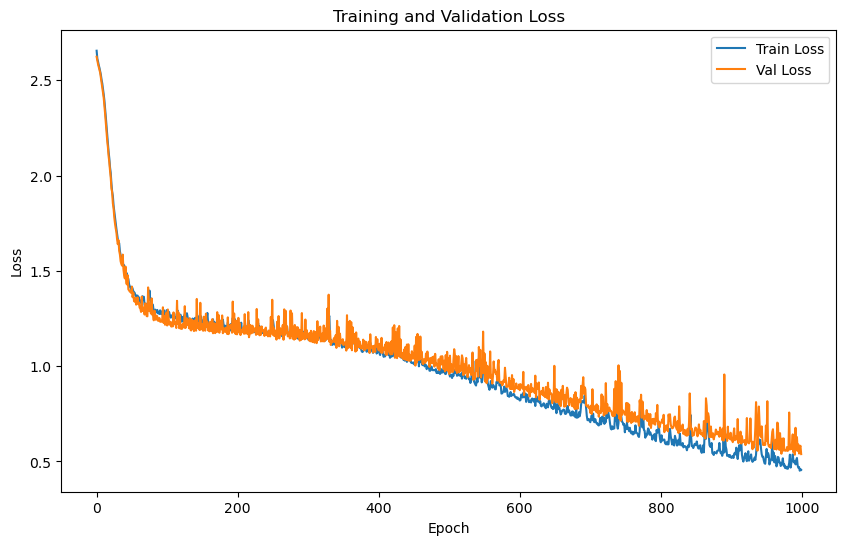

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6028 | Test Accuracy: 77.47%


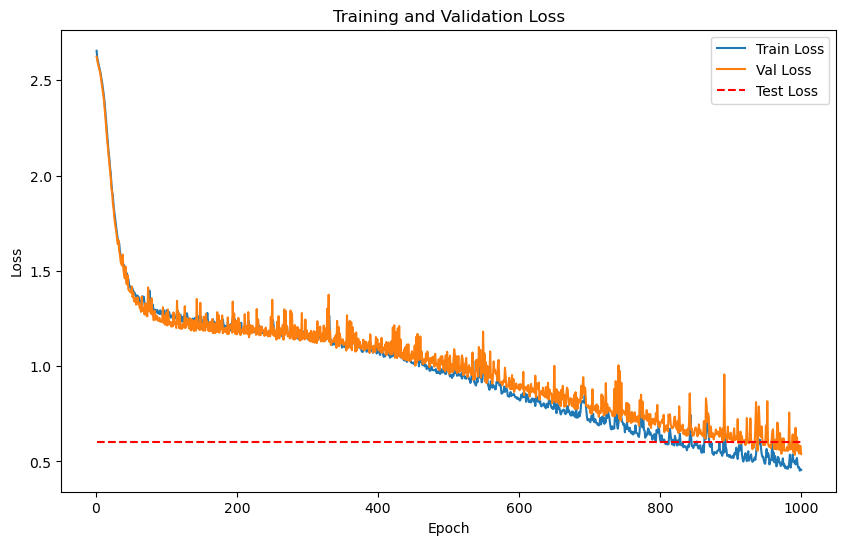

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.8041
Epoch [1/2000], Avg Train Loss: 8.8041
Epoch [1/2000], Avg Val Loss: 3.6670
Validation loss improved from inf to 3.6670. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4727
Epoch [2/2000], Avg Train Loss: 8.4727
Epoch [2/2000], Avg Val Loss: 3.6406
Validation loss improved from 3.6670 to 3.6406. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.6059
Epoch [3/2000], Avg Train Loss: 8.6059
Epoch [3/2000], Avg Val Loss: 3.6154
Validation loss improved from 3.6406 to 3.6154. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4681
Epoch [4/2000], Avg Train Loss: 8.4681
Epoch [4/2000], Avg Val Loss: 3.5912
Validation loss improved from 3.6154 to 3.5912. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.5452
Epoch [5/2000], Avg Train Loss: 8.5452
Epoch [5/2000], Avg Val Loss: 3.5681
Validation loss improved from 3.5912 to 3.5681. Saving mode

    Batch [1/1], Train Loss: 7.5725
Epoch [17/2000], Avg Train Loss: 7.5725
Epoch [17/2000], Avg Val Loss: 3.3581
Validation loss improved from 3.3715 to 3.3581. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.4198
Epoch [18/2000], Avg Train Loss: 7.4198
Epoch [18/2000], Avg Val Loss: 3.3454
Validation loss improved from 3.3581 to 3.3454. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.4632
Epoch [19/2000], Avg Train Loss: 7.4632
Epoch [19/2000], Avg Val Loss: 3.3332
Validation loss improved from 3.3454 to 3.3332. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.3500
Epoch [20/2000], Avg Train Loss: 7.3500
Epoch [20/2000], Avg Val Loss: 3.3217
Validation loss improved from 3.3332 to 3.3217. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.3121
Epoch [21/2000], Avg Train Loss: 7.3121
Epoch [21/2000], Avg Val Loss: 3.3107
Validation loss improved from 3.3217 to 3.

    Batch [1/1], Train Loss: 7.2023
Epoch [24/2000], Avg Train Loss: 7.2023
Epoch [24/2000], Avg Val Loss: 3.2809
Validation loss improved from 3.2903 to 3.2809. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.0897
Epoch [25/2000], Avg Train Loss: 7.0897
Epoch [25/2000], Avg Val Loss: 3.2718
Validation loss improved from 3.2809 to 3.2718. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.0285
Epoch [26/2000], Avg Train Loss: 7.0285
Epoch [26/2000], Avg Val Loss: 3.2632
Validation loss improved from 3.2718 to 3.2632. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.0867
Epoch [27/2000], Avg Train Loss: 7.0867
Epoch [27/2000], Avg Val Loss: 3.2550
Validation loss improved from 3.2632 to 3.2550. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.0050
Epoch [28/2000], Avg Train Loss: 7.0050
Epoch [28/2000], Avg Val Loss: 3.2472
Validation loss improved from 3.2550 to 3.

    Batch [1/1], Train Loss: 6.6129
Epoch [34/2000], Avg Train Loss: 6.6129
Epoch [34/2000], Avg Val Loss: 3.2093
Validation loss improved from 3.2147 to 3.2093. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.4794
Epoch [35/2000], Avg Train Loss: 6.4794
Epoch [35/2000], Avg Val Loss: 3.2041
Validation loss improved from 3.2093 to 3.2041. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.5389
Epoch [36/2000], Avg Train Loss: 6.5389
Epoch [36/2000], Avg Val Loss: 3.1992
Validation loss improved from 3.2041 to 3.1992. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.4839
Epoch [37/2000], Avg Train Loss: 6.4839
Epoch [37/2000], Avg Val Loss: 3.1946
Validation loss improved from 3.1992 to 3.1946. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.3672
Epoch [38/2000], Avg Train Loss: 6.3672
Epoch [38/2000], Avg Val Loss: 3.1903
Validation loss improved from 3.1946 to 3.

    Batch [1/1], Train Loss: 5.9372
Epoch [52/2000], Avg Train Loss: 5.9372
Epoch [52/2000], Avg Val Loss: 3.1529
Validation loss improved from 3.1545 to 3.1529. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.9383
Epoch [53/2000], Avg Train Loss: 5.9383
Epoch [53/2000], Avg Val Loss: 3.1515
Validation loss improved from 3.1529 to 3.1515. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.8350
Epoch [54/2000], Avg Train Loss: 5.8350
Epoch [54/2000], Avg Val Loss: 3.1502
Validation loss improved from 3.1515 to 3.1502. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.8366
Epoch [55/2000], Avg Train Loss: 5.8366
Epoch [55/2000], Avg Val Loss: 3.1489
Validation loss improved from 3.1502 to 3.1489. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.8244
Epoch [56/2000], Avg Train Loss: 5.8244
Epoch [56/2000], Avg Val Loss: 3.1478
Validation loss improved from 3.1489 to 3.

    Batch [1/1], Train Loss: 5.7126
Epoch [62/2000], Avg Train Loss: 5.7126
Epoch [62/2000], Avg Val Loss: 3.1424
Validation loss improved from 3.1432 to 3.1424. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.7157
Epoch [63/2000], Avg Train Loss: 5.7157
Epoch [63/2000], Avg Val Loss: 3.1416
Validation loss improved from 3.1424 to 3.1416. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.7624
Epoch [64/2000], Avg Train Loss: 5.7624
Epoch [64/2000], Avg Val Loss: 3.1409
Validation loss improved from 3.1416 to 3.1409. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.7740
Epoch [65/2000], Avg Train Loss: 5.7740
Epoch [65/2000], Avg Val Loss: 3.1402
Validation loss improved from 3.1409 to 3.1402. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.6906
Epoch [66/2000], Avg Train Loss: 5.6906
Epoch [66/2000], Avg Val Loss: 3.1396
Validation loss improved from 3.1402 to 3.

    Batch [1/1], Train Loss: 5.6010
Epoch [70/2000], Avg Train Loss: 5.6010
Epoch [70/2000], Avg Val Loss: 3.1376
Validation loss improved from 3.1381 to 3.1376. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.5556
Epoch [71/2000], Avg Train Loss: 5.5556
Epoch [71/2000], Avg Val Loss: 3.1372
Validation loss improved from 3.1376 to 3.1372. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.5280
Epoch [72/2000], Avg Train Loss: 5.5280
Epoch [72/2000], Avg Val Loss: 3.1368
Validation loss improved from 3.1372 to 3.1368. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.5874
Epoch [73/2000], Avg Train Loss: 5.5874
Epoch [73/2000], Avg Val Loss: 3.1364
Validation loss improved from 3.1368 to 3.1364. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.5254
Epoch [74/2000], Avg Train Loss: 5.5254
Epoch [74/2000], Avg Val Loss: 3.1361
Validation loss improved from 3.1364 to 3.

    Batch [1/1], Train Loss: 5.3085
Epoch [87/2000], Avg Train Loss: 5.3085
Epoch [87/2000], Avg Val Loss: 3.1321
Validation loss improved from 3.1324 to 3.1321. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.3413
Epoch [88/2000], Avg Train Loss: 5.3413
Epoch [88/2000], Avg Val Loss: 3.1318
Validation loss improved from 3.1321 to 3.1318. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.3241
Epoch [89/2000], Avg Train Loss: 5.3241
Epoch [89/2000], Avg Val Loss: 3.1315
Validation loss improved from 3.1318 to 3.1315. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2998
Epoch [90/2000], Avg Train Loss: 5.2998
Epoch [90/2000], Avg Val Loss: 3.1312
Validation loss improved from 3.1315 to 3.1312. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.3211
Epoch [91/2000], Avg Train Loss: 5.3211
Epoch [91/2000], Avg Val Loss: 3.1309
Validation loss improved from 3.1312 to 3.

Epoch [94/2000], Avg Val Loss: 3.1297
Validation loss improved from 3.1301 to 3.1297. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.3545
Epoch [95/2000], Avg Train Loss: 5.3545
Epoch [95/2000], Avg Val Loss: 3.1293
Validation loss improved from 3.1297 to 3.1293. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.2880
Epoch [96/2000], Avg Train Loss: 5.2880
Epoch [96/2000], Avg Val Loss: 3.1289
Validation loss improved from 3.1293 to 3.1289. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.3091
Epoch [97/2000], Avg Train Loss: 5.3091
Epoch [97/2000], Avg Val Loss: 3.1285
Validation loss improved from 3.1289 to 3.1285. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.2394
Epoch [98/2000], Avg Train Loss: 5.2394
Epoch [98/2000], Avg Val Loss: 3.1281
Validation loss improved from 3.1285 to 3.1281. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1623
Epoch [104/2000], Avg Train Loss: 5.1623
Epoch [104/2000], Avg Val Loss: 3.1257
Validation loss improved from 3.1261 to 3.1257. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.1773
Epoch [105/2000], Avg Train Loss: 5.1773
Epoch [105/2000], Avg Val Loss: 3.1252
Validation loss improved from 3.1257 to 3.1252. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.1700
Epoch [106/2000], Avg Train Loss: 5.1700
Epoch [106/2000], Avg Val Loss: 3.1248
Validation loss improved from 3.1252 to 3.1248. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.1858
Epoch [107/2000], Avg Train Loss: 5.1858
Epoch [107/2000], Avg Val Loss: 3.1243
Validation loss improved from 3.1248 to 3.1243. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.1979
Epoch [108/2000], Avg Train Loss: 5.1979
Epoch [108/2000], Avg Val Loss: 3.1238
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1222
Epoch [121/2000], Avg Train Loss: 5.1222
Epoch [121/2000], Avg Val Loss: 3.1174
Validation loss improved from 3.1179 to 3.1174. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 5.1135
Epoch [122/2000], Avg Train Loss: 5.1135
Epoch [122/2000], Avg Val Loss: 3.1168
Validation loss improved from 3.1174 to 3.1168. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.0963
Epoch [123/2000], Avg Train Loss: 5.0963
Epoch [123/2000], Avg Val Loss: 3.1162
Validation loss improved from 3.1168 to 3.1162. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.0737
Epoch [124/2000], Avg Train Loss: 5.0737
Epoch [124/2000], Avg Val Loss: 3.1156
Validation loss improved from 3.1162 to 3.1156. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.1199
Epoch [125/2000], Avg Train Loss: 5.1199
Epoch [125/2000], Avg Val Loss: 3.1150
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1281
Epoch [127/2000], Avg Train Loss: 5.1281
Epoch [127/2000], Avg Val Loss: 3.1138
Validation loss improved from 3.1143 to 3.1138. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.0595
Epoch [128/2000], Avg Train Loss: 5.0595
Epoch [128/2000], Avg Val Loss: 3.1131
Validation loss improved from 3.1138 to 3.1131. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.0464
Epoch [129/2000], Avg Train Loss: 5.0464
Epoch [129/2000], Avg Val Loss: 3.1125
Validation loss improved from 3.1131 to 3.1125. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.0745
Epoch [130/2000], Avg Train Loss: 5.0745
Epoch [130/2000], Avg Val Loss: 3.1118
Validation loss improved from 3.1125 to 3.1118. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.0455
Epoch [131/2000], Avg Train Loss: 5.0455
Epoch [131/2000], Avg Val Loss: 3.1111
Validation loss improved fro

Epoch [137/2000], Avg Val Loss: 3.1066
Validation loss improved from 3.1074 to 3.1066. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 5.0150
Epoch [138/2000], Avg Train Loss: 5.0150
Epoch [138/2000], Avg Val Loss: 3.1059
Validation loss improved from 3.1066 to 3.1059. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 5.0300
Epoch [139/2000], Avg Train Loss: 5.0300
Epoch [139/2000], Avg Val Loss: 3.1051
Validation loss improved from 3.1059 to 3.1051. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 5.0493
Epoch [140/2000], Avg Train Loss: 5.0493
Epoch [140/2000], Avg Val Loss: 3.1043
Validation loss improved from 3.1051 to 3.1043. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.9788
Epoch [141/2000], Avg Train Loss: 4.9788
Epoch [141/2000], Avg Val Loss: 3.1035
Validation loss improved from 3.1043 to 3.1035. Saving model...

LOG: Epoch [142/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9730
Epoch [155/2000], Avg Train Loss: 4.9730
Epoch [155/2000], Avg Val Loss: 3.0917
Validation loss improved from 3.0926 to 3.0917. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.9925
Epoch [156/2000], Avg Train Loss: 4.9925
Epoch [156/2000], Avg Val Loss: 3.0908
Validation loss improved from 3.0917 to 3.0908. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.9532
Epoch [157/2000], Avg Train Loss: 4.9532
Epoch [157/2000], Avg Val Loss: 3.0899
Validation loss improved from 3.0908 to 3.0899. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.9532
Epoch [158/2000], Avg Train Loss: 4.9532
Epoch [158/2000], Avg Val Loss: 3.0890
Validation loss improved from 3.0899 to 3.0890. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.9320
Epoch [159/2000], Avg Train Loss: 4.9320
Epoch [159/2000], Avg Val Loss: 3.0881
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9162
Epoch [160/2000], Avg Train Loss: 4.9162
Epoch [160/2000], Avg Val Loss: 3.0872
Validation loss improved from 3.0881 to 3.0872. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.9668
Epoch [161/2000], Avg Train Loss: 4.9668
Epoch [161/2000], Avg Val Loss: 3.0862
Validation loss improved from 3.0872 to 3.0862. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.9527
Epoch [162/2000], Avg Train Loss: 4.9527
Epoch [162/2000], Avg Val Loss: 3.0852
Validation loss improved from 3.0862 to 3.0852. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.9942
Epoch [163/2000], Avg Train Loss: 4.9942
Epoch [163/2000], Avg Val Loss: 3.0843
Validation loss improved from 3.0852 to 3.0843. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.9084
Epoch [164/2000], Avg Train Loss: 4.9084
Epoch [164/2000], Avg Val Loss: 3.0833
Validation loss improved fro

Epoch [171/2000], Avg Val Loss: 3.0765
Validation loss improved from 3.0775 to 3.0765. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.9333
Epoch [172/2000], Avg Train Loss: 4.9333
Epoch [172/2000], Avg Val Loss: 3.0755
Validation loss improved from 3.0765 to 3.0755. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.9294
Epoch [173/2000], Avg Train Loss: 4.9294
Epoch [173/2000], Avg Val Loss: 3.0746
Validation loss improved from 3.0755 to 3.0746. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.8934
Epoch [174/2000], Avg Train Loss: 4.8934
Epoch [174/2000], Avg Val Loss: 3.0736
Validation loss improved from 3.0746 to 3.0736. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.9409
Epoch [175/2000], Avg Train Loss: 4.9409
Epoch [175/2000], Avg Val Loss: 3.0726
Validation loss improved from 3.0736 to 3.0726. Saving model...

LOG: Epoch [176/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8823
Epoch [193/2000], Avg Train Loss: 4.8823
Epoch [193/2000], Avg Val Loss: 3.0551
Validation loss improved from 3.0561 to 3.0551. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.8527
Epoch [194/2000], Avg Train Loss: 4.8527
Epoch [194/2000], Avg Val Loss: 3.0540
Validation loss improved from 3.0551 to 3.0540. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.8429
Epoch [195/2000], Avg Train Loss: 4.8429
Epoch [195/2000], Avg Val Loss: 3.0529
Validation loss improved from 3.0540 to 3.0529. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.8357
Epoch [196/2000], Avg Train Loss: 4.8357
Epoch [196/2000], Avg Val Loss: 3.0518
Validation loss improved from 3.0529 to 3.0518. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.8068
Epoch [197/2000], Avg Train Loss: 4.8068
Epoch [197/2000], Avg Val Loss: 3.0508
Validation loss improved fro

Epoch [209/2000], Avg Val Loss: 3.0379
Validation loss improved from 3.0390 to 3.0379. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.7762
Epoch [210/2000], Avg Train Loss: 4.7762
Epoch [210/2000], Avg Val Loss: 3.0368
Validation loss improved from 3.0379 to 3.0368. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 4.7983
Epoch [211/2000], Avg Train Loss: 4.7983
Epoch [211/2000], Avg Val Loss: 3.0357
Validation loss improved from 3.0368 to 3.0357. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.8342
Epoch [212/2000], Avg Train Loss: 4.8342
Epoch [212/2000], Avg Val Loss: 3.0345
Validation loss improved from 3.0357 to 3.0345. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.8105
Epoch [213/2000], Avg Train Loss: 4.8105
Epoch [213/2000], Avg Val Loss: 3.0334
Validation loss improved from 3.0345 to 3.0334. Saving model...

LOG: Epoch [214/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7850
Epoch [229/2000], Avg Train Loss: 4.7850
Epoch [229/2000], Avg Val Loss: 3.0155
Validation loss improved from 3.0166 to 3.0155. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.7562
Epoch [230/2000], Avg Train Loss: 4.7562
Epoch [230/2000], Avg Val Loss: 3.0143
Validation loss improved from 3.0155 to 3.0143. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.7812
Epoch [231/2000], Avg Train Loss: 4.7812
Epoch [231/2000], Avg Val Loss: 3.0132
Validation loss improved from 3.0143 to 3.0132. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.7079
Epoch [232/2000], Avg Train Loss: 4.7079
Epoch [232/2000], Avg Val Loss: 3.0121
Validation loss improved from 3.0132 to 3.0121. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.7357
Epoch [233/2000], Avg Train Loss: 4.7357
Epoch [233/2000], Avg Val Loss: 3.0109
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7196
Epoch [242/2000], Avg Train Loss: 4.7196
Epoch [242/2000], Avg Val Loss: 3.0006
Validation loss improved from 3.0018 to 3.0006. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.7159
Epoch [243/2000], Avg Train Loss: 4.7159
Epoch [243/2000], Avg Val Loss: 2.9995
Validation loss improved from 3.0006 to 2.9995. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.6869
Epoch [244/2000], Avg Train Loss: 4.6869
Epoch [244/2000], Avg Val Loss: 2.9983
Validation loss improved from 2.9995 to 2.9983. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.7258
Epoch [245/2000], Avg Train Loss: 4.7258
Epoch [245/2000], Avg Val Loss: 2.9971
Validation loss improved from 2.9983 to 2.9971. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.7866
Epoch [246/2000], Avg Train Loss: 4.7866
Epoch [246/2000], Avg Val Loss: 2.9959
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6593
Epoch [265/2000], Avg Train Loss: 4.6593
Epoch [265/2000], Avg Val Loss: 2.9743
Validation loss improved from 2.9755 to 2.9743. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.6864
Epoch [266/2000], Avg Train Loss: 4.6864
Epoch [266/2000], Avg Val Loss: 2.9731
Validation loss improved from 2.9743 to 2.9731. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.6731
Epoch [267/2000], Avg Train Loss: 4.6731
Epoch [267/2000], Avg Val Loss: 2.9718
Validation loss improved from 2.9731 to 2.9718. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.6670
Epoch [268/2000], Avg Train Loss: 4.6670
Epoch [268/2000], Avg Val Loss: 2.9706
Validation loss improved from 2.9718 to 2.9706. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.6967
Epoch [269/2000], Avg Train Loss: 4.6967
Epoch [269/2000], Avg Val Loss: 2.9694
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6930
Epoch [278/2000], Avg Train Loss: 4.6930
Epoch [278/2000], Avg Val Loss: 2.9583
Validation loss improved from 2.9596 to 2.9583. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.6447
Epoch [279/2000], Avg Train Loss: 4.6447
Epoch [279/2000], Avg Val Loss: 2.9571
Validation loss improved from 2.9583 to 2.9571. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.6313
Epoch [280/2000], Avg Train Loss: 4.6313
Epoch [280/2000], Avg Val Loss: 2.9559
Validation loss improved from 2.9571 to 2.9559. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 4.6712
Epoch [281/2000], Avg Train Loss: 4.6712
Epoch [281/2000], Avg Val Loss: 2.9548
Validation loss improved from 2.9559 to 2.9548. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 4.6761
Epoch [282/2000], Avg Train Loss: 4.6761
Epoch [282/2000], Avg Val Loss: 2.9536
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5946
Epoch [300/2000], Avg Train Loss: 4.5946
Epoch [300/2000], Avg Val Loss: 2.9321
Validation loss improved from 2.9333 to 2.9321. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.5889
Epoch [301/2000], Avg Train Loss: 4.5889
Epoch [301/2000], Avg Val Loss: 2.9308
Validation loss improved from 2.9321 to 2.9308. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.6335
Epoch [302/2000], Avg Train Loss: 4.6335
Epoch [302/2000], Avg Val Loss: 2.9296
Validation loss improved from 2.9308 to 2.9296. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.5988
Epoch [303/2000], Avg Train Loss: 4.5988
Epoch [303/2000], Avg Val Loss: 2.9285
Validation loss improved from 2.9296 to 2.9285. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.6256
Epoch [304/2000], Avg Train Loss: 4.6256
Epoch [304/2000], Avg Val Loss: 2.9273
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5787
Epoch [312/2000], Avg Train Loss: 4.5787
Epoch [312/2000], Avg Val Loss: 2.9179
Validation loss improved from 2.9191 to 2.9179. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.5662
Epoch [313/2000], Avg Train Loss: 4.5662
Epoch [313/2000], Avg Val Loss: 2.9166
Validation loss improved from 2.9179 to 2.9166. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.5804
Epoch [314/2000], Avg Train Loss: 4.5804
Epoch [314/2000], Avg Val Loss: 2.9154
Validation loss improved from 2.9166 to 2.9154. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.5664
Epoch [315/2000], Avg Train Loss: 4.5664
Epoch [315/2000], Avg Val Loss: 2.9142
Validation loss improved from 2.9154 to 2.9142. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.5638
Epoch [316/2000], Avg Train Loss: 4.5638
Epoch [316/2000], Avg Val Loss: 2.9129
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5942
Epoch [337/2000], Avg Train Loss: 4.5942
Epoch [337/2000], Avg Val Loss: 2.8870
Validation loss improved from 2.8882 to 2.8870. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.5415
Epoch [338/2000], Avg Train Loss: 4.5415
Epoch [338/2000], Avg Val Loss: 2.8857
Validation loss improved from 2.8870 to 2.8857. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.5366
Epoch [339/2000], Avg Train Loss: 4.5366
Epoch [339/2000], Avg Val Loss: 2.8845
Validation loss improved from 2.8857 to 2.8845. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.5595
Epoch [340/2000], Avg Train Loss: 4.5595
Epoch [340/2000], Avg Val Loss: 2.8833
Validation loss improved from 2.8845 to 2.8833. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.5622
Epoch [341/2000], Avg Train Loss: 4.5622
Epoch [341/2000], Avg Val Loss: 2.8821
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5630
Epoch [346/2000], Avg Train Loss: 4.5630
Epoch [346/2000], Avg Val Loss: 2.8763
Validation loss improved from 2.8774 to 2.8763. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.5068
Epoch [347/2000], Avg Train Loss: 4.5068
Epoch [347/2000], Avg Val Loss: 2.8751
Validation loss improved from 2.8763 to 2.8751. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.5338
Epoch [348/2000], Avg Train Loss: 4.5338
Epoch [348/2000], Avg Val Loss: 2.8740
Validation loss improved from 2.8751 to 2.8740. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.5468
Epoch [349/2000], Avg Train Loss: 4.5468
Epoch [349/2000], Avg Val Loss: 2.8728
Validation loss improved from 2.8740 to 2.8728. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.5370
Epoch [350/2000], Avg Train Loss: 4.5370
Epoch [350/2000], Avg Val Loss: 2.8717
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4937
Epoch [372/2000], Avg Train Loss: 4.4937
Epoch [372/2000], Avg Val Loss: 2.8451
Validation loss improved from 2.8463 to 2.8451. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.4474
Epoch [373/2000], Avg Train Loss: 4.4474
Epoch [373/2000], Avg Val Loss: 2.8439
Validation loss improved from 2.8451 to 2.8439. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.4874
Epoch [374/2000], Avg Train Loss: 4.4874
Epoch [374/2000], Avg Val Loss: 2.8427
Validation loss improved from 2.8439 to 2.8427. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.4951
Epoch [375/2000], Avg Train Loss: 4.4951
Epoch [375/2000], Avg Val Loss: 2.8416
Validation loss improved from 2.8427 to 2.8416. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.4814
Epoch [376/2000], Avg Train Loss: 4.4814
Epoch [376/2000], Avg Val Loss: 2.8404
Validation loss improved fro

Epoch [381/2000], Avg Val Loss: 2.8345
Validation loss improved from 2.8357 to 2.8345. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.4858
Epoch [382/2000], Avg Train Loss: 4.4858
Epoch [382/2000], Avg Val Loss: 2.8333
Validation loss improved from 2.8345 to 2.8333. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.4742
Epoch [383/2000], Avg Train Loss: 4.4742
Epoch [383/2000], Avg Val Loss: 2.8322
Validation loss improved from 2.8333 to 2.8322. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.4720
Epoch [384/2000], Avg Train Loss: 4.4720
Epoch [384/2000], Avg Val Loss: 2.8310
Validation loss improved from 2.8322 to 2.8310. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.4679
Epoch [385/2000], Avg Train Loss: 4.4679
Epoch [385/2000], Avg Val Loss: 2.8298
Validation loss improved from 2.8310 to 2.8298. Saving model...

LOG: Epoch [386/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4161
Epoch [408/2000], Avg Train Loss: 4.4161
Epoch [408/2000], Avg Val Loss: 2.8029
Validation loss improved from 2.8041 to 2.8029. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.4216
Epoch [409/2000], Avg Train Loss: 4.4216
Epoch [409/2000], Avg Val Loss: 2.8017
Validation loss improved from 2.8029 to 2.8017. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.4594
Epoch [410/2000], Avg Train Loss: 4.4594
Epoch [410/2000], Avg Val Loss: 2.8005
Validation loss improved from 2.8017 to 2.8005. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.4386
Epoch [411/2000], Avg Train Loss: 4.4386
Epoch [411/2000], Avg Val Loss: 2.7992
Validation loss improved from 2.8005 to 2.7992. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.4494
Epoch [412/2000], Avg Train Loss: 4.4494
Epoch [412/2000], Avg Val Loss: 2.7980
Validation loss improved fro

Epoch [418/2000], Avg Train Loss: 4.4130
Epoch [418/2000], Avg Val Loss: 2.7910
Validation loss improved from 2.7922 to 2.7910. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.4147
Epoch [419/2000], Avg Train Loss: 4.4147
Epoch [419/2000], Avg Val Loss: 2.7898
Validation loss improved from 2.7910 to 2.7898. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.3880
Epoch [420/2000], Avg Train Loss: 4.3880
Epoch [420/2000], Avg Val Loss: 2.7886
Validation loss improved from 2.7898 to 2.7886. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.4039
Epoch [421/2000], Avg Train Loss: 4.4039
Epoch [421/2000], Avg Val Loss: 2.7874
Validation loss improved from 2.7886 to 2.7874. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.3874
Epoch [422/2000], Avg Train Loss: 4.3874
Epoch [422/2000], Avg Val Loss: 2.7862
Validation loss improved from 2.7874 to 2.7862. Saving model...


Epoch [440/2000], Avg Val Loss: 2.7654
Validation loss improved from 2.7665 to 2.7654. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.3484
Epoch [441/2000], Avg Train Loss: 4.3484
Epoch [441/2000], Avg Val Loss: 2.7643
Validation loss improved from 2.7654 to 2.7643. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.3475
Epoch [442/2000], Avg Train Loss: 4.3475
Epoch [442/2000], Avg Val Loss: 2.7632
Validation loss improved from 2.7643 to 2.7632. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.3552
Epoch [443/2000], Avg Train Loss: 4.3552
Epoch [443/2000], Avg Val Loss: 2.7621
Validation loss improved from 2.7632 to 2.7621. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.3932
Epoch [444/2000], Avg Train Loss: 4.3932
Epoch [444/2000], Avg Val Loss: 2.7610
Validation loss improved from 2.7621 to 2.7610. Saving model...

LOG: Epoch [445/2000] - Training
    Bat

Epoch [451/2000], Avg Val Loss: 2.7531
Validation loss improved from 2.7543 to 2.7531. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.3738
Epoch [452/2000], Avg Train Loss: 4.3738
Epoch [452/2000], Avg Val Loss: 2.7520
Validation loss improved from 2.7531 to 2.7520. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.3627
Epoch [453/2000], Avg Train Loss: 4.3627
Epoch [453/2000], Avg Val Loss: 2.7509
Validation loss improved from 2.7520 to 2.7509. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.3289
Epoch [454/2000], Avg Train Loss: 4.3289
Epoch [454/2000], Avg Val Loss: 2.7497
Validation loss improved from 2.7509 to 2.7497. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.3310
Epoch [455/2000], Avg Train Loss: 4.3310
Epoch [455/2000], Avg Val Loss: 2.7486
Validation loss improved from 2.7497 to 2.7486. Saving model...

LOG: Epoch [456/2000] - Training
    Bat

Epoch [475/2000], Avg Val Loss: 2.7278
Validation loss improved from 2.7288 to 2.7278. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.3239
Epoch [476/2000], Avg Train Loss: 4.3239
Epoch [476/2000], Avg Val Loss: 2.7269
Validation loss improved from 2.7278 to 2.7269. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.3466
Epoch [477/2000], Avg Train Loss: 4.3466
Epoch [477/2000], Avg Val Loss: 2.7258
Validation loss improved from 2.7269 to 2.7258. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.3086
Epoch [478/2000], Avg Train Loss: 4.3086
Epoch [478/2000], Avg Val Loss: 2.7248
Validation loss improved from 2.7258 to 2.7248. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.3226
Epoch [479/2000], Avg Train Loss: 4.3226
Epoch [479/2000], Avg Val Loss: 2.7237
Validation loss improved from 2.7248 to 2.7237. Saving model...

LOG: Epoch [480/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2944
Epoch [488/2000], Avg Train Loss: 4.2944
Epoch [488/2000], Avg Val Loss: 2.7139
Validation loss improved from 2.7150 to 2.7139. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.3112
Epoch [489/2000], Avg Train Loss: 4.3112
Epoch [489/2000], Avg Val Loss: 2.7127
Validation loss improved from 2.7139 to 2.7127. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.3320
Epoch [490/2000], Avg Train Loss: 4.3320
Epoch [490/2000], Avg Val Loss: 2.7116
Validation loss improved from 2.7127 to 2.7116. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.3283
Epoch [491/2000], Avg Train Loss: 4.3283
Epoch [491/2000], Avg Val Loss: 2.7105
Validation loss improved from 2.7116 to 2.7105. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.3356
Epoch [492/2000], Avg Train Loss: 4.3356
Epoch [492/2000], Avg Val Loss: 2.7094
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2852
Epoch [512/2000], Avg Train Loss: 4.2852
Epoch [512/2000], Avg Val Loss: 2.6882
Validation loss improved from 2.6892 to 2.6882. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.2662
Epoch [513/2000], Avg Train Loss: 4.2662
Epoch [513/2000], Avg Val Loss: 2.6872
Validation loss improved from 2.6882 to 2.6872. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.2659
Epoch [514/2000], Avg Train Loss: 4.2659
Epoch [514/2000], Avg Val Loss: 2.6862
Validation loss improved from 2.6872 to 2.6862. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.3193
Epoch [515/2000], Avg Train Loss: 4.3193
Epoch [515/2000], Avg Val Loss: 2.6852
Validation loss improved from 2.6862 to 2.6852. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.2468
Epoch [516/2000], Avg Train Loss: 4.2468
Epoch [516/2000], Avg Val Loss: 2.6842
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2539
Epoch [524/2000], Avg Train Loss: 4.2539
Epoch [524/2000], Avg Val Loss: 2.6759
Validation loss improved from 2.6770 to 2.6759. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.2881
Epoch [525/2000], Avg Train Loss: 4.2881
Epoch [525/2000], Avg Val Loss: 2.6749
Validation loss improved from 2.6759 to 2.6749. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.2504
Epoch [526/2000], Avg Train Loss: 4.2504
Epoch [526/2000], Avg Val Loss: 2.6739
Validation loss improved from 2.6749 to 2.6739. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.2898
Epoch [527/2000], Avg Train Loss: 4.2898
Epoch [527/2000], Avg Val Loss: 2.6730
Validation loss improved from 2.6739 to 2.6730. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.2802
Epoch [528/2000], Avg Train Loss: 4.2802
Epoch [528/2000], Avg Val Loss: 2.6720
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2225
Epoch [545/2000], Avg Train Loss: 4.2225
Epoch [545/2000], Avg Val Loss: 2.6556
Validation loss improved from 2.6565 to 2.6556. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.2046
Epoch [546/2000], Avg Train Loss: 4.2046
Epoch [546/2000], Avg Val Loss: 2.6547
Validation loss improved from 2.6556 to 2.6547. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.2405
Epoch [547/2000], Avg Train Loss: 4.2405
Epoch [547/2000], Avg Val Loss: 2.6537
Validation loss improved from 2.6547 to 2.6537. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.2472
Epoch [548/2000], Avg Train Loss: 4.2472
Epoch [548/2000], Avg Val Loss: 2.6529
Validation loss improved from 2.6537 to 2.6529. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.2354
Epoch [549/2000], Avg Train Loss: 4.2354
Epoch [549/2000], Avg Val Loss: 2.6520
Validation loss improved fro

Epoch [558/2000], Avg Val Loss: 2.6435
Validation loss improved from 2.6445 to 2.6435. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.1740
Epoch [559/2000], Avg Train Loss: 4.1740
Epoch [559/2000], Avg Val Loss: 2.6426
Validation loss improved from 2.6435 to 2.6426. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.2178
Epoch [560/2000], Avg Train Loss: 4.2178
Epoch [560/2000], Avg Val Loss: 2.6416
Validation loss improved from 2.6426 to 2.6416. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.2416
Epoch [561/2000], Avg Train Loss: 4.2416
Epoch [561/2000], Avg Val Loss: 2.6407
Validation loss improved from 2.6416 to 2.6407. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.2031
Epoch [562/2000], Avg Train Loss: 4.2031
Epoch [562/2000], Avg Val Loss: 2.6398
Validation loss improved from 2.6407 to 2.6398. Saving model...

LOG: Epoch [563/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1937
Epoch [583/2000], Avg Train Loss: 4.1937
Epoch [583/2000], Avg Val Loss: 2.6219
Validation loss improved from 2.6226 to 2.6219. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.1582
Epoch [584/2000], Avg Train Loss: 4.1582
Epoch [584/2000], Avg Val Loss: 2.6211
Validation loss improved from 2.6219 to 2.6211. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.1701
Epoch [585/2000], Avg Train Loss: 4.1701
Epoch [585/2000], Avg Val Loss: 2.6204
Validation loss improved from 2.6211 to 2.6204. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.2180
Epoch [586/2000], Avg Train Loss: 4.2180
Epoch [586/2000], Avg Val Loss: 2.6196
Validation loss improved from 2.6204 to 2.6196. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.1456
Epoch [587/2000], Avg Train Loss: 4.1456
Epoch [587/2000], Avg Val Loss: 2.6189
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1720
Epoch [595/2000], Avg Train Loss: 4.1720
Epoch [595/2000], Avg Val Loss: 2.6128
Validation loss improved from 2.6136 to 2.6128. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.1944
Epoch [596/2000], Avg Train Loss: 4.1944
Epoch [596/2000], Avg Val Loss: 2.6121
Validation loss improved from 2.6128 to 2.6121. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.1371
Epoch [597/2000], Avg Train Loss: 4.1371
Epoch [597/2000], Avg Val Loss: 2.6113
Validation loss improved from 2.6121 to 2.6113. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.1485
Epoch [598/2000], Avg Train Loss: 4.1485
Epoch [598/2000], Avg Val Loss: 2.6105
Validation loss improved from 2.6113 to 2.6105. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.2147
Epoch [599/2000], Avg Train Loss: 4.2147
Epoch [599/2000], Avg Val Loss: 2.6098
Validation loss improved fro

Epoch [618/2000], Avg Val Loss: 2.5967
Validation loss improved from 2.5974 to 2.5967. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.1400
Epoch [619/2000], Avg Train Loss: 4.1400
Epoch [619/2000], Avg Val Loss: 2.5959
Validation loss improved from 2.5967 to 2.5959. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.2001
Epoch [620/2000], Avg Train Loss: 4.2001
Epoch [620/2000], Avg Val Loss: 2.5952
Validation loss improved from 2.5959 to 2.5952. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.1616
Epoch [621/2000], Avg Train Loss: 4.1616
Epoch [621/2000], Avg Val Loss: 2.5944
Validation loss improved from 2.5952 to 2.5944. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 4.1961
Epoch [622/2000], Avg Train Loss: 4.1961
Epoch [622/2000], Avg Val Loss: 2.5936
Validation loss improved from 2.5944 to 2.5936. Saving model...

LOG: Epoch [623/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1477
Epoch [631/2000], Avg Train Loss: 4.1477
Epoch [631/2000], Avg Val Loss: 2.5869
Validation loss improved from 2.5875 to 2.5869. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.1453
Epoch [632/2000], Avg Train Loss: 4.1453
Epoch [632/2000], Avg Val Loss: 2.5862
Validation loss improved from 2.5869 to 2.5862. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.1513
Epoch [633/2000], Avg Train Loss: 4.1513
Epoch [633/2000], Avg Val Loss: 2.5856
Validation loss improved from 2.5862 to 2.5856. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.1256
Epoch [634/2000], Avg Train Loss: 4.1256
Epoch [634/2000], Avg Val Loss: 2.5850
Validation loss improved from 2.5856 to 2.5850. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.1630
Epoch [635/2000], Avg Train Loss: 4.1630
Epoch [635/2000], Avg Val Loss: 2.5844
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0763
Epoch [655/2000], Avg Train Loss: 4.0763
Epoch [655/2000], Avg Val Loss: 2.5713
Validation loss improved from 2.5720 to 2.5713. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.0883
Epoch [656/2000], Avg Train Loss: 4.0883
Epoch [656/2000], Avg Val Loss: 2.5707
Validation loss improved from 2.5713 to 2.5707. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.1217
Epoch [657/2000], Avg Train Loss: 4.1217
Epoch [657/2000], Avg Val Loss: 2.5700
Validation loss improved from 2.5707 to 2.5700. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.1520
Epoch [658/2000], Avg Train Loss: 4.1520
Epoch [658/2000], Avg Val Loss: 2.5694
Validation loss improved from 2.5700 to 2.5694. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.1060
Epoch [659/2000], Avg Train Loss: 4.1060
Epoch [659/2000], Avg Val Loss: 2.5687
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1022
Epoch [666/2000], Avg Train Loss: 4.1022
Epoch [666/2000], Avg Val Loss: 2.5640
Validation loss improved from 2.5647 to 2.5640. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 4.1058
Epoch [667/2000], Avg Train Loss: 4.1058
Epoch [667/2000], Avg Val Loss: 2.5632
Validation loss improved from 2.5640 to 2.5632. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 4.1066
Epoch [668/2000], Avg Train Loss: 4.1066
Epoch [668/2000], Avg Val Loss: 2.5624
Validation loss improved from 2.5632 to 2.5624. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 4.1399
Epoch [669/2000], Avg Train Loss: 4.1399
Epoch [669/2000], Avg Val Loss: 2.5617
Validation loss improved from 2.5624 to 2.5617. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.0913
Epoch [670/2000], Avg Train Loss: 4.0913
Epoch [670/2000], Avg Val Loss: 2.5609
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1052
Epoch [693/2000], Avg Train Loss: 4.1052
Epoch [693/2000], Avg Val Loss: 2.5484
Validation loss improved from 2.5491 to 2.5484. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.0442
Epoch [694/2000], Avg Train Loss: 4.0442
Epoch [694/2000], Avg Val Loss: 2.5477
Validation loss improved from 2.5484 to 2.5477. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 4.0522
Epoch [695/2000], Avg Train Loss: 4.0522
Epoch [695/2000], Avg Val Loss: 2.5471
Validation loss improved from 2.5477 to 2.5471. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.0772
Epoch [696/2000], Avg Train Loss: 4.0772
Epoch [696/2000], Avg Val Loss: 2.5465
Validation loss improved from 2.5471 to 2.5465. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.0515
Epoch [697/2000], Avg Train Loss: 4.0515
Epoch [697/2000], Avg Val Loss: 2.5459
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0926
Epoch [703/2000], Avg Train Loss: 4.0926
Epoch [703/2000], Avg Val Loss: 2.5430
Validation loss improved from 2.5434 to 2.5430. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.0502
Epoch [704/2000], Avg Train Loss: 4.0502
Epoch [704/2000], Avg Val Loss: 2.5425
Validation loss improved from 2.5430 to 2.5425. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.0265
Epoch [705/2000], Avg Train Loss: 4.0265
Epoch [705/2000], Avg Val Loss: 2.5421
Validation loss improved from 2.5425 to 2.5421. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.0217
Epoch [706/2000], Avg Train Loss: 4.0217
Epoch [706/2000], Avg Val Loss: 2.5416
Validation loss improved from 2.5421 to 2.5416. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.0506
Epoch [707/2000], Avg Train Loss: 4.0506
Epoch [707/2000], Avg Val Loss: 2.5412
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0379
Epoch [731/2000], Avg Train Loss: 4.0379
Epoch [731/2000], Avg Val Loss: 2.5274
Validation loss improved from 2.5279 to 2.5274. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.0523
Epoch [732/2000], Avg Train Loss: 4.0523
Epoch [732/2000], Avg Val Loss: 2.5269
Validation loss improved from 2.5274 to 2.5269. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.0681
Epoch [733/2000], Avg Train Loss: 4.0681
Epoch [733/2000], Avg Val Loss: 2.5263
Validation loss improved from 2.5269 to 2.5263. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.0011
Epoch [734/2000], Avg Train Loss: 4.0011
Epoch [734/2000], Avg Val Loss: 2.5258
Validation loss improved from 2.5263 to 2.5258. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 4.0184
Epoch [735/2000], Avg Train Loss: 4.0184
Epoch [735/2000], Avg Val Loss: 2.5253
Validation loss improved fro

Epoch [739/2000], Avg Val Loss: 2.5232
Validation loss improved from 2.5237 to 2.5232. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.0206
Epoch [740/2000], Avg Train Loss: 4.0206
Epoch [740/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5232 to 2.5228. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.0229
Epoch [741/2000], Avg Train Loss: 4.0229
Epoch [741/2000], Avg Val Loss: 2.5223
Validation loss improved from 2.5228 to 2.5223. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.0054
Epoch [742/2000], Avg Train Loss: 4.0054
Epoch [742/2000], Avg Val Loss: 2.5218
Validation loss improved from 2.5223 to 2.5218. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.0451
Epoch [743/2000], Avg Train Loss: 4.0451
Epoch [743/2000], Avg Val Loss: 2.5213
Validation loss improved from 2.5218 to 2.5213. Saving model...

LOG: Epoch [744/2000] - Training
    Bat

Epoch [768/2000], Avg Val Loss: 2.5092
Validation loss improved from 2.5096 to 2.5092. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.9897
Epoch [769/2000], Avg Train Loss: 3.9897
Epoch [769/2000], Avg Val Loss: 2.5087
Validation loss improved from 2.5092 to 2.5087. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.0124
Epoch [770/2000], Avg Train Loss: 4.0124
Epoch [770/2000], Avg Val Loss: 2.5083
Validation loss improved from 2.5087 to 2.5083. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.9766
Epoch [771/2000], Avg Train Loss: 3.9766
Epoch [771/2000], Avg Val Loss: 2.5078
Validation loss improved from 2.5083 to 2.5078. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 4.0133
Epoch [772/2000], Avg Train Loss: 4.0133
Epoch [772/2000], Avg Val Loss: 2.5074
Validation loss improved from 2.5078 to 2.5074. Saving model...

LOG: Epoch [773/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0140
Epoch [776/2000], Avg Train Loss: 4.0140
Epoch [776/2000], Avg Val Loss: 2.5052
Validation loss improved from 2.5058 to 2.5052. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 4.0208
Epoch [777/2000], Avg Train Loss: 4.0208
Epoch [777/2000], Avg Val Loss: 2.5046
Validation loss improved from 2.5052 to 2.5046. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.9628
Epoch [778/2000], Avg Train Loss: 3.9628
Epoch [778/2000], Avg Val Loss: 2.5039
Validation loss improved from 2.5046 to 2.5039. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.9786
Epoch [779/2000], Avg Train Loss: 3.9786
Epoch [779/2000], Avg Val Loss: 2.5033
Validation loss improved from 2.5039 to 2.5033. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.9986
Epoch [780/2000], Avg Train Loss: 3.9986
Epoch [780/2000], Avg Val Loss: 2.5026
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9690
Epoch [803/2000], Avg Train Loss: 3.9690
Epoch [803/2000], Avg Val Loss: 2.4910
Validation loss improved from 2.4914 to 2.4910. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.9968
Epoch [804/2000], Avg Train Loss: 3.9968
Epoch [804/2000], Avg Val Loss: 2.4906
Validation loss improved from 2.4910 to 2.4906. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.9792
Epoch [805/2000], Avg Train Loss: 3.9792
Epoch [805/2000], Avg Val Loss: 2.4903
Validation loss improved from 2.4906 to 2.4903. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.9848
Epoch [806/2000], Avg Train Loss: 3.9848
Epoch [806/2000], Avg Val Loss: 2.4899
Validation loss improved from 2.4903 to 2.4899. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.9351
Epoch [807/2000], Avg Train Loss: 3.9351
Epoch [807/2000], Avg Val Loss: 2.4896
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0229
Epoch [811/2000], Avg Train Loss: 4.0229
Epoch [811/2000], Avg Val Loss: 2.4884
Validation loss improved from 2.4887 to 2.4884. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.9610
Epoch [812/2000], Avg Train Loss: 3.9610
Epoch [812/2000], Avg Val Loss: 2.4882
Validation loss improved from 2.4884 to 2.4882. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.9273
Epoch [813/2000], Avg Train Loss: 3.9273
Epoch [813/2000], Avg Val Loss: 2.4880
Validation loss improved from 2.4882 to 2.4880. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.9482
Epoch [814/2000], Avg Train Loss: 3.9482
Epoch [814/2000], Avg Val Loss: 2.4877
Validation loss improved from 2.4880 to 2.4877. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.9679
Epoch [815/2000], Avg Train Loss: 3.9679
Epoch [815/2000], Avg Val Loss: 2.4873
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9174
Epoch [841/2000], Avg Train Loss: 3.9174
Epoch [841/2000], Avg Val Loss: 2.4785
Validation loss improved from 2.4789 to 2.4785. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.9242
Epoch [842/2000], Avg Train Loss: 3.9242
Epoch [842/2000], Avg Val Loss: 2.4781
Validation loss improved from 2.4785 to 2.4781. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.9197
Epoch [843/2000], Avg Train Loss: 3.9197
Epoch [843/2000], Avg Val Loss: 2.4777
Validation loss improved from 2.4781 to 2.4777. Saving model...

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.9274
Epoch [844/2000], Avg Train Loss: 3.9274
Epoch [844/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4777 to 2.4774. Saving model...

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 3.9128
Epoch [845/2000], Avg Train Loss: 3.9128
Epoch [845/2000], Avg Val Loss: 2.4770
Validation loss improved fro

Epoch [846/2000], Avg Val Loss: 2.4767
Validation loss improved from 2.4770 to 2.4767. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.9374
Epoch [847/2000], Avg Train Loss: 3.9374
Epoch [847/2000], Avg Val Loss: 2.4764
Validation loss improved from 2.4767 to 2.4764. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.9314
Epoch [848/2000], Avg Train Loss: 3.9314
Epoch [848/2000], Avg Val Loss: 2.4759
Validation loss improved from 2.4764 to 2.4759. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.9130
Epoch [849/2000], Avg Train Loss: 3.9130
Epoch [849/2000], Avg Val Loss: 2.4755
Validation loss improved from 2.4759 to 2.4755. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.9217
Epoch [850/2000], Avg Train Loss: 3.9217
Epoch [850/2000], Avg Val Loss: 2.4750
Validation loss improved from 2.4755 to 2.4750. Saving model...

LOG: Epoch [851/2000] - Training
    Bat

Epoch [878/2000], Avg Train Loss: 3.9484


Epoch [878/2000], Avg Val Loss: 2.4621
Validation loss improved from 2.4624 to 2.4621. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.9172
Epoch [879/2000], Avg Train Loss: 3.9172
Epoch [879/2000], Avg Val Loss: 2.4617
Validation loss improved from 2.4621 to 2.4617. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.8969
Epoch [880/2000], Avg Train Loss: 3.8969
Epoch [880/2000], Avg Val Loss: 2.4614
Validation loss improved from 2.4617 to 2.4614. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.8979
Epoch [881/2000], Avg Train Loss: 3.8979
Epoch [881/2000], Avg Val Loss: 2.4611
Validation loss improved from 2.4614 to 2.4611. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.9358
Epoch [882/2000], Avg Train Loss: 3.9358
Epoch [882/2000], Avg Val Loss: 2.4609
Validation loss improved from 2.4611 to 2.4609. Saving model...

LOG: Epoch [883/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8583
Epoch [913/2000], Avg Train Loss: 3.8583
Epoch [913/2000], Avg Val Loss: 2.4521
Validation loss improved from 2.4524 to 2.4521. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.9053
Epoch [914/2000], Avg Train Loss: 3.9053
Epoch [914/2000], Avg Val Loss: 2.4519
Validation loss improved from 2.4521 to 2.4519. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.8972
Epoch [915/2000], Avg Train Loss: 3.8972
Epoch [915/2000], Avg Val Loss: 2.4517
Validation loss improved from 2.4519 to 2.4517. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.8642
Epoch [916/2000], Avg Train Loss: 3.8642
Epoch [916/2000], Avg Val Loss: 2.4515
Validation loss improved from 2.4517 to 2.4515. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.8955
Epoch [917/2000], Avg Train Loss: 3.8955
Epoch [917/2000], Avg Val Loss: 2.4513
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8551
Epoch [947/2000], Avg Train Loss: 3.8551
Epoch [947/2000], Avg Val Loss: 2.4457
Validation loss improved from 2.4459 to 2.4457. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 3.8540
Epoch [948/2000], Avg Train Loss: 3.8540
Epoch [948/2000], Avg Val Loss: 2.4454
Validation loss improved from 2.4457 to 2.4454. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 3.8306
Epoch [949/2000], Avg Train Loss: 3.8306
Epoch [949/2000], Avg Val Loss: 2.4451
Validation loss improved from 2.4454 to 2.4451. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.8771
Epoch [950/2000], Avg Train Loss: 3.8771
Epoch [950/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4451 to 2.4449. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.8918
Epoch [951/2000], Avg Train Loss: 3.8918
Epoch [951/2000], Avg Val Loss: 2.4446
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8650
Epoch [982/2000], Avg Train Loss: 3.8650
Epoch [982/2000], Avg Val Loss: 2.4376
Validation loss improved from 2.4378 to 2.4376. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.8457
Epoch [983/2000], Avg Train Loss: 3.8457
Epoch [983/2000], Avg Val Loss: 2.4373
Validation loss improved from 2.4376 to 2.4373. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [984/2000], Avg Train Loss: 3.8294
Epoch [984/2000], Avg Val Loss: 2.4371
Validation loss improved from 2.4373 to 2.4371. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.8374
Epoch [985/2000], Avg Train Loss: 3.8374
Epoch [985/2000], Avg Val Loss: 2.4368
Validation loss improved from 2.4371 to 2.4368. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.8806
Epoch [986/2000], Avg Train Loss: 3.8806
Epoch [986/2000], Avg Val Loss: 2.4364
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8004
Epoch [1016/2000], Avg Train Loss: 3.8004
Epoch [1016/2000], Avg Val Loss: 2.4295
Validation loss improved from 2.4295 to 2.4295. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.8487
Epoch [1017/2000], Avg Train Loss: 3.8487
Epoch [1017/2000], Avg Val Loss: 2.4293
Validation loss improved from 2.4295 to 2.4293. Saving model...

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.7850
Epoch [1018/2000], Avg Train Loss: 3.7850
Epoch [1018/2000], Avg Val Loss: 2.4292
Validation loss improved from 2.4293 to 2.4292. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.7913
Epoch [1019/2000], Avg Train Loss: 3.7913
Epoch [1019/2000], Avg Val Loss: 2.4291
Validation loss improved from 2.4292 to 2.4291. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.8099
Epoch [1020/2000], Avg Train Loss: 3.8099
Epoch [1020/2000], Avg Val Loss: 2.4289
Validation los

Epoch [1053/2000], Avg Val Loss: 2.4215
Validation loss improved from 2.4215 to 2.4215. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.7900
Epoch [1054/2000], Avg Train Loss: 3.7900
Epoch [1054/2000], Avg Val Loss: 2.4215
Validation loss improved from 2.4215 to 2.4215. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 3.7917
Epoch [1055/2000], Avg Train Loss: 3.7917
Epoch [1055/2000], Avg Val Loss: 2.4215
Validation loss improved from 2.4215 to 2.4215. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.7952
Epoch [1056/2000], Avg Train Loss: 3.7952
Epoch [1056/2000], Avg Val Loss: 2.4216
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 3.7758
Epoch [1057/2000], Avg Train Loss: 3.7758
Epoch [1057/2000], Avg Val Loss: 2.4217
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.7494
Epoch [1074/2000], Avg Train Loss: 3.7494
Epoch [1074/2000], Avg Val Loss: 2.4212
Validation loss improved from 2.4214 to 2.4212. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.7326
Epoch [1075/2000], Avg Train Loss: 3.7326
Epoch [1075/2000], Avg Val Loss: 2.4211
Validation loss improved from 2.4212 to 2.4211. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 3.7449
Epoch [1076/2000], Avg Train Loss: 3.7449
Epoch [1076/2000], Avg Val Loss: 2.4209
Validation loss improved from 2.4211 to 2.4209. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.8058
Epoch [1077/2000], Avg Train Loss: 3.8058
Epoch [1077/2000], Avg Val Loss: 2.4207
Validation loss improved from 2.4209 to 2.4207. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.7317
Epoch [1078/2000], Avg Train Loss: 3.7317
Epoch [1078/2000], Avg Val Loss: 2.4204
Validation los

    Batch [1/1], Train Loss: 3.7386
Epoch [1111/2000], Avg Train Loss: 3.7386
Epoch [1111/2000], Avg Val Loss: 2.4165
Validation loss improved from 2.4166 to 2.4165. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 3.7855
Epoch [1112/2000], Avg Train Loss: 3.7855
Epoch [1112/2000], Avg Val Loss: 2.4165
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.7279
Epoch [1113/2000], Avg Train Loss: 3.7279
Epoch [1113/2000], Avg Val Loss: 2.4165
Validation loss improved from 2.4165 to 2.4165. Saving model...

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.7430
Epoch [1114/2000], Avg Train Loss: 3.7430
Epoch [1114/2000], Avg Val Loss: 2.4165
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.7431
Epoch [1115/2000], Avg Train Loss: 3.7431
Epoch [1115/2000], Avg Val Loss: 2.4165
Validation loss did not improve. Patience: 2

    Batch [1/1], Train Loss: 3.7417
Epoch [1148/2000], Avg Train Loss: 3.7417
Epoch [1148/2000], Avg Val Loss: 2.4116
Validation loss improved from 2.4117 to 2.4116. Saving model...

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 3.7549
Epoch [1149/2000], Avg Train Loss: 3.7549
Epoch [1149/2000], Avg Val Loss: 2.4116
Validation loss improved from 2.4116 to 2.4116. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 3.7740
Epoch [1150/2000], Avg Train Loss: 3.7740
Epoch [1150/2000], Avg Val Loss: 2.4115
Validation loss improved from 2.4116 to 2.4115. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.7171
Epoch [1151/2000], Avg Train Loss: 3.7171
Epoch [1151/2000], Avg Val Loss: 2.4114
Validation loss improved from 2.4115 to 2.4114. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.7618
Epoch [1152/2000], Avg Train Loss: 3.7618
Epoch [1152/2000], Avg Val Loss: 2.4113
Validation los

    Batch [1/1], Train Loss: 3.7554
Epoch [1185/2000], Avg Train Loss: 3.7554
Epoch [1185/2000], Avg Val Loss: 2.4094
Validation loss improved from 2.4096 to 2.4094. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 3.7511
Epoch [1186/2000], Avg Train Loss: 3.7511
Epoch [1186/2000], Avg Val Loss: 2.4092
Validation loss improved from 2.4094 to 2.4092. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 3.6969
Epoch [1187/2000], Avg Train Loss: 3.6969
Epoch [1187/2000], Avg Val Loss: 2.4090
Validation loss improved from 2.4092 to 2.4090. Saving model...

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 3.7000
Epoch [1188/2000], Avg Train Loss: 3.7000
Epoch [1188/2000], Avg Val Loss: 2.4088
Validation loss improved from 2.4090 to 2.4088. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 3.7245
Epoch [1189/2000], Avg Train Loss: 3.7245
Epoch [1189/2000], Avg Val Loss: 2.4086
Validation los

    Batch [1/1], Train Loss: 3.6934
Epoch [1223/2000], Avg Train Loss: 3.6934
Epoch [1223/2000], Avg Val Loss: 2.4056
Validation loss improved from 2.4057 to 2.4056. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.6885
Epoch [1224/2000], Avg Train Loss: 3.6885
Epoch [1224/2000], Avg Val Loss: 2.4056
Validation loss improved from 2.4056 to 2.4056. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 3.7156
Epoch [1225/2000], Avg Train Loss: 3.7156
Epoch [1225/2000], Avg Val Loss: 2.4056
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 3.6963
Epoch [1226/2000], Avg Train Loss: 3.6963
Epoch [1226/2000], Avg Val Loss: 2.4056
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.7022
Epoch [1227/2000], Avg Train Loss: 3.7022
Epoch [1227/2000], Avg Val Loss: 2.4057
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.7050
Epoch [1261/2000], Avg Train Loss: 3.7050
Epoch [1261/2000], Avg Val Loss: 2.4030
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.7078
Epoch [1262/2000], Avg Train Loss: 3.7078
Epoch [1262/2000], Avg Val Loss: 2.4031
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 3.6792
Epoch [1263/2000], Avg Train Loss: 3.6792
Epoch [1263/2000], Avg Val Loss: 2.4033
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 3.6602
Epoch [1264/2000], Avg Train Loss: 3.6602
Epoch [1264/2000], Avg Val Loss: 2.4034
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 3.6809
Epoch [1265/2000], Avg Train Loss: 3.6809
Epoch [1265/2000], Avg Val Loss: 2.4036
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1266/2000] -

    Batch [1/1], Train Loss: 3.6314
Epoch [1297/2000], Avg Train Loss: 3.6314
Epoch [1297/2000], Avg Val Loss: 2.4075
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 3.6528
Epoch [1298/2000], Avg Train Loss: 3.6528
Epoch [1298/2000], Avg Val Loss: 2.4074
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 3.6719
Epoch [1299/2000], Avg Train Loss: 3.6719
Epoch [1299/2000], Avg Val Loss: 2.4071
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 3.6608
Epoch [1300/2000], Avg Train Loss: 3.6608
Epoch [1300/2000], Avg Val Loss: 2.4070
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 3.6306
Epoch [1301/2000], Avg Train Loss: 3.6306
Epoch [1301/2000], Avg Val Loss: 2.4069
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1302/20

    Batch [1/1], Train Loss: 3.6785
Epoch [1331/2000], Avg Train Loss: 3.6785
Epoch [1331/2000], Avg Val Loss: 2.4037
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 3.6135
Epoch [1332/2000], Avg Train Loss: 3.6135
Epoch [1332/2000], Avg Val Loss: 2.4033
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 3.6247
Epoch [1333/2000], Avg Train Loss: 3.6247
Epoch [1333/2000], Avg Val Loss: 2.4030
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 3.6496
Epoch [1334/2000], Avg Train Loss: 3.6496
Epoch [1334/2000], Avg Val Loss: 2.4027
Validation loss improved from 2.4029 to 2.4027. Saving model...

LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 3.5953
Epoch [1335/2000], Avg Train Loss: 3.5953
Epoch [1335/2000], Avg Val Loss: 2.4024
Validation loss improved from 2.4027 to 2.4024. Saving m

    Batch [1/1], Train Loss: 3.6149
Epoch [1369/2000], Avg Train Loss: 3.6149
Epoch [1369/2000], Avg Val Loss: 2.4030
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 3.5757
Epoch [1370/2000], Avg Train Loss: 3.5757
Epoch [1370/2000], Avg Val Loss: 2.4029
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 3.6196
Epoch [1371/2000], Avg Train Loss: 3.6196
Epoch [1371/2000], Avg Val Loss: 2.4029
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 3.6072
Epoch [1372/2000], Avg Train Loss: 3.6072
Epoch [1372/2000], Avg Val Loss: 2.4030
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 3.6172
Epoch [1373/2000], Avg Train Loss: 3.6172
Epoch [1373/2000], Avg Val Loss: 2.4030
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1374/20

    Batch [1/1], Train Loss: 3.5951
Epoch [1403/2000], Avg Train Loss: 3.5951
Epoch [1403/2000], Avg Val Loss: 2.4087
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 3.6082
Epoch [1404/2000], Avg Train Loss: 3.6082
Epoch [1404/2000], Avg Val Loss: 2.4089
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 3.5710
Epoch [1405/2000], Avg Train Loss: 3.5710
Epoch [1405/2000], Avg Val Loss: 2.4090
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 3.6328
Epoch [1406/2000], Avg Train Loss: 3.6328
Epoch [1406/2000], Avg Val Loss: 2.4092
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 3.5691
Epoch [1407/2000], Avg Train Loss: 3.5691
Epoch [1407/2000], Avg Val Loss: 2.4093
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1408/20

    Batch [1/1], Train Loss: 3.5978
Epoch [1439/2000], Avg Train Loss: 3.5978
Epoch [1439/2000], Avg Val Loss: 2.4088
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 3.6170
Epoch [1440/2000], Avg Train Loss: 3.6170
Epoch [1440/2000], Avg Val Loss: 2.4087
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 3.5560
Epoch [1441/2000], Avg Train Loss: 3.5560
Epoch [1441/2000], Avg Val Loss: 2.4086
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1441. No improvement for 100 epochs.


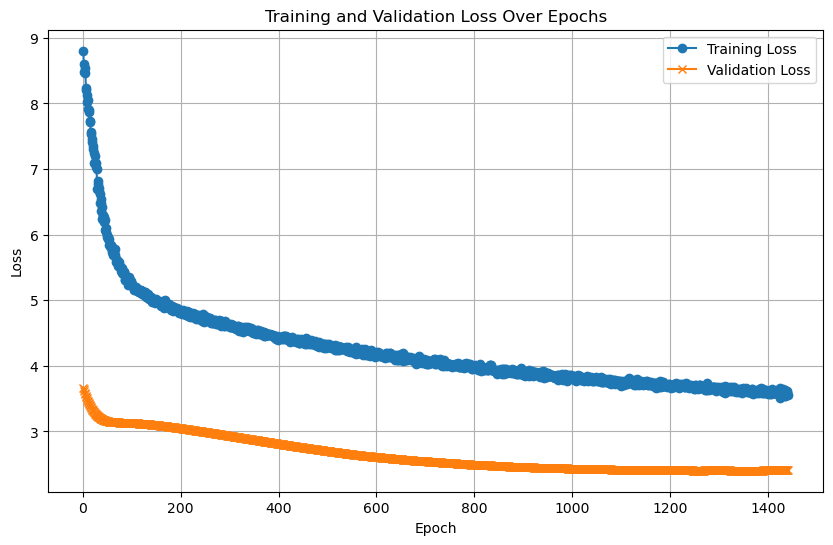

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.2886

Test Loss: 5.0979


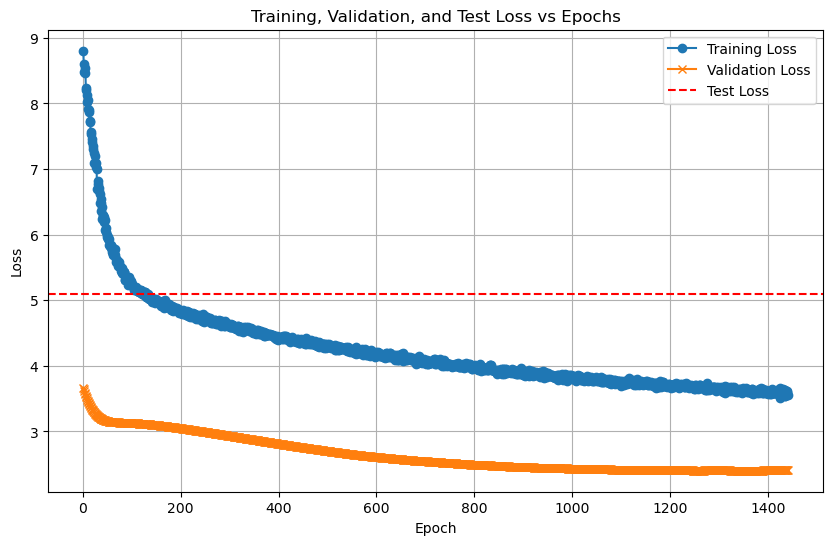

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       0.71      1.00      0.83         5
           4       1.00      1.00      1.00         5
           5       0.67      0.40      0.50         5
           6       0.80      0.80      0.80         5
           7       1.00      0.80      0.89         5
           8       0.75      0.60      0.67         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7046  |  Val Loss: 2.6633
Validation loss improved from inf to 2.6633.
[Epoch 2/1000] Train Loss: 2.6555  |  Val Loss: 2.6170
Validation loss improved from 2.6633 to 2.6170.
[Epoch 3/1000] Train Loss: 2.6077  |  Val Loss: 2.5751
Validation loss improved from 2.6170 to 2.5751.
[Epoch 4/1000] Train Loss: 2.5645  |  Val Loss: 2.5368
Validation loss improved from 2.5751 to 2.5368.
[Epoch 5/1000] Train Loss: 2.5256  |  Val Loss: 2.5029
Validation loss improved from 2.5368 to 2.5029.
[Epoch 6/1000] Train Loss: 2.4899  |  Val Loss: 2.4719
Validation loss improved from 2.5029 to 2.4719.
[Epoch 7/1000] Train Loss: 2.4572  |  Val Loss: 2.4408
Validation loss improved from 2.4719 to 2.4408.
[Epoch 8/1000] Train Loss: 2.4257  |  Val Loss: 2.4107
Validation loss improved from 2.4408 to 2.4107.
[Epoch 9/1000] Train Loss: 2.3955  |  Val Loss: 2.3819
Validation loss improved from 2.4107 to 2.3819.
[Epoch 10/1000] Train Loss: 2.3663  |  Val Loss: 2.3548
Validation loss impr

[Epoch 11/1000] Train Loss: 2.3390  |  Val Loss: 2.3295
Validation loss improved from 2.3548 to 2.3295.
[Epoch 12/1000] Train Loss: 2.3140  |  Val Loss: 2.3045
Validation loss improved from 2.3295 to 2.3045.
[Epoch 13/1000] Train Loss: 2.2887  |  Val Loss: 2.2808
Validation loss improved from 2.3045 to 2.2808.
[Epoch 14/1000] Train Loss: 2.2644  |  Val Loss: 2.2576
Validation loss improved from 2.2808 to 2.2576.
[Epoch 15/1000] Train Loss: 2.2405  |  Val Loss: 2.2348
Validation loss improved from 2.2576 to 2.2348.
[Epoch 16/1000] Train Loss: 2.2171  |  Val Loss: 2.2127
Validation loss improved from 2.2348 to 2.2127.
[Epoch 17/1000] Train Loss: 2.1941  |  Val Loss: 2.1912
Validation loss improved from 2.2127 to 2.1912.


[Epoch 18/1000] Train Loss: 2.1725  |  Val Loss: 2.1705
Validation loss improved from 2.1912 to 2.1705.
[Epoch 19/1000] Train Loss: 2.1499  |  Val Loss: 2.1506
Validation loss improved from 2.1705 to 2.1506.
[Epoch 20/1000] Train Loss: 2.1289  |  Val Loss: 2.1307
Validation loss improved from 2.1506 to 2.1307.
[Epoch 21/1000] Train Loss: 2.1080  |  Val Loss: 2.1120
Validation loss improved from 2.1307 to 2.1120.
[Epoch 22/1000] Train Loss: 2.0892  |  Val Loss: 2.0937
Validation loss improved from 2.1120 to 2.0937.
[Epoch 23/1000] Train Loss: 2.0687  |  Val Loss: 2.0766
Validation loss improved from 2.0937 to 2.0766.
[Epoch 24/1000] Train Loss: 2.0507  |  Val Loss: 2.0594
Validation loss improved from 2.0766 to 2.0594.
[Epoch 25/1000] Train Loss: 2.0325  |  Val Loss: 2.0430
Validation loss improved from 2.0594 to 2.0430.
[Epoch 26/1000] Train Loss: 2.0147  |  Val Loss: 2.0270
Validation loss improved from 2.0430 to 2.0270.
[Epoch 27/1000] Train Loss: 1.9976  |  Val Loss: 2.0112
Validati

[Epoch 30/1000] Train Loss: 1.9467  |  Val Loss: 1.9644
Validation loss improved from 1.9801 to 1.9644.
[Epoch 31/1000] Train Loss: 1.9298  |  Val Loss: 1.9486
Validation loss improved from 1.9644 to 1.9486.
[Epoch 32/1000] Train Loss: 1.9129  |  Val Loss: 1.9327
Validation loss improved from 1.9486 to 1.9327.
[Epoch 33/1000] Train Loss: 1.8956  |  Val Loss: 1.9170
Validation loss improved from 1.9327 to 1.9170.
[Epoch 34/1000] Train Loss: 1.8788  |  Val Loss: 1.9009
Validation loss improved from 1.9170 to 1.9009.
[Epoch 35/1000] Train Loss: 1.8615  |  Val Loss: 1.8849
Validation loss improved from 1.9009 to 1.8849.


[Epoch 36/1000] Train Loss: 1.8449  |  Val Loss: 1.8684
Validation loss improved from 1.8849 to 1.8684.
[Epoch 37/1000] Train Loss: 1.8274  |  Val Loss: 1.8523
Validation loss improved from 1.8684 to 1.8523.
[Epoch 38/1000] Train Loss: 1.8099  |  Val Loss: 1.8361
Validation loss improved from 1.8523 to 1.8361.
[Epoch 39/1000] Train Loss: 1.7930  |  Val Loss: 1.8198
Validation loss improved from 1.8361 to 1.8198.
[Epoch 40/1000] Train Loss: 1.7753  |  Val Loss: 1.8032
Validation loss improved from 1.8198 to 1.8032.
[Epoch 41/1000] Train Loss: 1.7577  |  Val Loss: 1.7863
Validation loss improved from 1.8032 to 1.7863.
[Epoch 42/1000] Train Loss: 1.7402  |  Val Loss: 1.7697
Validation loss improved from 1.7863 to 1.7697.
[Epoch 43/1000] Train Loss: 1.7223  |  Val Loss: 1.7534
Validation loss improved from 1.7697 to 1.7534.
[Epoch 44/1000] Train Loss: 1.7042  |  Val Loss: 1.7364
Validation loss improved from 1.7534 to 1.7364.
[Epoch 45/1000] Train Loss: 1.6867  |  Val Loss: 1.7193
Validati

[Epoch 48/1000] Train Loss: 1.6321  |  Val Loss: 1.6677
Validation loss improved from 1.6847 to 1.6677.
[Epoch 49/1000] Train Loss: 1.6133  |  Val Loss: 1.6508
Validation loss improved from 1.6677 to 1.6508.
[Epoch 50/1000] Train Loss: 1.5949  |  Val Loss: 1.6336
Validation loss improved from 1.6508 to 1.6336.
[Epoch 51/1000] Train Loss: 1.5767  |  Val Loss: 1.6161
Validation loss improved from 1.6336 to 1.6161.
[Epoch 52/1000] Train Loss: 1.5579  |  Val Loss: 1.5987
Validation loss improved from 1.6161 to 1.5987.
[Epoch 53/1000] Train Loss: 1.5390  |  Val Loss: 1.5811
Validation loss improved from 1.5987 to 1.5811.
[Epoch 54/1000] Train Loss: 1.5203  |  Val Loss: 1.5631
Validation loss improved from 1.5811 to 1.5631.


[Epoch 55/1000] Train Loss: 1.5014  |  Val Loss: 1.5451
Validation loss improved from 1.5631 to 1.5451.
[Epoch 56/1000] Train Loss: 1.4820  |  Val Loss: 1.5277
Validation loss improved from 1.5451 to 1.5277.
[Epoch 57/1000] Train Loss: 1.4637  |  Val Loss: 1.5098
Validation loss improved from 1.5277 to 1.5098.
[Epoch 58/1000] Train Loss: 1.4446  |  Val Loss: 1.4924
Validation loss improved from 1.5098 to 1.4924.
[Epoch 59/1000] Train Loss: 1.4261  |  Val Loss: 1.4749
Validation loss improved from 1.4924 to 1.4749.
[Epoch 60/1000] Train Loss: 1.4075  |  Val Loss: 1.4573
Validation loss improved from 1.4749 to 1.4573.
[Epoch 61/1000] Train Loss: 1.3889  |  Val Loss: 1.4397
Validation loss improved from 1.4573 to 1.4397.
[Epoch 62/1000] Train Loss: 1.3698  |  Val Loss: 1.4220
Validation loss improved from 1.4397 to 1.4220.
[Epoch 63/1000] Train Loss: 1.3504  |  Val Loss: 1.4042
Validation loss improved from 1.4220 to 1.4042.
[Epoch 64/1000] Train Loss: 1.3311  |  Val Loss: 1.3862
Validati

[Epoch 67/1000] Train Loss: 1.2738  |  Val Loss: 1.3349
Validation loss improved from 1.3515 to 1.3349.
[Epoch 68/1000] Train Loss: 1.2549  |  Val Loss: 1.3188
Validation loss improved from 1.3349 to 1.3188.
[Epoch 69/1000] Train Loss: 1.2374  |  Val Loss: 1.3025
Validation loss improved from 1.3188 to 1.3025.
[Epoch 70/1000] Train Loss: 1.2194  |  Val Loss: 1.2867
Validation loss improved from 1.3025 to 1.2867.
[Epoch 71/1000] Train Loss: 1.2017  |  Val Loss: 1.2709
Validation loss improved from 1.2867 to 1.2709.
[Epoch 72/1000] Train Loss: 1.1846  |  Val Loss: 1.2558
Validation loss improved from 1.2709 to 1.2558.
[Epoch 73/1000] Train Loss: 1.1679  |  Val Loss: 1.2402
Validation loss improved from 1.2558 to 1.2402.
[Epoch 74/1000] Train Loss: 1.1511  |  Val Loss: 1.2251
Validation loss improved from 1.2402 to 1.2251.


[Epoch 75/1000] Train Loss: 1.1346  |  Val Loss: 1.2099
Validation loss improved from 1.2251 to 1.2099.
[Epoch 76/1000] Train Loss: 1.1187  |  Val Loss: 1.1949
Validation loss improved from 1.2099 to 1.1949.
[Epoch 77/1000] Train Loss: 1.1024  |  Val Loss: 1.1805
Validation loss improved from 1.1949 to 1.1805.
[Epoch 78/1000] Train Loss: 1.0868  |  Val Loss: 1.1663
Validation loss improved from 1.1805 to 1.1663.
[Epoch 79/1000] Train Loss: 1.0709  |  Val Loss: 1.1521
Validation loss improved from 1.1663 to 1.1521.
[Epoch 80/1000] Train Loss: 1.0555  |  Val Loss: 1.1381
Validation loss improved from 1.1521 to 1.1381.
[Epoch 81/1000] Train Loss: 1.0404  |  Val Loss: 1.1244
Validation loss improved from 1.1381 to 1.1244.
[Epoch 82/1000] Train Loss: 1.0254  |  Val Loss: 1.1109
Validation loss improved from 1.1244 to 1.1109.
[Epoch 83/1000] Train Loss: 1.0103  |  Val Loss: 1.0978
Validation loss improved from 1.1109 to 1.0978.
[Epoch 84/1000] Train Loss: 0.9952  |  Val Loss: 1.0843
Validati

[Epoch 85/1000] Train Loss: 0.9800  |  Val Loss: 1.0712
Validation loss improved from 1.0843 to 1.0712.
[Epoch 86/1000] Train Loss: 0.9654  |  Val Loss: 1.0578
Validation loss improved from 1.0712 to 1.0578.
[Epoch 87/1000] Train Loss: 0.9504  |  Val Loss: 1.0446
Validation loss improved from 1.0578 to 1.0446.
[Epoch 88/1000] Train Loss: 0.9355  |  Val Loss: 1.0313
Validation loss improved from 1.0446 to 1.0313.
[Epoch 89/1000] Train Loss: 0.9219  |  Val Loss: 1.0185
Validation loss improved from 1.0313 to 1.0185.
[Epoch 90/1000] Train Loss: 0.9068  |  Val Loss: 1.0057
Validation loss improved from 1.0185 to 1.0057.
[Epoch 91/1000] Train Loss: 0.8925  |  Val Loss: 0.9930
Validation loss improved from 1.0057 to 0.9930.
[Epoch 92/1000] Train Loss: 0.8788  |  Val Loss: 0.9802
Validation loss improved from 0.9930 to 0.9802.
[Epoch 93/1000] Train Loss: 0.8653  |  Val Loss: 0.9679
Validation loss improved from 0.9802 to 0.9679.
[Epoch 94/1000] Train Loss: 0.8515  |  Val Loss: 0.9561
Validati

[Epoch 95/1000] Train Loss: 0.8379  |  Val Loss: 0.9444
Validation loss improved from 0.9561 to 0.9444.
[Epoch 96/1000] Train Loss: 0.8249  |  Val Loss: 0.9328
Validation loss improved from 0.9444 to 0.9328.
[Epoch 97/1000] Train Loss: 0.8116  |  Val Loss: 0.9215
Validation loss improved from 0.9328 to 0.9215.
[Epoch 98/1000] Train Loss: 0.7988  |  Val Loss: 0.9103
Validation loss improved from 0.9215 to 0.9103.
[Epoch 99/1000] Train Loss: 0.7866  |  Val Loss: 0.8998
Validation loss improved from 0.9103 to 0.8998.
[Epoch 100/1000] Train Loss: 0.7735  |  Val Loss: 0.8893
Validation loss improved from 0.8998 to 0.8893.
[Epoch 101/1000] Train Loss: 0.7613  |  Val Loss: 0.8787
Validation loss improved from 0.8893 to 0.8787.
[Epoch 102/1000] Train Loss: 0.7491  |  Val Loss: 0.8682
Validation loss improved from 0.8787 to 0.8682.


[Epoch 103/1000] Train Loss: 0.7365  |  Val Loss: 0.8578
Validation loss improved from 0.8682 to 0.8578.
[Epoch 104/1000] Train Loss: 0.7246  |  Val Loss: 0.8478
Validation loss improved from 0.8578 to 0.8478.
[Epoch 105/1000] Train Loss: 0.7128  |  Val Loss: 0.8378
Validation loss improved from 0.8478 to 0.8378.
[Epoch 106/1000] Train Loss: 0.7013  |  Val Loss: 0.8277
Validation loss improved from 0.8378 to 0.8277.
[Epoch 107/1000] Train Loss: 0.6901  |  Val Loss: 0.8181
Validation loss improved from 0.8277 to 0.8181.
[Epoch 108/1000] Train Loss: 0.6783  |  Val Loss: 0.8079
Validation loss improved from 0.8181 to 0.8079.
[Epoch 109/1000] Train Loss: 0.6671  |  Val Loss: 0.7980
Validation loss improved from 0.8079 to 0.7980.
[Epoch 110/1000] Train Loss: 0.6559  |  Val Loss: 0.7879
Validation loss improved from 0.7980 to 0.7879.
[Epoch 111/1000] Train Loss: 0.6453  |  Val Loss: 0.7784
Validation loss improved from 0.7879 to 0.7784.
[Epoch 112/1000] Train Loss: 0.6344  |  Val Loss: 0.769

[Epoch 115/1000] Train Loss: 0.6028  |  Val Loss: 0.7428
Validation loss improved from 0.7517 to 0.7428.
[Epoch 116/1000] Train Loss: 0.5926  |  Val Loss: 0.7347
Validation loss improved from 0.7428 to 0.7347.
[Epoch 117/1000] Train Loss: 0.5825  |  Val Loss: 0.7267
Validation loss improved from 0.7347 to 0.7267.
[Epoch 118/1000] Train Loss: 0.5724  |  Val Loss: 0.7195
Validation loss improved from 0.7267 to 0.7195.
[Epoch 119/1000] Train Loss: 0.5625  |  Val Loss: 0.7119
Validation loss improved from 0.7195 to 0.7119.
[Epoch 120/1000] Train Loss: 0.5532  |  Val Loss: 0.7041
Validation loss improved from 0.7119 to 0.7041.
[Epoch 121/1000] Train Loss: 0.5433  |  Val Loss: 0.6968
Validation loss improved from 0.7041 to 0.6968.


[Epoch 122/1000] Train Loss: 0.5337  |  Val Loss: 0.6894
Validation loss improved from 0.6968 to 0.6894.
[Epoch 123/1000] Train Loss: 0.5246  |  Val Loss: 0.6819
Validation loss improved from 0.6894 to 0.6819.
[Epoch 124/1000] Train Loss: 0.5155  |  Val Loss: 0.6748
Validation loss improved from 0.6819 to 0.6748.
[Epoch 125/1000] Train Loss: 0.5068  |  Val Loss: 0.6675
Validation loss improved from 0.6748 to 0.6675.
[Epoch 126/1000] Train Loss: 0.4979  |  Val Loss: 0.6608
Validation loss improved from 0.6675 to 0.6608.
[Epoch 127/1000] Train Loss: 0.4891  |  Val Loss: 0.6541
Validation loss improved from 0.6608 to 0.6541.
[Epoch 128/1000] Train Loss: 0.4806  |  Val Loss: 0.6478
Validation loss improved from 0.6541 to 0.6478.
[Epoch 129/1000] Train Loss: 0.4720  |  Val Loss: 0.6416
Validation loss improved from 0.6478 to 0.6416.
[Epoch 130/1000] Train Loss: 0.4636  |  Val Loss: 0.6355
Validation loss improved from 0.6416 to 0.6355.
[Epoch 131/1000] Train Loss: 0.4556  |  Val Loss: 0.629

[Epoch 134/1000] Train Loss: 0.4321  |  Val Loss: 0.6111
Validation loss improved from 0.6174 to 0.6111.
[Epoch 135/1000] Train Loss: 0.4245  |  Val Loss: 0.6049
Validation loss improved from 0.6111 to 0.6049.
[Epoch 136/1000] Train Loss: 0.4168  |  Val Loss: 0.5994
Validation loss improved from 0.6049 to 0.5994.
[Epoch 137/1000] Train Loss: 0.4097  |  Val Loss: 0.5940
Validation loss improved from 0.5994 to 0.5940.
[Epoch 138/1000] Train Loss: 0.4023  |  Val Loss: 0.5885
Validation loss improved from 0.5940 to 0.5885.
[Epoch 139/1000] Train Loss: 0.3955  |  Val Loss: 0.5836
Validation loss improved from 0.5885 to 0.5836.
[Epoch 140/1000] Train Loss: 0.3888  |  Val Loss: 0.5781
Validation loss improved from 0.5836 to 0.5781.


[Epoch 141/1000] Train Loss: 0.3820  |  Val Loss: 0.5730
Validation loss improved from 0.5781 to 0.5730.
[Epoch 142/1000] Train Loss: 0.3755  |  Val Loss: 0.5684
Validation loss improved from 0.5730 to 0.5684.
[Epoch 143/1000] Train Loss: 0.3689  |  Val Loss: 0.5637
Validation loss improved from 0.5684 to 0.5637.
[Epoch 144/1000] Train Loss: 0.3628  |  Val Loss: 0.5594
Validation loss improved from 0.5637 to 0.5594.
[Epoch 145/1000] Train Loss: 0.3567  |  Val Loss: 0.5552
Validation loss improved from 0.5594 to 0.5552.
[Epoch 146/1000] Train Loss: 0.3503  |  Val Loss: 0.5515
Validation loss improved from 0.5552 to 0.5515.
[Epoch 147/1000] Train Loss: 0.3444  |  Val Loss: 0.5473
Validation loss improved from 0.5515 to 0.5473.
[Epoch 148/1000] Train Loss: 0.3388  |  Val Loss: 0.5432
Validation loss improved from 0.5473 to 0.5432.
[Epoch 149/1000] Train Loss: 0.3330  |  Val Loss: 0.5390
Validation loss improved from 0.5432 to 0.5390.
[Epoch 150/1000] Train Loss: 0.3275  |  Val Loss: 0.535

[Epoch 153/1000] Train Loss: 0.3112  |  Val Loss: 0.5245
Validation loss improved from 0.5283 to 0.5245.
[Epoch 154/1000] Train Loss: 0.3061  |  Val Loss: 0.5210
Validation loss improved from 0.5245 to 0.5210.
[Epoch 155/1000] Train Loss: 0.3011  |  Val Loss: 0.5179
Validation loss improved from 0.5210 to 0.5179.
[Epoch 156/1000] Train Loss: 0.2967  |  Val Loss: 0.5147
Validation loss improved from 0.5179 to 0.5147.
[Epoch 157/1000] Train Loss: 0.2916  |  Val Loss: 0.5109
Validation loss improved from 0.5147 to 0.5109.
[Epoch 158/1000] Train Loss: 0.2869  |  Val Loss: 0.5070
Validation loss improved from 0.5109 to 0.5070.
[Epoch 159/1000] Train Loss: 0.2823  |  Val Loss: 0.5039
Validation loss improved from 0.5070 to 0.5039.


[Epoch 160/1000] Train Loss: 0.2777  |  Val Loss: 0.5009
Validation loss improved from 0.5039 to 0.5009.
[Epoch 161/1000] Train Loss: 0.2736  |  Val Loss: 0.4978
Validation loss improved from 0.5009 to 0.4978.
[Epoch 162/1000] Train Loss: 0.2691  |  Val Loss: 0.4955
Validation loss improved from 0.4978 to 0.4955.
[Epoch 163/1000] Train Loss: 0.2647  |  Val Loss: 0.4927
Validation loss improved from 0.4955 to 0.4927.
[Epoch 164/1000] Train Loss: 0.2605  |  Val Loss: 0.4903
Validation loss improved from 0.4927 to 0.4903.
[Epoch 165/1000] Train Loss: 0.2564  |  Val Loss: 0.4877
Validation loss improved from 0.4903 to 0.4877.
[Epoch 166/1000] Train Loss: 0.2525  |  Val Loss: 0.4854
Validation loss improved from 0.4877 to 0.4854.
[Epoch 167/1000] Train Loss: 0.2487  |  Val Loss: 0.4831
Validation loss improved from 0.4854 to 0.4831.
[Epoch 168/1000] Train Loss: 0.2449  |  Val Loss: 0.4809
Validation loss improved from 0.4831 to 0.4809.
[Epoch 169/1000] Train Loss: 0.2412  |  Val Loss: 0.478

[Epoch 172/1000] Train Loss: 0.2306  |  Val Loss: 0.4713
Validation loss improved from 0.4738 to 0.4713.
[Epoch 173/1000] Train Loss: 0.2270  |  Val Loss: 0.4695
Validation loss improved from 0.4713 to 0.4695.
[Epoch 174/1000] Train Loss: 0.2237  |  Val Loss: 0.4675
Validation loss improved from 0.4695 to 0.4675.
[Epoch 175/1000] Train Loss: 0.2205  |  Val Loss: 0.4652
Validation loss improved from 0.4675 to 0.4652.
[Epoch 176/1000] Train Loss: 0.2175  |  Val Loss: 0.4632
Validation loss improved from 0.4652 to 0.4632.
[Epoch 177/1000] Train Loss: 0.2146  |  Val Loss: 0.4620
Validation loss improved from 0.4632 to 0.4620.
[Epoch 178/1000] Train Loss: 0.2111  |  Val Loss: 0.4609
Validation loss improved from 0.4620 to 0.4609.
[Epoch 179/1000] Train Loss: 0.2079  |  Val Loss: 0.4600
Validation loss improved from 0.4609 to 0.4600.


[Epoch 180/1000] Train Loss: 0.2052  |  Val Loss: 0.4586
Validation loss improved from 0.4600 to 0.4586.
[Epoch 181/1000] Train Loss: 0.2023  |  Val Loss: 0.4567
Validation loss improved from 0.4586 to 0.4567.
[Epoch 182/1000] Train Loss: 0.1991  |  Val Loss: 0.4556
Validation loss improved from 0.4567 to 0.4556.
[Epoch 183/1000] Train Loss: 0.1968  |  Val Loss: 0.4542
Validation loss improved from 0.4556 to 0.4542.
[Epoch 184/1000] Train Loss: 0.1937  |  Val Loss: 0.4522
Validation loss improved from 0.4542 to 0.4522.
[Epoch 185/1000] Train Loss: 0.1910  |  Val Loss: 0.4504
Validation loss improved from 0.4522 to 0.4504.
[Epoch 186/1000] Train Loss: 0.1885  |  Val Loss: 0.4490
Validation loss improved from 0.4504 to 0.4490.
[Epoch 187/1000] Train Loss: 0.1858  |  Val Loss: 0.4474
Validation loss improved from 0.4490 to 0.4474.
[Epoch 188/1000] Train Loss: 0.1833  |  Val Loss: 0.4463
Validation loss improved from 0.4474 to 0.4463.
[Epoch 189/1000] Train Loss: 0.1808  |  Val Loss: 0.444

[Epoch 192/1000] Train Loss: 0.1738  |  Val Loss: 0.4404
Validation loss improved from 0.4414 to 0.4404.
[Epoch 193/1000] Train Loss: 0.1715  |  Val Loss: 0.4396
Validation loss improved from 0.4404 to 0.4396.
[Epoch 194/1000] Train Loss: 0.1693  |  Val Loss: 0.4391
Validation loss improved from 0.4396 to 0.4391.
[Epoch 195/1000] Train Loss: 0.1672  |  Val Loss: 0.4388
Validation loss improved from 0.4391 to 0.4388.
[Epoch 196/1000] Train Loss: 0.1652  |  Val Loss: 0.4384
Validation loss improved from 0.4388 to 0.4384.
[Epoch 197/1000] Train Loss: 0.1632  |  Val Loss: 0.4378
Validation loss improved from 0.4384 to 0.4378.
[Epoch 198/1000] Train Loss: 0.1614  |  Val Loss: 0.4369
Validation loss improved from 0.4378 to 0.4369.
[Epoch 199/1000] Train Loss: 0.1592  |  Val Loss: 0.4354
Validation loss improved from 0.4369 to 0.4354.


[Epoch 200/1000] Train Loss: 0.1572  |  Val Loss: 0.4345
Validation loss improved from 0.4354 to 0.4345.
[Epoch 201/1000] Train Loss: 0.1554  |  Val Loss: 0.4334
Validation loss improved from 0.4345 to 0.4334.
[Epoch 202/1000] Train Loss: 0.1534  |  Val Loss: 0.4329
Validation loss improved from 0.4334 to 0.4329.
[Epoch 203/1000] Train Loss: 0.1517  |  Val Loss: 0.4320
Validation loss improved from 0.4329 to 0.4320.
[Epoch 204/1000] Train Loss: 0.1497  |  Val Loss: 0.4312
Validation loss improved from 0.4320 to 0.4312.
[Epoch 205/1000] Train Loss: 0.1480  |  Val Loss: 0.4305
Validation loss improved from 0.4312 to 0.4305.
[Epoch 206/1000] Train Loss: 0.1464  |  Val Loss: 0.4298
Validation loss improved from 0.4305 to 0.4298.
[Epoch 207/1000] Train Loss: 0.1446  |  Val Loss: 0.4289
Validation loss improved from 0.4298 to 0.4289.
[Epoch 208/1000] Train Loss: 0.1429  |  Val Loss: 0.4283
Validation loss improved from 0.4289 to 0.4283.
[Epoch 209/1000] Train Loss: 0.1412  |  Val Loss: 0.428

[Epoch 211/1000] Train Loss: 0.1382  |  Val Loss: 0.4277
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 0.1365  |  Val Loss: 0.4273
Validation loss improved from 0.4276 to 0.4273.
[Epoch 213/1000] Train Loss: 0.1352  |  Val Loss: 0.4268
Validation loss improved from 0.4273 to 0.4268.
[Epoch 214/1000] Train Loss: 0.1335  |  Val Loss: 0.4265
Validation loss improved from 0.4268 to 0.4265.
[Epoch 215/1000] Train Loss: 0.1320  |  Val Loss: 0.4262
Validation loss improved from 0.4265 to 0.4262.
[Epoch 216/1000] Train Loss: 0.1305  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 0.1296  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 0.1282  |  Val Loss: 0.4267
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 0.1269  |  Val Loss: 0.4258
Validation loss improved from 0.4262 to 0.4258.


[Epoch 220/1000] Train Loss: 0.1255  |  Val Loss: 0.4247
Validation loss improved from 0.4258 to 0.4247.
[Epoch 221/1000] Train Loss: 0.1239  |  Val Loss: 0.4235
Validation loss improved from 0.4247 to 0.4235.
[Epoch 222/1000] Train Loss: 0.1225  |  Val Loss: 0.4226
Validation loss improved from 0.4235 to 0.4226.
[Epoch 223/1000] Train Loss: 0.1211  |  Val Loss: 0.4219
Validation loss improved from 0.4226 to 0.4219.
[Epoch 224/1000] Train Loss: 0.1203  |  Val Loss: 0.4212
Validation loss improved from 0.4219 to 0.4212.
[Epoch 225/1000] Train Loss: 0.1190  |  Val Loss: 0.4210
Validation loss improved from 0.4212 to 0.4210.
[Epoch 226/1000] Train Loss: 0.1178  |  Val Loss: 0.4207
Validation loss improved from 0.4210 to 0.4207.
[Epoch 227/1000] Train Loss: 0.1166  |  Val Loss: 0.4204
Validation loss improved from 0.4207 to 0.4204.
[Epoch 228/1000] Train Loss: 0.1153  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.1140  |  Val Loss:

[Epoch 230/1000] Train Loss: 0.1131  |  Val Loss: 0.4207
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 231/1000] Train Loss: 0.1117  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 232/1000] Train Loss: 0.1106  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 233/1000] Train Loss: 0.1095  |  Val Loss: 0.4204
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 234/1000] Train Loss: 0.1085  |  Val Loss: 0.4201
Validation loss improved from 0.4204 to 0.4201.
[Epoch 235/1000] Train Loss: 0.1074  |  Val Loss: 0.4196
Validation loss improved from 0.4201 to 0.4196.
[Epoch 236/1000] Train Loss: 0.1065  |  Val Loss: 0.4192
Validation loss improved from 0.4196 to 0.4192.
[Epoch 237/1000] Train Loss: 0.1054  |  Val Loss: 0.4190
Validation loss improved from 0.4192 to 0.4190.
[Epoch 238/1000] Train Loss: 0.1044  |  Val Loss: 0.4182
Validation loss improved from 0.4190 to 0.4182.
[Epoch 239/1000] Train Loss: 0.

[Epoch 241/1000] Train Loss: 0.1016  |  Val Loss: 0.4174
Validation loss improved from 0.4177 to 0.4174.
[Epoch 242/1000] Train Loss: 0.1008  |  Val Loss: 0.4173
Validation loss improved from 0.4174 to 0.4173.
[Epoch 243/1000] Train Loss: 0.0999  |  Val Loss: 0.4183
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 244/1000] Train Loss: 0.0988  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 245/1000] Train Loss: 0.0978  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 246/1000] Train Loss: 0.0968  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 247/1000] Train Loss: 0.0961  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 248/1000] Train Loss: 0.0952  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 249/1000] Train Loss: 0.0943  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 250/1000] Train Loss: 0.0936  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 251/1000] Train Loss: 0.0928  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 252/1000] Train Loss: 0.0920  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 253/1000] Train Loss: 0.0912  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 254/1000] Train Loss: 0.0904  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 255/1000] Train Loss: 0.0897  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 256/1000] Train Loss: 0.0890  |  Val Loss: 0.4184
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 257/1000] Train Loss: 0.0881  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 15

[Epoch 260/1000] Train Loss: 0.0860  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 261/1000] Train Loss: 0.0852  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 262/1000] Train Loss: 0.0846  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 263/1000] Train Loss: 0.0839  |  Val Loss: 0.4193
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 264/1000] Train Loss: 0.0831  |  Val Loss: 0.4194
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 265/1000] Train Loss: 0.0825  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 266/1000] Train Loss: 0.0818  |  Val Loss: 0.4204
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 267/1000] Train Loss: 0.0812  |  Val Loss: 0.4210
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 268/1000] Train Loss: 0.0808  |  Val Loss: 0.4204
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 269/1000] Train Loss: 0.0799  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 270/1000] Train Loss: 0.0792  |  Val Loss: 0.4207
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 271/1000] Train Loss: 0.0788  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 272/1000] Train Loss: 0.0781  |  Val Loss: 0.4220
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 273/1000] Train Loss: 0.0774  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 274/1000] Train Loss: 0.0768  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 275/1000] Train Loss: 0.0762  |  Val Loss: 0.4228
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 276/1000] Train Loss: 0.0756  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience:

[Epoch 279/1000] Train Loss: 0.0740  |  Val Loss: 0.4227
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 280/1000] Train Loss: 0.0735  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 281/1000] Train Loss: 0.0729  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 282/1000] Train Loss: 0.0723  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 283/1000] Train Loss: 0.0719  |  Val Loss: 0.4239
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 284/1000] Train Loss: 0.0714  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 285/1000] Train Loss: 0.0709  |  Val Loss: 0.4232
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 286/1000] Train Loss: 0.0703  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 287/1000] Train Loss: 0.0697  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 0.0692  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 289/1000] Train Loss: 0.0688  |  Val Loss: 0.4235
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 290/1000] Train Loss: 0.0683  |  Val Loss: 0.4234
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 291/1000] Train Loss: 0.0679  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 292/1000] Train Loss: 0.0675  |  Val Loss: 0.4231
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 293/1000] Train Loss: 0.0669  |  Val Loss: 0.4232
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 294/1000] Train Loss: 0.0664  |  Val Loss: 0.4233
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 295/1000] Train Loss: 0.0660  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 296/1000] Train Loss: 0.0653  |  Val Loss: 0.4251
!! Validation loss did NOT improve !! Patience:

[Epoch 298/1000] Train Loss: 0.0650  |  Val Loss: 0.4292
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 299/1000] Train Loss: 0.0645  |  Val Loss: 0.4298
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 300/1000] Train Loss: 0.0640  |  Val Loss: 0.4295
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 301/1000] Train Loss: 0.0637  |  Val Loss: 0.4288
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 302/1000] Train Loss: 0.0630  |  Val Loss: 0.4286
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 303/1000] Train Loss: 0.0626  |  Val Loss: 0.4284
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 304/1000] Train Loss: 0.0620  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 305/1000] Train Loss: 0.0618  |  Val Loss: 0.4298
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 306/1000] Train Loss: 0.0613  |  Val Loss: 0.4296
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 0.0609  |  Val Loss: 0.4300
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 308/1000] Train Loss: 0.0608  |  Val Loss: 0.4301
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 309/1000] Train Loss: 0.0602  |  Val Loss: 0.4297
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 310/1000] Train Loss: 0.0598  |  Val Loss: 0.4283
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 311/1000] Train Loss: 0.0593  |  Val Loss: 0.4275
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 312/1000] Train Loss: 0.0592  |  Val Loss: 0.4267
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 313/1000] Train Loss: 0.0588  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 314/1000] Train Loss: 0.0584  |  Val Loss: 0.4268
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 315/1000] Train Loss: 0.0580  |  Val Loss: 0.4277
!! Validation loss did NOT improve !! Patience:

[Epoch 317/1000] Train Loss: 0.0571  |  Val Loss: 0.4292
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 318/1000] Train Loss: 0.0571  |  Val Loss: 0.4308
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 319/1000] Train Loss: 0.0567  |  Val Loss: 0.4311
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 320/1000] Train Loss: 0.0562  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 321/1000] Train Loss: 0.0558  |  Val Loss: 0.4313
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 322/1000] Train Loss: 0.0555  |  Val Loss: 0.4314
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 323/1000] Train Loss: 0.0552  |  Val Loss: 0.4313
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 324/1000] Train Loss: 0.0548  |  Val Loss: 0.4318
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 325/1000] Train Loss: 0.0544  |  Val Loss: 0.4327
!! Validation loss did NOT improve !! Patience:

[Epoch 326/1000] Train Loss: 0.0542  |  Val Loss: 0.4329
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 327/1000] Train Loss: 0.0537  |  Val Loss: 0.4336
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 328/1000] Train Loss: 0.0535  |  Val Loss: 0.4344
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 329/1000] Train Loss: 0.0531  |  Val Loss: 0.4341
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 330/1000] Train Loss: 0.0528  |  Val Loss: 0.4340
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 331/1000] Train Loss: 0.0526  |  Val Loss: 0.4341
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 332/1000] Train Loss: 0.0522  |  Val Loss: 0.4343
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 333/1000] Train Loss: 0.0519  |  Val Loss: 0.4346
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 334/1000] Train Loss: 0.0517  |  Val Loss: 0.4342
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 0.0512  |  Val Loss: 0.4347
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 336/1000] Train Loss: 0.0511  |  Val Loss: 0.4351
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 337/1000] Train Loss: 0.0508  |  Val Loss: 0.4355
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 338/1000] Train Loss: 0.0504  |  Val Loss: 0.4353
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 339/1000] Train Loss: 0.0501  |  Val Loss: 0.4355
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 340/1000] Train Loss: 0.0499  |  Val Loss: 0.4361
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 341/1000] Train Loss: 0.0498  |  Val Loss: 0.4356
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 342/1000] Train Loss: 0.0493  |  Val Loss: 0.4364
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 342 !!
No improvement for 100 epochs.


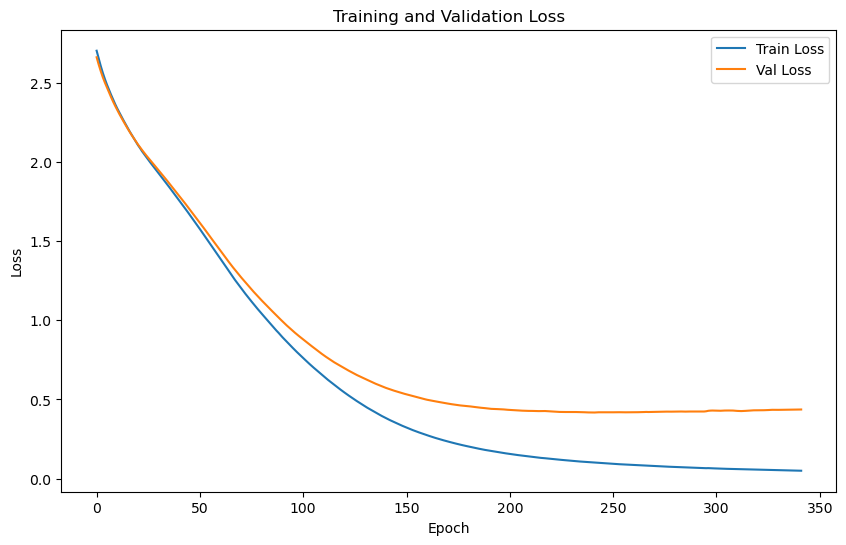

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.3664 | Test Accuracy: 88.06%


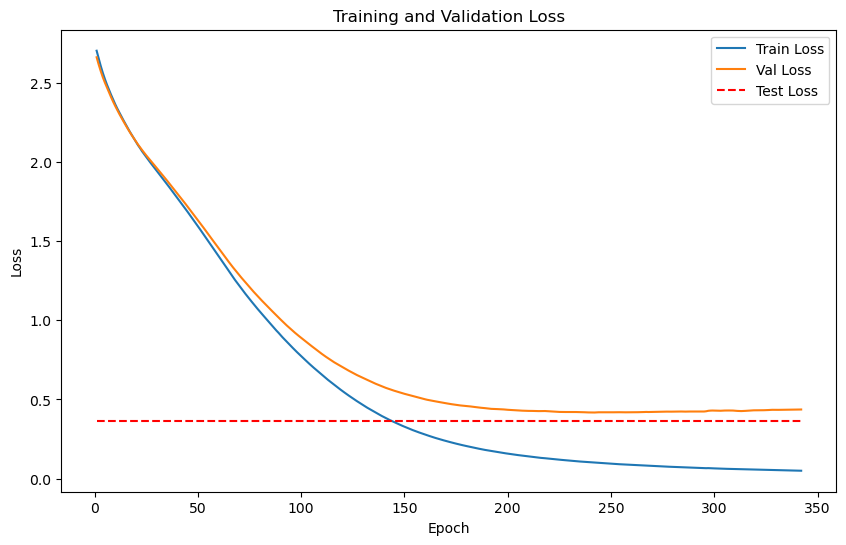

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.2480
Epoch [1/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3547

Validation loss improved from inf to 0.3547. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.2516
Epoch [2/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.3562

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.2561
Epoch [3/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3583

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.2603
Epoch [4/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.3603

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.2617
Epoch [5/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.2606
Epoch [6/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.2593
Epoch [7/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.3591

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.2587
Epoch [8/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.3585

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.2570
Epoch [9/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.3574

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.2552
Epoch [10/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3564

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.2528
Epoch [11/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.2491
Epoch [12/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.3532

Validation loss improved from 0.3547 to 0.3532. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.2453
Epoch [13/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.3513

Validation loss improved from 0.3532 to 0.3513. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.2400
Epoch [14/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.3486

Validation loss improved from 0.3513 to 0.3486. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.2370
Epoch [15/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3467

Validation loss improved from 0.3486 to 0.3467. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.2339
Epoch [16/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3450

Validation loss improved from 0.3467 to 0.3450. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.2310
Epoch [17/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.3433

Validation loss improved from 0.3450 to 0.3433. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.2302
Epoch [18/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3425

Validation loss improved from 0.3433 to 0.3425. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.2334
Epoch [19/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3438

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.2370
Epoch [20/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3452

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.2405
Epoch [21/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.2428
Epoch [22/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3469

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2427
Epoch [23/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2413
Epoch [24/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.3450

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.2398
Epoch [25/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.2386
Epoch [26/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3420

Validation loss improved from 0.3425 to 0.3420. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.2364
Epoch [27/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.3398

Validation loss improved from 0.3420 to 0.3398. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.2335
Epoch [28/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.3375

Validation loss improved from 0.3398 to 0.3375. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.2304
Epoch [29/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3355

Validation loss improved from 0.3375 to 0.3355. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2270
Epoch [30/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.3334

Validation loss improved from 0.3355 to 0.3334. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.2233
Epoch [31/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.3313

Validation loss improved from 0.3334 to 0.3313. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.2192
Epoch [32/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3289

Validation loss improved from 0.3313 to 0.3289. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.2157
Epoch [33/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3267

Validation loss improved from 0.3289 to 0.3267. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.2125
Epoch [34/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3242

Validation loss improved from 0.3267 to 0.3242. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.2095
Epoch [35/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3218

Validation loss improved from 0.3242 to 0.3218. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.2067
Epoch [36/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3194

Validation loss improved from 0.3218 to 0.3194. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.2044
Epoch [37/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3172

Validation loss improved from 0.3194 to 0.3172. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.2023
Epoch [38/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3152

Validation loss improved from 0.3172 to 0.3152. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.2004
Epoch [39/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3133

Validation loss improved from 0.3152 to 0.3133. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1985
Epoch [40/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.3115

Validation loss improved from 0.3133 to 0.3115. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.1968
Epoch [41/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3098

Validation loss improved from 0.3115 to 0.3098. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.1954
Epoch [42/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3085

Validation loss improved from 0.3098 to 0.3085. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.1944
Epoch [43/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3073

Validation loss improved from 0.3085 to 0.3073. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1936
Epoch [44/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3063

Validation loss improved from 0.3073 to 0.3063. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1929
Epoch [45/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3055

Validation loss improved from 0.3063 to 0.3055. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1922
Epoch [46/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3047

Validation loss improved from 0.3055 to 0.3047. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.1914
Epoch [47/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3039

Validation loss improved from 0.3047 to 0.3039. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.1904
Epoch [48/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3031

Validation loss improved from 0.3039 to 0.3031. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1896
Epoch [49/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3025

Validation loss improved from 0.3031 to 0.3025. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1890
Epoch [50/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3019

Validation loss improved from 0.3025 to 0.3019. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1883
Epoch [51/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3013

Validation loss improved from 0.3019 to 0.3013. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1876
Epoch [52/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3007

Validation loss improved from 0.3013 to 0.3007. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1867
Epoch [53/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3000

Validation loss improved from 0.3007 to 0.3000. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1859
Epoch [54/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2995

Validation loss improved from 0.3000 to 0.2995. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1852
Epoch [55/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.2990

Validation loss improved from 0.2995 to 0.2990. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1843
Epoch [56/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2984

Validation loss improved from 0.2990 to 0.2984. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1837
Epoch [57/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.2979

Validation loss improved from 0.2984 to 0.2979. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1828
Epoch [58/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2972

Validation loss improved from 0.2979 to 0.2972. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.1821
Epoch [59/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.2966

Validation loss improved from 0.2972 to 0.2966. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1814
Epoch [60/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2961

Validation loss improved from 0.2966 to 0.2961. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1808
Epoch [61/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2955

Validation loss improved from 0.2961 to 0.2955. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.1800
Epoch [62/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2949

Validation loss improved from 0.2955 to 0.2949. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.1791
Epoch [63/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2942

Validation loss improved from 0.2949 to 0.2942. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.1784
Epoch [64/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2937

Validation loss improved from 0.2942 to 0.2937. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.1776
Epoch [65/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2932

Validation loss improved from 0.2937 to 0.2932. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1768
Epoch [66/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2927

Validation loss improved from 0.2932 to 0.2927. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.1762
Epoch [67/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2923

Validation loss improved from 0.2927 to 0.2923. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.1753
Epoch [68/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.2916

Validation loss improved from 0.2923 to 0.2916. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1743
Epoch [69/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2909

Validation loss improved from 0.2916 to 0.2909. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1733
Epoch [70/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2901

Validation loss improved from 0.2909 to 0.2901. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1725
Epoch [71/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2894

Validation loss improved from 0.2901 to 0.2894. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1719
Epoch [72/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2888

Validation loss improved from 0.2894 to 0.2888. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1713
Epoch [73/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2881

Validation loss improved from 0.2888 to 0.2881. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.1707
Epoch [74/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2874

Validation loss improved from 0.2881 to 0.2874. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.1700
Epoch [75/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2867

Validation loss improved from 0.2874 to 0.2867. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.1692
Epoch [76/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2859

Validation loss improved from 0.2867 to 0.2859. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1681
Epoch [77/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2849

Validation loss improved from 0.2859 to 0.2849. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4006
    Batch [2/2], Val Loss: 0.1672
Epoch [78/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2839

Validation loss improved from 0.2849 to 0.2839. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.1661
Epoch [79/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2828

Validation loss improved from 0.2839 to 0.2828. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.1648
Epoch [80/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2816

Validation loss improved from 0.2828 to 0.2816. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.1636
Epoch [81/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2805

Validation loss improved from 0.2816 to 0.2805. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.1626
Epoch [82/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2795

Validation loss improved from 0.2805 to 0.2795. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.1614
Epoch [83/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2785

Validation loss improved from 0.2795 to 0.2785. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3947
    Batch [2/2], Val Loss: 0.1603
Epoch [84/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2775

Validation loss improved from 0.2785 to 0.2775. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1592
Epoch [85/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2766

Validation loss improved from 0.2775 to 0.2766. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.1583
Epoch [86/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2758

Validation loss improved from 0.2766 to 0.2758. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.1573
Epoch [87/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2751

Validation loss improved from 0.2758 to 0.2751. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1563
Epoch [88/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2745

Validation loss improved from 0.2751 to 0.2745. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.1553
Epoch [89/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2738

Validation loss improved from 0.2745 to 0.2738. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1540
Epoch [90/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2732

Validation loss improved from 0.2738 to 0.2732. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.1527
Epoch [91/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2723

Validation loss improved from 0.2732 to 0.2723. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1513
Epoch [92/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2713

Validation loss improved from 0.2723 to 0.2713. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1505
Epoch [93/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2706

Validation loss improved from 0.2713 to 0.2706. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1496
Epoch [94/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2698

Validation loss improved from 0.2706 to 0.2698. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.1489
Epoch [95/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2693

Validation loss improved from 0.2698 to 0.2693. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1484
Epoch [96/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2688

Validation loss improved from 0.2693 to 0.2688. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.1478
Epoch [97/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2682

Validation loss improved from 0.2688 to 0.2682. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.1475
Epoch [98/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2678

Validation loss improved from 0.2682 to 0.2678. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.1476
Epoch [99/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1478
Epoch [100/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1477
Epoch [101/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2672

Validation loss improved from 0.2675 to 0.2672. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1474
Epoch [102/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1471
Epoch [103/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2668

Validation loss improved from 0.2670 to 0.2668. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.1467
Epoch [104/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2664

Validation loss improved from 0.2668 to 0.2664. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.1464
Epoch [105/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2661

Validation loss improved from 0.2664 to 0.2661. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.1458
Epoch [106/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2658

Validation loss improved from 0.2661 to 0.2658. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1450
Epoch [107/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2652

Validation loss improved from 0.2658 to 0.2652. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1447
Epoch [108/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2650

Validation loss improved from 0.2652 to 0.2650. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1443
Epoch [109/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1437
Epoch [110/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2645

Validation loss improved from 0.2648 to 0.2645. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1430
Epoch [111/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2641

Validation loss improved from 0.2645 to 0.2641. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1421
Epoch [112/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2636

Validation loss improved from 0.2641 to 0.2636. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.1414
Epoch [113/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2631

Validation loss improved from 0.2636 to 0.2631. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1404
Epoch [114/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2623

Validation loss improved from 0.2631 to 0.2623. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1395
Epoch [115/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2615

Validation loss improved from 0.2623 to 0.2615. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1385
Epoch [116/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2608

Validation loss improved from 0.2615 to 0.2608. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1377
Epoch [117/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2602

Validation loss improved from 0.2608 to 0.2602. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1371
Epoch [118/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2599

Validation loss improved from 0.2602 to 0.2599. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.1362
Epoch [119/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2597

Validation loss improved from 0.2599 to 0.2597. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1357
Epoch [120/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1355
Epoch [121/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2596

Validation loss improved from 0.2596 to 0.2596. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1356
Epoch [122/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2596

Validation loss improved from 0.2596 to 0.2596. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1358
Epoch [123/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1362
Epoch [124/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1365
Epoch [125/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1366
Epoch [126/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1369
Epoch [127/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1374
Epoch [128/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1383
Epoch [129/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1391
Epoch [130/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2607

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1398
Epoch [131/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2612

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1403
Epoch [132/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1407
Epoch [133/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2622

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1407
Epoch [134/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2622

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1407
Epoch [135/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2621

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1405
Epoch [136/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1401
Epoch [137/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2614

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1398
Epoch [138/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1391
Epoch [139/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3811
    Batch [2/2], Val Loss: 0.1385
Epoch [140/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1374
Epoch [141/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2591

Validation loss improved from 0.2596 to 0.2591. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.1367
Epoch [142/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2585

Validation loss improved from 0.2591 to 0.2585. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3796
    Batch [2/2], Val Loss: 0.1360
Epoch [143/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2578

Validation loss improved from 0.2585 to 0.2578. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1353
Epoch [144/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2570

Validation loss improved from 0.2578 to 0.2570. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.1348
Epoch [145/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2562

Validation loss improved from 0.2570 to 0.2562. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3769
    Batch [2/2], Val Loss: 0.1341
Epoch [146/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2555

Validation loss improved from 0.2562 to 0.2555. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1332
Epoch [147/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2546

Validation loss improved from 0.2555 to 0.2546. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.1319
Epoch [148/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2536

Validation loss improved from 0.2546 to 0.2536. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3745
    Batch [2/2], Val Loss: 0.1310
Epoch [149/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2528

Validation loss improved from 0.2536 to 0.2528. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3737
    Batch [2/2], Val Loss: 0.1301
Epoch [150/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2519

Validation loss improved from 0.2528 to 0.2519. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1292
Epoch [151/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2510

Validation loss improved from 0.2519 to 0.2510. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1283
Epoch [152/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2502

Validation loss improved from 0.2510 to 0.2502. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1275
Epoch [153/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2495

Validation loss improved from 0.2502 to 0.2495. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.1270
Epoch [154/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2490

Validation loss improved from 0.2495 to 0.2490. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.1263
Epoch [155/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2486

Validation loss improved from 0.2490 to 0.2486. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.1258
Epoch [156/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2483

Validation loss improved from 0.2486 to 0.2483. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.1253
Epoch [157/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2480

Validation loss improved from 0.2483 to 0.2480. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1248
Epoch [158/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2475

Validation loss improved from 0.2480 to 0.2475. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.1246
Epoch [159/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2473

Validation loss improved from 0.2475 to 0.2473. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.1242
Epoch [160/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2469

Validation loss improved from 0.2473 to 0.2469. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.1238
Epoch [161/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2465

Validation loss improved from 0.2469 to 0.2465. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1231
Epoch [162/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2459

Validation loss improved from 0.2465 to 0.2459. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1220
Epoch [163/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2450

Validation loss improved from 0.2459 to 0.2450. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3674
    Batch [2/2], Val Loss: 0.1209
Epoch [164/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2442

Validation loss improved from 0.2450 to 0.2442. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.1198
Epoch [165/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2433

Validation loss improved from 0.2442 to 0.2433. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.1192
Epoch [166/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2425

Validation loss improved from 0.2433 to 0.2425. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.1185
Epoch [167/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2419

Validation loss improved from 0.2425 to 0.2419. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1179
Epoch [168/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2413

Validation loss improved from 0.2419 to 0.2413. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1175
Epoch [169/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2409

Validation loss improved from 0.2413 to 0.2409. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.1175
Epoch [170/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.1176
Epoch [171/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1177
Epoch [172/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.1178
Epoch [173/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2412

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1177
Epoch [174/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2411

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1175
Epoch [175/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1173
Epoch [176/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2409

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1167
Epoch [177/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1164
Epoch [178/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.1161
Epoch [179/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.1157
Epoch [180/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2402

Validation loss improved from 0.2405 to 0.2402. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.1153
Epoch [181/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2398

Validation loss improved from 0.2402 to 0.2398. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1150
Epoch [182/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.1147
Epoch [183/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2394

Validation loss improved from 0.2397 to 0.2394. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.1142
Epoch [184/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2387

Validation loss improved from 0.2394 to 0.2387. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1139
Epoch [185/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2379

Validation loss improved from 0.2387 to 0.2379. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1134
Epoch [186/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2370

Validation loss improved from 0.2379 to 0.2370. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1129
Epoch [187/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2362

Validation loss improved from 0.2370 to 0.2362. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3584
    Batch [2/2], Val Loss: 0.1122
Epoch [188/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2353

Validation loss improved from 0.2362 to 0.2353. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.1115
Epoch [189/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2344

Validation loss improved from 0.2353 to 0.2344. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3565
    Batch [2/2], Val Loss: 0.1110
Epoch [190/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2338

Validation loss improved from 0.2344 to 0.2338. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1104
Epoch [191/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2331

Validation loss improved from 0.2338 to 0.2331. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1102
Epoch [192/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2328

Validation loss improved from 0.2331 to 0.2328. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3550
    Batch [2/2], Val Loss: 0.1098
Epoch [193/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2324

Validation loss improved from 0.2328 to 0.2324. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1094
Epoch [194/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2320

Validation loss improved from 0.2324 to 0.2320. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1091
Epoch [195/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2318

Validation loss improved from 0.2320 to 0.2318. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1090
Epoch [196/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1092
Epoch [197/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.1096
Epoch [198/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.2326

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1101
Epoch [199/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1104
Epoch [200/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3563
    Batch [2/2], Val Loss: 0.1104
Epoch [201/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3562
    Batch [2/2], Val Loss: 0.1102
Epoch [202/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1096
Epoch [203/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1088
Epoch [204/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2324

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1076
Epoch [205/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2315

Validation loss improved from 0.2317 to 0.2315. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1063
Epoch [206/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2305

Validation loss improved from 0.2315 to 0.2305. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.1049
Epoch [207/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2296

Validation loss improved from 0.2305 to 0.2296. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3536
    Batch [2/2], Val Loss: 0.1034
Epoch [208/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2285

Validation loss improved from 0.2296 to 0.2285. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3528
    Batch [2/2], Val Loss: 0.1020
Epoch [209/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2274

Validation loss improved from 0.2285 to 0.2274. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1009
Epoch [210/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2264

Validation loss improved from 0.2274 to 0.2264. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.0998
Epoch [211/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.2255

Validation loss improved from 0.2264 to 0.2255. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.0990
Epoch [212/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2247

Validation loss improved from 0.2255 to 0.2247. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.0981
Epoch [213/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2239

Validation loss improved from 0.2247 to 0.2239. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.0977
Epoch [214/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2235

Validation loss improved from 0.2239 to 0.2235. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.0976
Epoch [215/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2231

Validation loss improved from 0.2235 to 0.2231. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.0976
Epoch [216/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.0975
Epoch [217/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2225

Validation loss improved from 0.2229 to 0.2225. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.0978
Epoch [218/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2223

Validation loss improved from 0.2225 to 0.2223. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3460
    Batch [2/2], Val Loss: 0.0982
Epoch [219/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2221

Validation loss improved from 0.2223 to 0.2221. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.0987
Epoch [220/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.0988
Epoch [221/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.0989
Epoch [222/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.0989
Epoch [223/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2223

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.0989
Epoch [224/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.0983
Epoch [225/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.0975
Epoch [226/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.0969
Epoch [227/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2216

Validation loss improved from 0.2221 to 0.2216. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.0964
Epoch [228/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2211

Validation loss improved from 0.2216 to 0.2211. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3455
    Batch [2/2], Val Loss: 0.0961
Epoch [229/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2208

Validation loss improved from 0.2211 to 0.2208. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3451
    Batch [2/2], Val Loss: 0.0956
Epoch [230/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2204

Validation loss improved from 0.2208 to 0.2204. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.0950
Epoch [231/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2200

Validation loss improved from 0.2204 to 0.2200. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.0942
Epoch [232/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2195

Validation loss improved from 0.2200 to 0.2195. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.0931
Epoch [233/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2186

Validation loss improved from 0.2195 to 0.2186. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3434
    Batch [2/2], Val Loss: 0.0920
Epoch [234/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2177

Validation loss improved from 0.2186 to 0.2177. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3429
    Batch [2/2], Val Loss: 0.0907
Epoch [235/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2168

Validation loss improved from 0.2177 to 0.2168. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.0895
Epoch [236/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2159

Validation loss improved from 0.2168 to 0.2159. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3418
    Batch [2/2], Val Loss: 0.0887
Epoch [237/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2153

Validation loss improved from 0.2159 to 0.2153. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.0882
Epoch [238/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2150

Validation loss improved from 0.2153 to 0.2150. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3416
    Batch [2/2], Val Loss: 0.0875
Epoch [239/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2145

Validation loss improved from 0.2150 to 0.2145. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.0871
Epoch [240/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2142

Validation loss improved from 0.2145 to 0.2142. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.0868
Epoch [241/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2137

Validation loss improved from 0.2142 to 0.2137. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.0869
Epoch [242/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2134

Validation loss improved from 0.2137 to 0.2134. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.0867
Epoch [243/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2131

Validation loss improved from 0.2134 to 0.2131. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.0869
Epoch [244/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2130

Validation loss improved from 0.2131 to 0.2130. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.0870
Epoch [245/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2127

Validation loss improved from 0.2130 to 0.2127. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.0872
Epoch [246/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2126

Validation loss improved from 0.2127 to 0.2126. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.0875
Epoch [247/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.0877
Epoch [248/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.0880
Epoch [249/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.0886
Epoch [250/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.0891
Epoch [251/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.0895
Epoch [252/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2140

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.0896
Epoch [253/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.0896
Epoch [254/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.0895
Epoch [255/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.0894
Epoch [256/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2143

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.0889
Epoch [257/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2138

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.0883
Epoch [258/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.0875
Epoch [259/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2121

Validation loss improved from 0.2126 to 0.2121. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3356
    Batch [2/2], Val Loss: 0.0864
Epoch [260/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2110

Validation loss improved from 0.2121 to 0.2110. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.0854
Epoch [261/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2101

Validation loss improved from 0.2110 to 0.2101. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.0846
Epoch [262/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2093

Validation loss improved from 0.2101 to 0.2093. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3335
    Batch [2/2], Val Loss: 0.0837
Epoch [263/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2086

Validation loss improved from 0.2093 to 0.2086. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3333
    Batch [2/2], Val Loss: 0.0832
Epoch [264/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2082

Validation loss improved from 0.2086 to 0.2082. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3332
    Batch [2/2], Val Loss: 0.0826
Epoch [265/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2079

Validation loss improved from 0.2082 to 0.2079. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.0821
Epoch [266/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2075

Validation loss improved from 0.2079 to 0.2075. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3327
    Batch [2/2], Val Loss: 0.0816
Epoch [267/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2072

Validation loss improved from 0.2075 to 0.2072. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3325
    Batch [2/2], Val Loss: 0.0814
Epoch [268/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2069

Validation loss improved from 0.2072 to 0.2069. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3319
    Batch [2/2], Val Loss: 0.0815
Epoch [269/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2067

Validation loss improved from 0.2069 to 0.2067. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.0813
Epoch [270/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2062

Validation loss improved from 0.2067 to 0.2062. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3302
    Batch [2/2], Val Loss: 0.0811
Epoch [271/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2056

Validation loss improved from 0.2062 to 0.2056. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3296
    Batch [2/2], Val Loss: 0.0811
Epoch [272/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2054

Validation loss improved from 0.2056 to 0.2054. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3290
    Batch [2/2], Val Loss: 0.0812
Epoch [273/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2051

Validation loss improved from 0.2054 to 0.2051. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.0816
Epoch [274/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2050

Validation loss improved from 0.2051 to 0.2050. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3282
    Batch [2/2], Val Loss: 0.0818
Epoch [275/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.0823
Epoch [276/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.0825
Epoch [277/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3281
    Batch [2/2], Val Loss: 0.0830
Epoch [278/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.0834
Epoch [279/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3287
    Batch [2/2], Val Loss: 0.0835
Epoch [280/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2061

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.0837
Epoch [281/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.0837
Epoch [282/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2070

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3307
    Batch [2/2], Val Loss: 0.0834
Epoch [283/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.0834
Epoch [284/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3318
    Batch [2/2], Val Loss: 0.0835
Epoch [285/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2076

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.0837
Epoch [286/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2079

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.0839
Epoch [287/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.0842
Epoch [288/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2076

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.0843
Epoch [289/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2073

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3298
    Batch [2/2], Val Loss: 0.0839
Epoch [290/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2068

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3294
    Batch [2/2], Val Loss: 0.0835
Epoch [291/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2064

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3293
    Batch [2/2], Val Loss: 0.0832
Epoch [292/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2062

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3290
    Batch [2/2], Val Loss: 0.0829
Epoch [293/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.0826
Epoch [294/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3280
    Batch [2/2], Val Loss: 0.0821
Epoch [295/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3277
    Batch [2/2], Val Loss: 0.0814
Epoch [296/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2045

Validation loss improved from 0.2050 to 0.2045. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.0807
Epoch [297/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2042

Validation loss improved from 0.2045 to 0.2042. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.0798
Epoch [298/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2034

Validation loss improved from 0.2042 to 0.2034. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3258
    Batch [2/2], Val Loss: 0.0785
Epoch [299/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2022

Validation loss improved from 0.2034 to 0.2022. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3252
    Batch [2/2], Val Loss: 0.0776
Epoch [300/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.2014

Validation loss improved from 0.2022 to 0.2014. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3251
    Batch [2/2], Val Loss: 0.0769
Epoch [301/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2010

Validation loss improved from 0.2014 to 0.2010. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3250
    Batch [2/2], Val Loss: 0.0765
Epoch [302/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2008

Validation loss improved from 0.2010 to 0.2008. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3246
    Batch [2/2], Val Loss: 0.0762
Epoch [303/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2004

Validation loss improved from 0.2008 to 0.2004. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3246
    Batch [2/2], Val Loss: 0.0761
Epoch [304/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2004

Validation loss improved from 0.2004 to 0.2004. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3250
    Batch [2/2], Val Loss: 0.0760
Epoch [305/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.2005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.0761
Epoch [306/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2008

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3257
    Batch [2/2], Val Loss: 0.0763
Epoch [307/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2010

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3261
    Batch [2/2], Val Loss: 0.0765
Epoch [308/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.2013

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3264
    Batch [2/2], Val Loss: 0.0770
Epoch [309/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3265
    Batch [2/2], Val Loss: 0.0775
Epoch [310/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2020

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3265
    Batch [2/2], Val Loss: 0.0780
Epoch [311/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2022

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3257
    Batch [2/2], Val Loss: 0.0785
Epoch [312/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2021

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3245
    Batch [2/2], Val Loss: 0.0788
Epoch [313/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.2016

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3236
    Batch [2/2], Val Loss: 0.0789
Epoch [314/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.2012

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3225
    Batch [2/2], Val Loss: 0.0789
Epoch [315/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.0787
Epoch [316/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2000

Validation loss improved from 0.2004 to 0.2000. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3202
    Batch [2/2], Val Loss: 0.0784
Epoch [317/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.1993

Validation loss improved from 0.2000 to 0.1993. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3192
    Batch [2/2], Val Loss: 0.0778
Epoch [318/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.1985

Validation loss improved from 0.1993 to 0.1985. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.0770
Epoch [319/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.1978

Validation loss improved from 0.1985 to 0.1978. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.0762
Epoch [320/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.1971

Validation loss improved from 0.1978 to 0.1971. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.0754
Epoch [321/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.1963

Validation loss improved from 0.1971 to 0.1963. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.0750
Epoch [322/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.1960

Validation loss improved from 0.1963 to 0.1960. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.0745
Epoch [323/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.1958

Validation loss improved from 0.1960 to 0.1958. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.0743
Epoch [324/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.1956

Validation loss improved from 0.1958 to 0.1956. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.0745
Epoch [325/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.1958

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.0744
Epoch [326/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.1959

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.0742
Epoch [327/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.1958

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.0738
Epoch [328/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.1955

Validation loss improved from 0.1956 to 0.1955. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.0737
Epoch [329/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.1955

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3177
    Batch [2/2], Val Loss: 0.0738
Epoch [330/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.1957

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3188
    Batch [2/2], Val Loss: 0.0738
Epoch [331/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0737
Epoch [332/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.1965

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.0735
Epoch [333/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.1966

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3195
    Batch [2/2], Val Loss: 0.0731
Epoch [334/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3194
    Batch [2/2], Val Loss: 0.0725
Epoch [335/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.1959

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0718
Epoch [336/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.1956

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3192
    Batch [2/2], Val Loss: 0.0711
Epoch [337/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.1952

Validation loss improved from 0.1955 to 0.1952. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.0706
Epoch [338/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.1946

Validation loss improved from 0.1952 to 0.1946. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3181
    Batch [2/2], Val Loss: 0.0698
Epoch [339/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.1939

Validation loss improved from 0.1946 to 0.1939. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3177
    Batch [2/2], Val Loss: 0.0693
Epoch [340/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.1935

Validation loss improved from 0.1939 to 0.1935. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.0689
Epoch [341/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.1928

Validation loss improved from 0.1935 to 0.1928. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3165
    Batch [2/2], Val Loss: 0.0687
Epoch [342/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.1926

Validation loss improved from 0.1928 to 0.1926. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.0685
Epoch [343/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.0684
Epoch [344/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.1925

Validation loss improved from 0.1926 to 0.1925. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3166
    Batch [2/2], Val Loss: 0.0684
Epoch [345/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.1925

Validation loss improved from 0.1925 to 0.1925. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.0684
Epoch [346/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3035
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.0686
Epoch [347/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.0687
Epoch [348/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.0688
Epoch [349/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.0688
Epoch [350/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.0689
Epoch [351/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.0694
Epoch [352/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.0698
Epoch [353/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0700
Epoch [354/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0700
Epoch [355/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0699
Epoch [356/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.1920

Validation loss improved from 0.1925 to 0.1920. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.0695
Epoch [357/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.1914

Validation loss improved from 0.1920 to 0.1914. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3131
    Batch [2/2], Val Loss: 0.0692
Epoch [358/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.1912

Validation loss improved from 0.1914 to 0.1912. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.0690
Epoch [359/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0689
Epoch [360/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0686
Epoch [361/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0683
Epoch [362/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.1919

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.0677
Epoch [363/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.1919

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.0677
Epoch [364/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.0676
Epoch [365/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.1924

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.0674
Epoch [366/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3181
    Batch [2/2], Val Loss: 0.0673
Epoch [367/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.1927

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.0672
Epoch [368/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.0670
Epoch [369/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.1927

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3184
    Batch [2/2], Val Loss: 0.0669
Epoch [370/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.1927

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.0667
Epoch [371/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.1920

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.0669
Epoch [372/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.0669
Epoch [373/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0670
Epoch [374/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.0672
Epoch [375/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0672
Epoch [376/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0675
Epoch [377/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0673
Epoch [378/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.1911

Validation loss improved from 0.1912 to 0.1911. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0674
Epoch [379/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.1907

Validation loss improved from 0.1911 to 0.1907. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3134
    Batch [2/2], Val Loss: 0.0677
Epoch [380/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.1905

Validation loss improved from 0.1907 to 0.1905. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3128
    Batch [2/2], Val Loss: 0.0681
Epoch [381/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.1904

Validation loss improved from 0.1905 to 0.1904. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3120
    Batch [2/2], Val Loss: 0.0684
Epoch [382/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.1902

Validation loss improved from 0.1904 to 0.1902. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0688
Epoch [383/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.1899

Validation loss improved from 0.1902 to 0.1899. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3100
    Batch [2/2], Val Loss: 0.0692
Epoch [384/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.1896

Validation loss improved from 0.1899 to 0.1896. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.0697
Epoch [385/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.1896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.0699
Epoch [386/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.1898

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3094
    Batch [2/2], Val Loss: 0.0701
Epoch [387/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.1897

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3089
    Batch [2/2], Val Loss: 0.0699
Epoch [388/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.1894

Validation loss improved from 0.1896 to 0.1894. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3086
    Batch [2/2], Val Loss: 0.0695
Epoch [389/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.1891

Validation loss improved from 0.1894 to 0.1891. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3085
    Batch [2/2], Val Loss: 0.0693
Epoch [390/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.1889

Validation loss improved from 0.1891 to 0.1889. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3083
    Batch [2/2], Val Loss: 0.0690
Epoch [391/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.1887

Validation loss improved from 0.1889 to 0.1887. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3076
    Batch [2/2], Val Loss: 0.0685
Epoch [392/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1880

Validation loss improved from 0.1887 to 0.1880. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3074
    Batch [2/2], Val Loss: 0.0679
Epoch [393/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.1876

Validation loss improved from 0.1880 to 0.1876. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3069
    Batch [2/2], Val Loss: 0.0671
Epoch [394/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.1870

Validation loss improved from 0.1876 to 0.1870. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3063
    Batch [2/2], Val Loss: 0.0666
Epoch [395/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.1865

Validation loss improved from 0.1870 to 0.1865. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.0660
Epoch [396/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.1858

Validation loss improved from 0.1865 to 0.1858. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3051
    Batch [2/2], Val Loss: 0.0655
Epoch [397/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.1853

Validation loss improved from 0.1858 to 0.1853. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3049
    Batch [2/2], Val Loss: 0.0652
Epoch [398/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.1851

Validation loss improved from 0.1853 to 0.1851. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3049
    Batch [2/2], Val Loss: 0.0650
Epoch [399/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.1849

Validation loss improved from 0.1851 to 0.1849. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.0650
Epoch [400/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.1848

Validation loss improved from 0.1849 to 0.1848. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0653
Epoch [401/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.1848

Validation loss improved from 0.1848 to 0.1848. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.0656
Epoch [402/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.0661
Epoch [403/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.0665
Epoch [404/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0669
Epoch [405/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3050
    Batch [2/2], Val Loss: 0.0672
Epoch [406/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0672
Epoch [407/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3059
    Batch [2/2], Val Loss: 0.0672
Epoch [408/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3058
    Batch [2/2], Val Loss: 0.0666
Epoch [409/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.1862

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0660
Epoch [410/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3053
    Batch [2/2], Val Loss: 0.0654
Epoch [411/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3049
    Batch [2/2], Val Loss: 0.0650
Epoch [412/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3048
    Batch [2/2], Val Loss: 0.0645
Epoch [413/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.1846

Validation loss improved from 0.1848 to 0.1846. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.0640
Epoch [414/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1843

Validation loss improved from 0.1846 to 0.1843. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3047
    Batch [2/2], Val Loss: 0.0638
Epoch [415/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.1843

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3051
    Batch [2/2], Val Loss: 0.0638
Epoch [416/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0636
Epoch [417/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.1847

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.0636
Epoch [418/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3064
    Batch [2/2], Val Loss: 0.0632
Epoch [419/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3071
    Batch [2/2], Val Loss: 0.0629
Epoch [420/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3076
    Batch [2/2], Val Loss: 0.0629
Epoch [421/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.0631
Epoch [422/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.0633
Epoch [423/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.0636
Epoch [424/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3058
    Batch [2/2], Val Loss: 0.0638
Epoch [425/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.0635
Epoch [426/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.1843

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.0630
Epoch [427/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.1838

Validation loss improved from 0.1843 to 0.1838. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.0627
Epoch [428/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.1836

Validation loss improved from 0.1838 to 0.1836. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0623
Epoch [429/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.1833

Validation loss improved from 0.1836 to 0.1833. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.0619
Epoch [430/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.1830

Validation loss improved from 0.1833 to 0.1830. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3039
    Batch [2/2], Val Loss: 0.0613
Epoch [431/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.1826

Validation loss improved from 0.1830 to 0.1826. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3039
    Batch [2/2], Val Loss: 0.0607
Epoch [432/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.1823

Validation loss improved from 0.1826 to 0.1823. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3042
    Batch [2/2], Val Loss: 0.0602
Epoch [433/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.1822

Validation loss improved from 0.1823 to 0.1822. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3044
    Batch [2/2], Val Loss: 0.0602
Epoch [434/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.0598
Epoch [435/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.1819

Validation loss improved from 0.1822 to 0.1819. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3033
    Batch [2/2], Val Loss: 0.0596
Epoch [436/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.1815

Validation loss improved from 0.1819 to 0.1815. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.0597
Epoch [437/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.1814

Validation loss improved from 0.1815 to 0.1814. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.0600
Epoch [438/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3036
    Batch [2/2], Val Loss: 0.0604
Epoch [439/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.0609
Epoch [440/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3036
    Batch [2/2], Val Loss: 0.0614
Epoch [441/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.1825

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.0617
Epoch [442/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.1829

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.0622
Epoch [443/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1831

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.0628
Epoch [444/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1833

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.0632
Epoch [445/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.1833

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3037
    Batch [2/2], Val Loss: 0.0635
Epoch [446/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.1836

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0639
Epoch [447/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.1841

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3048
    Batch [2/2], Val Loss: 0.0643
Epoch [448/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.1845

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.0645
Epoch [449/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3054
    Batch [2/2], Val Loss: 0.0647
Epoch [450/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.0649
Epoch [451/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.0650
Epoch [452/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.1847

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.0649
Epoch [453/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.0646
Epoch [454/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3027
    Batch [2/2], Val Loss: 0.0637
Epoch [455/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.1832

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3018
    Batch [2/2], Val Loss: 0.0631
Epoch [456/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.0627
Epoch [457/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.0622
Epoch [458/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.1814

Validation loss improved from 0.1814 to 0.1814. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3002
    Batch [2/2], Val Loss: 0.0618
Epoch [459/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.1810

Validation loss improved from 0.1814 to 0.1810. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3004
    Batch [2/2], Val Loss: 0.0612
Epoch [460/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.1808

Validation loss improved from 0.1810 to 0.1808. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.0607
Epoch [461/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1808

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0604
Epoch [462/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.0602
Epoch [463/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0602
Epoch [464/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3016
    Batch [2/2], Val Loss: 0.0605
Epoch [465/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.1811

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3016
    Batch [2/2], Val Loss: 0.0608
Epoch [466/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.0610
Epoch [467/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.0611
Epoch [468/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.0614
Epoch [469/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.0617
Epoch [470/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0621
Epoch [471/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.1832

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3051
    Batch [2/2], Val Loss: 0.0626
Epoch [472/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1839

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0631
Epoch [473/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1844

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3060
    Batch [2/2], Val Loss: 0.0637
Epoch [474/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3064
    Batch [2/2], Val Loss: 0.0645
Epoch [475/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.0648
Epoch [476/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3068
    Batch [2/2], Val Loss: 0.0653
Epoch [477/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.0656
Epoch [478/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3058
    Batch [2/2], Val Loss: 0.0655
Epoch [479/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.0653
Epoch [480/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2582
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.0651
Epoch [481/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.1846

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3031
    Batch [2/2], Val Loss: 0.0649
Epoch [482/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.0649
Epoch [483/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.1837

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0647
Epoch [484/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1833

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0643
Epoch [485/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1830

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0638
Epoch [486/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1829

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.0630
Epoch [487/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.1825

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.0620
Epoch [488/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.0618
Epoch [489/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2996
    Batch [2/2], Val Loss: 0.0615
Epoch [490/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.1806

Validation loss improved from 0.1807 to 0.1806. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2990
    Batch [2/2], Val Loss: 0.0614
Epoch [491/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1802

Validation loss improved from 0.1806 to 0.1802. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.0612
Epoch [492/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1798

Validation loss improved from 0.1802 to 0.1798. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2978
    Batch [2/2], Val Loss: 0.0611
Epoch [493/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.1794

Validation loss improved from 0.1798 to 0.1794. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.0609
Epoch [494/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1790

Validation loss improved from 0.1794 to 0.1790. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.0608
Epoch [495/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1787

Validation loss improved from 0.1790 to 0.1787. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.0607
Epoch [496/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.1784

Validation loss improved from 0.1787 to 0.1784. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2956
    Batch [2/2], Val Loss: 0.0606
Epoch [497/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.1781

Validation loss improved from 0.1784 to 0.1781. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.0605
Epoch [498/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1780

Validation loss improved from 0.1781 to 0.1780. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.0605
Epoch [499/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1779

Validation loss improved from 0.1780 to 0.1779. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2951
    Batch [2/2], Val Loss: 0.0605
Epoch [500/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1778

Validation loss improved from 0.1779 to 0.1778. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.0605
Epoch [501/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2949
    Batch [2/2], Val Loss: 0.0605
Epoch [502/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.0605
Epoch [503/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.1776

Validation loss improved from 0.1777 to 0.1776. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.0606
Epoch [504/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.0606
Epoch [505/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.0607
Epoch [506/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.0607
Epoch [507/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.0608
Epoch [508/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.0609
Epoch [509/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2942
    Batch [2/2], Val Loss: 0.0610
Epoch [510/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2942
    Batch [2/2], Val Loss: 0.0611
Epoch [511/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.0612
Epoch [512/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2940
    Batch [2/2], Val Loss: 0.0612
Epoch [513/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0613
Epoch [514/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0614
Epoch [515/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0614
Epoch [516/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0615
Epoch [517/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2585
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0615
Epoch [518/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0616
Epoch [519/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0616
Epoch [520/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0616
Epoch [521/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0616
Epoch [522/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0617
Epoch [523/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [524/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [525/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [526/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [527/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [528/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0617
Epoch [529/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0617
Epoch [530/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1775

Validation loss improved from 0.1776 to 0.1775. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [531/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [532/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [533/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [534/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [535/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [536/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0617
Epoch [537/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0618
Epoch [538/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0618
Epoch [539/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0618
Epoch [540/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0618
Epoch [541/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0618
Epoch [542/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0618
Epoch [543/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0618
Epoch [544/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0617
Epoch [545/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0617
Epoch [546/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0616
Epoch [547/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0615
Epoch [548/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0615
Epoch [549/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0614
Epoch [550/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0614
Epoch [551/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0614
Epoch [552/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0614
Epoch [553/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1774

Validation loss improved from 0.1775 to 0.1774. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [554/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0613
Epoch [555/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1773

Validation loss improved from 0.1774 to 0.1773. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0613
Epoch [556/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1772

Validation loss improved from 0.1773 to 0.1772. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0613
Epoch [557/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0612
Epoch [558/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0612
Epoch [559/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0612
Epoch [560/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0612
Epoch [561/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0612
Epoch [562/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0612
Epoch [563/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0613
Epoch [564/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0613
Epoch [565/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0613
Epoch [566/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0613
Epoch [567/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [568/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [569/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [570/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [571/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [572/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0613
Epoch [573/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0614
Epoch [574/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0613
Epoch [575/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0613
Epoch [576/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0614
Epoch [577/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0614
Epoch [578/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0613
Epoch [579/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0614
Epoch [580/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0614
Epoch [581/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1771

Validation loss improved from 0.1772 to 0.1771. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0614
Epoch [582/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1771

Validation loss improved from 0.1771 to 0.1771. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0614
Epoch [583/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0615
Epoch [584/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.0616
Epoch [585/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.0616
Epoch [586/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0617
Epoch [587/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0617
Epoch [588/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.0617
Epoch [589/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0618
Epoch [590/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0618
Epoch [591/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0619
Epoch [592/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.0619
Epoch [593/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.0620
Epoch [594/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.0620
Epoch [595/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.0620
Epoch [596/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2567
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.0620
Epoch [597/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.0619
Epoch [598/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0619
Epoch [599/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0619
Epoch [600/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.0619
Epoch [601/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [602/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0619
Epoch [603/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0619
Epoch [604/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0619
Epoch [605/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0619
Epoch [606/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0618
Epoch [607/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0618
Epoch [608/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0618
Epoch [609/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0618
Epoch [610/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.0618
Epoch [611/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0618
Epoch [612/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.0618
Epoch [613/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0618
Epoch [614/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0618
Epoch [615/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0618
Epoch [616/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0619
Epoch [617/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.0619
Epoch [618/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0619
Epoch [619/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0619
Epoch [620/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0619
Epoch [621/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0619
Epoch [622/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0619
Epoch [623/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0619
Epoch [624/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0619
Epoch [625/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0619
Epoch [626/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [627/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [628/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [629/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [630/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [631/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0619
Epoch [632/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0619
Epoch [633/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0619
Epoch [634/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0619
Epoch [635/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0619
Epoch [636/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [637/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [638/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [639/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [640/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [641/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [642/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [643/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [644/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [645/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [646/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [647/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [648/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [649/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [650/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [651/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [652/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [653/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [654/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [655/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [656/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [657/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [658/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [659/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [660/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [661/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [662/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [663/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [664/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [665/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [666/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [667/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [668/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [669/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [670/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [671/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [672/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [673/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [674/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [675/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [676/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [677/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [678/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [679/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [680/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [681/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0620
Epoch [682/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 682!!
No improvement for 100 epochs


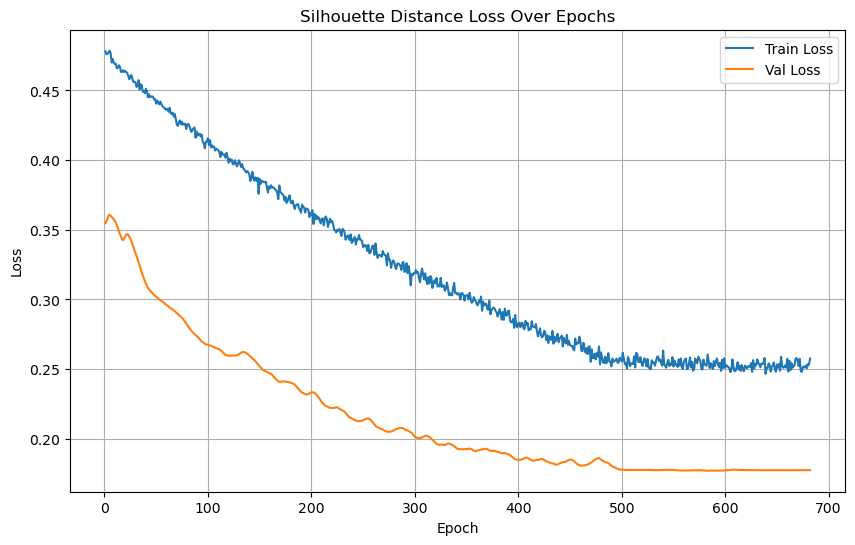

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/46], Loss: 0.1767


Test Batch [20/46], Loss: 0.1827
Test Batch [30/46], Loss: 0.1913
Test Batch [40/46], Loss: 0.1322

Test Loss: 0.2140


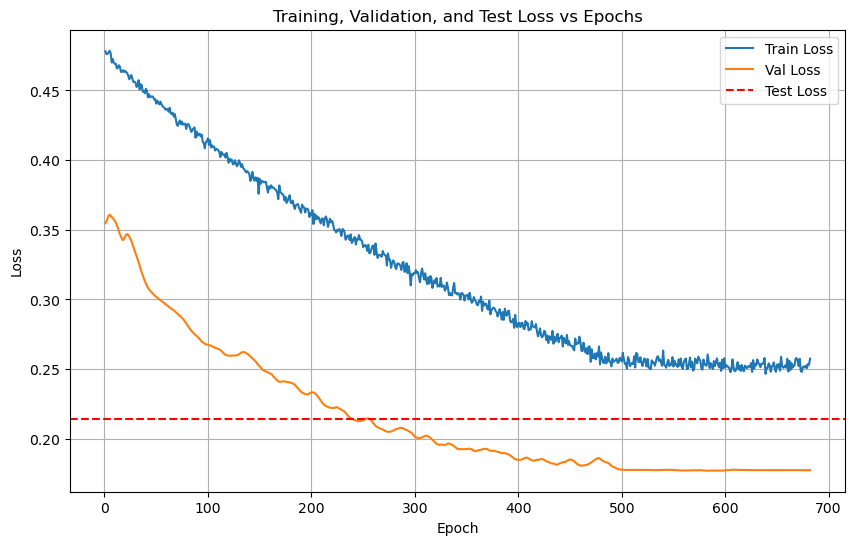

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/46 for test dataset.
  Processed batch 20/46 for test dataset.


  Processed batch 30/46 for test dataset.
  Processed batch 40/46 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.80      0.80      0.80         5
           7       0.80      0.80      0.80         5
           8       1.00      0.60      0.75         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6893  |  Val Loss: 2.6460
Validation loss improved from inf to 2.6460.
[Epoch 2/1000] Train Loss: 2.6303  |  Val Loss: 2.5924
Validation loss improved from 2.6460 to 2.5924.
[Epoch 3/1000] Train Loss: 2.5764  |  Val Loss: 2.5461
Validation loss improved from 2.5924 to 2.5461.
[Epoch 4/1000] Train Loss: 2.5266  |  Val Loss: 2.5048
Validation loss improved from 2.5461 to 2.5048.
[Epoch 5/1000] Train Loss: 2.4835  |  Val Loss: 2.4652
Validation loss improved from 2.5048 to 2.4652.
[Epoch 6/1000] Train Loss: 2.4443  |  Val Loss: 2.4284
Validation loss improved from 2.4652 to 2.4284.
[Epoch 7/1000] Train Loss: 2.4064  |  Val Loss: 2.3950
Validation loss improved from 2.4284 to 2.3950.
[Epoch 8/1000] Train Loss: 2.3708  |  Val Loss: 2.3637
Validation loss improved from 2.3950 to 2.3637.
[Epoch 9/1000] Train Loss: 2.3375  |  Val Loss: 2.3345
Validation loss improved from 2.3637 to 2.3345.


[Epoch 10/1000] Train Loss: 2.3069  |  Val Loss: 2.3067
Validation loss improved from 2.3345 to 2.3067.
[Epoch 11/1000] Train Loss: 2.2787  |  Val Loss: 2.2804
Validation loss improved from 2.3067 to 2.2804.
[Epoch 12/1000] Train Loss: 2.2505  |  Val Loss: 2.2555
Validation loss improved from 2.2804 to 2.2555.
[Epoch 13/1000] Train Loss: 2.2236  |  Val Loss: 2.2313
Validation loss improved from 2.2555 to 2.2313.
[Epoch 14/1000] Train Loss: 2.1969  |  Val Loss: 2.2079
Validation loss improved from 2.2313 to 2.2079.
[Epoch 15/1000] Train Loss: 2.1722  |  Val Loss: 2.1850
Validation loss improved from 2.2079 to 2.1850.


[Epoch 16/1000] Train Loss: 2.1464  |  Val Loss: 2.1633
Validation loss improved from 2.1850 to 2.1633.
[Epoch 17/1000] Train Loss: 2.1225  |  Val Loss: 2.1417
Validation loss improved from 2.1633 to 2.1417.
[Epoch 18/1000] Train Loss: 2.0980  |  Val Loss: 2.1201
Validation loss improved from 2.1417 to 2.1201.
[Epoch 19/1000] Train Loss: 2.0744  |  Val Loss: 2.0983
Validation loss improved from 2.1201 to 2.0983.
[Epoch 20/1000] Train Loss: 2.0495  |  Val Loss: 2.0770
Validation loss improved from 2.0983 to 2.0770.
[Epoch 21/1000] Train Loss: 2.0256  |  Val Loss: 2.0558
Validation loss improved from 2.0770 to 2.0558.
[Epoch 22/1000] Train Loss: 2.0021  |  Val Loss: 2.0345
Validation loss improved from 2.0558 to 2.0345.
[Epoch 23/1000] Train Loss: 1.9783  |  Val Loss: 2.0131
Validation loss improved from 2.0345 to 2.0131.
[Epoch 24/1000] Train Loss: 1.9543  |  Val Loss: 1.9918
Validation loss improved from 2.0131 to 1.9918.
[Epoch 25/1000] Train Loss: 1.9306  |  Val Loss: 1.9709
Validati

[Epoch 28/1000] Train Loss: 1.8596  |  Val Loss: 1.9078
Validation loss improved from 1.9291 to 1.9078.
[Epoch 29/1000] Train Loss: 1.8360  |  Val Loss: 1.8866
Validation loss improved from 1.9078 to 1.8866.
[Epoch 30/1000] Train Loss: 1.8120  |  Val Loss: 1.8656
Validation loss improved from 1.8866 to 1.8656.
[Epoch 31/1000] Train Loss: 1.7887  |  Val Loss: 1.8447
Validation loss improved from 1.8656 to 1.8447.
[Epoch 32/1000] Train Loss: 1.7650  |  Val Loss: 1.8243
Validation loss improved from 1.8447 to 1.8243.
[Epoch 33/1000] Train Loss: 1.7418  |  Val Loss: 1.8038
Validation loss improved from 1.8243 to 1.8038.


[Epoch 34/1000] Train Loss: 1.7190  |  Val Loss: 1.7835
Validation loss improved from 1.8038 to 1.7835.
[Epoch 35/1000] Train Loss: 1.6960  |  Val Loss: 1.7636
Validation loss improved from 1.7835 to 1.7636.
[Epoch 36/1000] Train Loss: 1.6740  |  Val Loss: 1.7439
Validation loss improved from 1.7636 to 1.7439.
[Epoch 37/1000] Train Loss: 1.6519  |  Val Loss: 1.7243
Validation loss improved from 1.7439 to 1.7243.
[Epoch 38/1000] Train Loss: 1.6294  |  Val Loss: 1.7044
Validation loss improved from 1.7243 to 1.7044.
[Epoch 39/1000] Train Loss: 1.6067  |  Val Loss: 1.6845
Validation loss improved from 1.7044 to 1.6845.
[Epoch 40/1000] Train Loss: 1.5844  |  Val Loss: 1.6641
Validation loss improved from 1.6845 to 1.6641.
[Epoch 41/1000] Train Loss: 1.5620  |  Val Loss: 1.6435
Validation loss improved from 1.6641 to 1.6435.
[Epoch 42/1000] Train Loss: 1.5389  |  Val Loss: 1.6231
Validation loss improved from 1.6435 to 1.6231.
[Epoch 43/1000] Train Loss: 1.5164  |  Val Loss: 1.6026
Validati

[Epoch 46/1000] Train Loss: 1.4476  |  Val Loss: 1.5420
Validation loss improved from 1.5619 to 1.5420.
[Epoch 47/1000] Train Loss: 1.4252  |  Val Loss: 1.5219
Validation loss improved from 1.5420 to 1.5219.
[Epoch 48/1000] Train Loss: 1.4023  |  Val Loss: 1.5015
Validation loss improved from 1.5219 to 1.5015.
[Epoch 49/1000] Train Loss: 1.3794  |  Val Loss: 1.4815
Validation loss improved from 1.5015 to 1.4815.
[Epoch 50/1000] Train Loss: 1.3565  |  Val Loss: 1.4610
Validation loss improved from 1.4815 to 1.4610.
[Epoch 51/1000] Train Loss: 1.3336  |  Val Loss: 1.4406
Validation loss improved from 1.4610 to 1.4406.
[Epoch 52/1000] Train Loss: 1.3104  |  Val Loss: 1.4204
Validation loss improved from 1.4406 to 1.4204.


[Epoch 53/1000] Train Loss: 1.2880  |  Val Loss: 1.3994
Validation loss improved from 1.4204 to 1.3994.
[Epoch 54/1000] Train Loss: 1.2649  |  Val Loss: 1.3788
Validation loss improved from 1.3994 to 1.3788.
[Epoch 55/1000] Train Loss: 1.2424  |  Val Loss: 1.3585
Validation loss improved from 1.3788 to 1.3585.
[Epoch 56/1000] Train Loss: 1.2198  |  Val Loss: 1.3386
Validation loss improved from 1.3585 to 1.3386.
[Epoch 57/1000] Train Loss: 1.1980  |  Val Loss: 1.3189
Validation loss improved from 1.3386 to 1.3189.
[Epoch 58/1000] Train Loss: 1.1760  |  Val Loss: 1.2994
Validation loss improved from 1.3189 to 1.2994.
[Epoch 59/1000] Train Loss: 1.1543  |  Val Loss: 1.2804
Validation loss improved from 1.2994 to 1.2804.
[Epoch 60/1000] Train Loss: 1.1329  |  Val Loss: 1.2612
Validation loss improved from 1.2804 to 1.2612.
[Epoch 61/1000] Train Loss: 1.1112  |  Val Loss: 1.2423
Validation loss improved from 1.2612 to 1.2423.
[Epoch 62/1000] Train Loss: 1.0902  |  Val Loss: 1.2239
Validati

[Epoch 65/1000] Train Loss: 1.0250  |  Val Loss: 1.1660
Validation loss improved from 1.1854 to 1.1660.
[Epoch 66/1000] Train Loss: 1.0040  |  Val Loss: 1.1468
Validation loss improved from 1.1660 to 1.1468.
[Epoch 67/1000] Train Loss: 0.9826  |  Val Loss: 1.1281
Validation loss improved from 1.1468 to 1.1281.
[Epoch 68/1000] Train Loss: 0.9618  |  Val Loss: 1.1099
Validation loss improved from 1.1281 to 1.1099.
[Epoch 69/1000] Train Loss: 0.9418  |  Val Loss: 1.0920
Validation loss improved from 1.1099 to 1.0920.
[Epoch 70/1000] Train Loss: 0.9218  |  Val Loss: 1.0739
Validation loss improved from 1.0920 to 1.0739.
[Epoch 71/1000] Train Loss: 0.9019  |  Val Loss: 1.0567
Validation loss improved from 1.0739 to 1.0567.


[Epoch 72/1000] Train Loss: 0.8829  |  Val Loss: 1.0400
Validation loss improved from 1.0567 to 1.0400.
[Epoch 73/1000] Train Loss: 0.8641  |  Val Loss: 1.0232
Validation loss improved from 1.0400 to 1.0232.
[Epoch 74/1000] Train Loss: 0.8449  |  Val Loss: 1.0070
Validation loss improved from 1.0232 to 1.0070.
[Epoch 75/1000] Train Loss: 0.8268  |  Val Loss: 0.9909
Validation loss improved from 1.0070 to 0.9909.
[Epoch 76/1000] Train Loss: 0.8087  |  Val Loss: 0.9751
Validation loss improved from 0.9909 to 0.9751.
[Epoch 77/1000] Train Loss: 0.7910  |  Val Loss: 0.9590
Validation loss improved from 0.9751 to 0.9590.
[Epoch 78/1000] Train Loss: 0.7731  |  Val Loss: 0.9437
Validation loss improved from 0.9590 to 0.9437.
[Epoch 79/1000] Train Loss: 0.7563  |  Val Loss: 0.9284
Validation loss improved from 0.9437 to 0.9284.
[Epoch 80/1000] Train Loss: 0.7389  |  Val Loss: 0.9139
Validation loss improved from 0.9284 to 0.9139.
[Epoch 81/1000] Train Loss: 0.7223  |  Val Loss: 0.8992
Validati

[Epoch 82/1000] Train Loss: 0.7059  |  Val Loss: 0.8844
Validation loss improved from 0.8992 to 0.8844.
[Epoch 83/1000] Train Loss: 0.6905  |  Val Loss: 0.8695
Validation loss improved from 0.8844 to 0.8695.
[Epoch 84/1000] Train Loss: 0.6737  |  Val Loss: 0.8555
Validation loss improved from 0.8695 to 0.8555.
[Epoch 85/1000] Train Loss: 0.6581  |  Val Loss: 0.8417
Validation loss improved from 0.8555 to 0.8417.
[Epoch 86/1000] Train Loss: 0.6427  |  Val Loss: 0.8280
Validation loss improved from 0.8417 to 0.8280.
[Epoch 87/1000] Train Loss: 0.6270  |  Val Loss: 0.8147
Validation loss improved from 0.8280 to 0.8147.
[Epoch 88/1000] Train Loss: 0.6123  |  Val Loss: 0.8015
Validation loss improved from 0.8147 to 0.8015.
[Epoch 89/1000] Train Loss: 0.5974  |  Val Loss: 0.7883
Validation loss improved from 0.8015 to 0.7883.
[Epoch 90/1000] Train Loss: 0.5827  |  Val Loss: 0.7759
Validation loss improved from 0.7883 to 0.7759.
[Epoch 91/1000] Train Loss: 0.5683  |  Val Loss: 0.7634
Validati

[Epoch 93/1000] Train Loss: 0.5411  |  Val Loss: 0.7384
Validation loss improved from 0.7506 to 0.7384.
[Epoch 94/1000] Train Loss: 0.5273  |  Val Loss: 0.7266
Validation loss improved from 0.7384 to 0.7266.
[Epoch 95/1000] Train Loss: 0.5141  |  Val Loss: 0.7151
Validation loss improved from 0.7266 to 0.7151.
[Epoch 96/1000] Train Loss: 0.5013  |  Val Loss: 0.7034
Validation loss improved from 0.7151 to 0.7034.
[Epoch 97/1000] Train Loss: 0.4883  |  Val Loss: 0.6912
Validation loss improved from 0.7034 to 0.6912.
[Epoch 98/1000] Train Loss: 0.4757  |  Val Loss: 0.6799
Validation loss improved from 0.6912 to 0.6799.
[Epoch 99/1000] Train Loss: 0.4637  |  Val Loss: 0.6691
Validation loss improved from 0.6799 to 0.6691.
[Epoch 100/1000] Train Loss: 0.4514  |  Val Loss: 0.6586
Validation loss improved from 0.6691 to 0.6586.


[Epoch 101/1000] Train Loss: 0.4399  |  Val Loss: 0.6486
Validation loss improved from 0.6586 to 0.6486.
[Epoch 102/1000] Train Loss: 0.4282  |  Val Loss: 0.6385
Validation loss improved from 0.6486 to 0.6385.
[Epoch 103/1000] Train Loss: 0.4172  |  Val Loss: 0.6288
Validation loss improved from 0.6385 to 0.6288.
[Epoch 104/1000] Train Loss: 0.4061  |  Val Loss: 0.6183
Validation loss improved from 0.6288 to 0.6183.
[Epoch 105/1000] Train Loss: 0.3950  |  Val Loss: 0.6085
Validation loss improved from 0.6183 to 0.6085.
[Epoch 106/1000] Train Loss: 0.3842  |  Val Loss: 0.5990
Validation loss improved from 0.6085 to 0.5990.
[Epoch 107/1000] Train Loss: 0.3736  |  Val Loss: 0.5896
Validation loss improved from 0.5990 to 0.5896.
[Epoch 108/1000] Train Loss: 0.3635  |  Val Loss: 0.5805
Validation loss improved from 0.5896 to 0.5805.
[Epoch 109/1000] Train Loss: 0.3528  |  Val Loss: 0.5727
Validation loss improved from 0.5805 to 0.5727.
[Epoch 110/1000] Train Loss: 0.3432  |  Val Loss: 0.563

[Epoch 113/1000] Train Loss: 0.3139  |  Val Loss: 0.5368
Validation loss improved from 0.5454 to 0.5368.
[Epoch 114/1000] Train Loss: 0.3052  |  Val Loss: 0.5280
Validation loss improved from 0.5368 to 0.5280.
[Epoch 115/1000] Train Loss: 0.2964  |  Val Loss: 0.5197
Validation loss improved from 0.5280 to 0.5197.
[Epoch 116/1000] Train Loss: 0.2882  |  Val Loss: 0.5125
Validation loss improved from 0.5197 to 0.5125.
[Epoch 117/1000] Train Loss: 0.2801  |  Val Loss: 0.5052
Validation loss improved from 0.5125 to 0.5052.
[Epoch 118/1000] Train Loss: 0.2721  |  Val Loss: 0.4984
Validation loss improved from 0.5052 to 0.4984.
[Epoch 119/1000] Train Loss: 0.2647  |  Val Loss: 0.4921
Validation loss improved from 0.4984 to 0.4921.


[Epoch 120/1000] Train Loss: 0.2572  |  Val Loss: 0.4859
Validation loss improved from 0.4921 to 0.4859.
[Epoch 121/1000] Train Loss: 0.2503  |  Val Loss: 0.4794
Validation loss improved from 0.4859 to 0.4794.
[Epoch 122/1000] Train Loss: 0.2435  |  Val Loss: 0.4725
Validation loss improved from 0.4794 to 0.4725.
[Epoch 123/1000] Train Loss: 0.2367  |  Val Loss: 0.4661
Validation loss improved from 0.4725 to 0.4661.
[Epoch 124/1000] Train Loss: 0.2306  |  Val Loss: 0.4603
Validation loss improved from 0.4661 to 0.4603.
[Epoch 125/1000] Train Loss: 0.2246  |  Val Loss: 0.4553
Validation loss improved from 0.4603 to 0.4553.
[Epoch 126/1000] Train Loss: 0.2190  |  Val Loss: 0.4503
Validation loss improved from 0.4553 to 0.4503.
[Epoch 127/1000] Train Loss: 0.2135  |  Val Loss: 0.4450
Validation loss improved from 0.4503 to 0.4450.
[Epoch 128/1000] Train Loss: 0.2080  |  Val Loss: 0.4407
Validation loss improved from 0.4450 to 0.4407.
[Epoch 129/1000] Train Loss: 0.2031  |  Val Loss: 0.436

[Epoch 132/1000] Train Loss: 0.1887  |  Val Loss: 0.4223
Validation loss improved from 0.4270 to 0.4223.
[Epoch 133/1000] Train Loss: 0.1843  |  Val Loss: 0.4175
Validation loss improved from 0.4223 to 0.4175.
[Epoch 134/1000] Train Loss: 0.1798  |  Val Loss: 0.4134
Validation loss improved from 0.4175 to 0.4134.
[Epoch 135/1000] Train Loss: 0.1755  |  Val Loss: 0.4094
Validation loss improved from 0.4134 to 0.4094.
[Epoch 136/1000] Train Loss: 0.1714  |  Val Loss: 0.4054
Validation loss improved from 0.4094 to 0.4054.
[Epoch 137/1000] Train Loss: 0.1673  |  Val Loss: 0.4011
Validation loss improved from 0.4054 to 0.4011.
[Epoch 138/1000] Train Loss: 0.1635  |  Val Loss: 0.3972
Validation loss improved from 0.4011 to 0.3972.


[Epoch 139/1000] Train Loss: 0.1597  |  Val Loss: 0.3934
Validation loss improved from 0.3972 to 0.3934.
[Epoch 140/1000] Train Loss: 0.1560  |  Val Loss: 0.3896
Validation loss improved from 0.3934 to 0.3896.
[Epoch 141/1000] Train Loss: 0.1526  |  Val Loss: 0.3865
Validation loss improved from 0.3896 to 0.3865.
[Epoch 142/1000] Train Loss: 0.1492  |  Val Loss: 0.3837
Validation loss improved from 0.3865 to 0.3837.
[Epoch 143/1000] Train Loss: 0.1460  |  Val Loss: 0.3805
Validation loss improved from 0.3837 to 0.3805.
[Epoch 144/1000] Train Loss: 0.1427  |  Val Loss: 0.3776
Validation loss improved from 0.3805 to 0.3776.
[Epoch 145/1000] Train Loss: 0.1398  |  Val Loss: 0.3748
Validation loss improved from 0.3776 to 0.3748.
[Epoch 146/1000] Train Loss: 0.1369  |  Val Loss: 0.3723
Validation loss improved from 0.3748 to 0.3723.
[Epoch 147/1000] Train Loss: 0.1340  |  Val Loss: 0.3702
Validation loss improved from 0.3723 to 0.3702.
[Epoch 148/1000] Train Loss: 0.1313  |  Val Loss: 0.367

[Epoch 150/1000] Train Loss: 0.1261  |  Val Loss: 0.3641
Validation loss improved from 0.3660 to 0.3641.
[Epoch 151/1000] Train Loss: 0.1236  |  Val Loss: 0.3621
Validation loss improved from 0.3641 to 0.3621.
[Epoch 152/1000] Train Loss: 0.1213  |  Val Loss: 0.3601
Validation loss improved from 0.3621 to 0.3601.
[Epoch 153/1000] Train Loss: 0.1190  |  Val Loss: 0.3579
Validation loss improved from 0.3601 to 0.3579.
[Epoch 154/1000] Train Loss: 0.1165  |  Val Loss: 0.3558
Validation loss improved from 0.3579 to 0.3558.
[Epoch 155/1000] Train Loss: 0.1145  |  Val Loss: 0.3538
Validation loss improved from 0.3558 to 0.3538.
[Epoch 156/1000] Train Loss: 0.1123  |  Val Loss: 0.3520
Validation loss improved from 0.3538 to 0.3520.


[Epoch 157/1000] Train Loss: 0.1101  |  Val Loss: 0.3501
Validation loss improved from 0.3520 to 0.3501.
[Epoch 158/1000] Train Loss: 0.1080  |  Val Loss: 0.3480
Validation loss improved from 0.3501 to 0.3480.
[Epoch 159/1000] Train Loss: 0.1061  |  Val Loss: 0.3459
Validation loss improved from 0.3480 to 0.3459.
[Epoch 160/1000] Train Loss: 0.1041  |  Val Loss: 0.3443
Validation loss improved from 0.3459 to 0.3443.
[Epoch 161/1000] Train Loss: 0.1023  |  Val Loss: 0.3428
Validation loss improved from 0.3443 to 0.3428.
[Epoch 162/1000] Train Loss: 0.1006  |  Val Loss: 0.3415
Validation loss improved from 0.3428 to 0.3415.
[Epoch 163/1000] Train Loss: 0.0987  |  Val Loss: 0.3396
Validation loss improved from 0.3415 to 0.3396.
[Epoch 164/1000] Train Loss: 0.0971  |  Val Loss: 0.3380
Validation loss improved from 0.3396 to 0.3380.
[Epoch 165/1000] Train Loss: 0.0954  |  Val Loss: 0.3362
Validation loss improved from 0.3380 to 0.3362.
[Epoch 166/1000] Train Loss: 0.0938  |  Val Loss: 0.334

[Epoch 170/1000] Train Loss: 0.0879  |  Val Loss: 0.3300
Validation loss improved from 0.3310 to 0.3300.
[Epoch 171/1000] Train Loss: 0.0865  |  Val Loss: 0.3288
Validation loss improved from 0.3300 to 0.3288.
[Epoch 172/1000] Train Loss: 0.0852  |  Val Loss: 0.3276
Validation loss improved from 0.3288 to 0.3276.
[Epoch 173/1000] Train Loss: 0.0838  |  Val Loss: 0.3266
Validation loss improved from 0.3276 to 0.3266.
[Epoch 174/1000] Train Loss: 0.0824  |  Val Loss: 0.3258
Validation loss improved from 0.3266 to 0.3258.
[Epoch 175/1000] Train Loss: 0.0812  |  Val Loss: 0.3249
Validation loss improved from 0.3258 to 0.3249.


[Epoch 176/1000] Train Loss: 0.0801  |  Val Loss: 0.3240
Validation loss improved from 0.3249 to 0.3240.
[Epoch 177/1000] Train Loss: 0.0788  |  Val Loss: 0.3229
Validation loss improved from 0.3240 to 0.3229.
[Epoch 178/1000] Train Loss: 0.0777  |  Val Loss: 0.3223
Validation loss improved from 0.3229 to 0.3223.
[Epoch 179/1000] Train Loss: 0.0766  |  Val Loss: 0.3211
Validation loss improved from 0.3223 to 0.3211.
[Epoch 180/1000] Train Loss: 0.0755  |  Val Loss: 0.3201
Validation loss improved from 0.3211 to 0.3201.
[Epoch 181/1000] Train Loss: 0.0743  |  Val Loss: 0.3191
Validation loss improved from 0.3201 to 0.3191.
[Epoch 182/1000] Train Loss: 0.0733  |  Val Loss: 0.3181
Validation loss improved from 0.3191 to 0.3181.
[Epoch 183/1000] Train Loss: 0.0724  |  Val Loss: 0.3174
Validation loss improved from 0.3181 to 0.3174.
[Epoch 184/1000] Train Loss: 0.0713  |  Val Loss: 0.3169
Validation loss improved from 0.3174 to 0.3169.
[Epoch 185/1000] Train Loss: 0.0703  |  Val Loss: 0.316

[Epoch 190/1000] Train Loss: 0.0657  |  Val Loss: 0.3118
Validation loss improved from 0.3127 to 0.3118.
[Epoch 191/1000] Train Loss: 0.0648  |  Val Loss: 0.3110
Validation loss improved from 0.3118 to 0.3110.
[Epoch 192/1000] Train Loss: 0.0641  |  Val Loss: 0.3100
Validation loss improved from 0.3110 to 0.3100.
[Epoch 193/1000] Train Loss: 0.0632  |  Val Loss: 0.3093
Validation loss improved from 0.3100 to 0.3093.
[Epoch 194/1000] Train Loss: 0.0622  |  Val Loss: 0.3086
Validation loss improved from 0.3093 to 0.3086.
[Epoch 195/1000] Train Loss: 0.0616  |  Val Loss: 0.3079
Validation loss improved from 0.3086 to 0.3079.


[Epoch 196/1000] Train Loss: 0.0607  |  Val Loss: 0.3077
Validation loss improved from 0.3079 to 0.3077.
[Epoch 197/1000] Train Loss: 0.0600  |  Val Loss: 0.3072
Validation loss improved from 0.3077 to 0.3072.
[Epoch 198/1000] Train Loss: 0.0593  |  Val Loss: 0.3067
Validation loss improved from 0.3072 to 0.3067.
[Epoch 199/1000] Train Loss: 0.0585  |  Val Loss: 0.3064
Validation loss improved from 0.3067 to 0.3064.
[Epoch 200/1000] Train Loss: 0.0577  |  Val Loss: 0.3058
Validation loss improved from 0.3064 to 0.3058.
[Epoch 201/1000] Train Loss: 0.0570  |  Val Loss: 0.3048
Validation loss improved from 0.3058 to 0.3048.
[Epoch 202/1000] Train Loss: 0.0564  |  Val Loss: 0.3040
Validation loss improved from 0.3048 to 0.3040.
[Epoch 203/1000] Train Loss: 0.0557  |  Val Loss: 0.3037
Validation loss improved from 0.3040 to 0.3037.
[Epoch 204/1000] Train Loss: 0.0550  |  Val Loss: 0.3034
Validation loss improved from 0.3037 to 0.3034.
[Epoch 205/1000] Train Loss: 0.0543  |  Val Loss: 0.303

[Epoch 209/1000] Train Loss: 0.0518  |  Val Loss: 0.3016
Validation loss improved from 0.3021 to 0.3016.
[Epoch 210/1000] Train Loss: 0.0512  |  Val Loss: 0.3007
Validation loss improved from 0.3016 to 0.3007.
[Epoch 211/1000] Train Loss: 0.0506  |  Val Loss: 0.2999
Validation loss improved from 0.3007 to 0.2999.
[Epoch 212/1000] Train Loss: 0.0500  |  Val Loss: 0.2994
Validation loss improved from 0.2999 to 0.2994.
[Epoch 213/1000] Train Loss: 0.0493  |  Val Loss: 0.2989
Validation loss improved from 0.2994 to 0.2989.


[Epoch 214/1000] Train Loss: 0.0488  |  Val Loss: 0.2987
Validation loss improved from 0.2989 to 0.2987.
[Epoch 215/1000] Train Loss: 0.0484  |  Val Loss: 0.2984
Validation loss improved from 0.2987 to 0.2984.
[Epoch 216/1000] Train Loss: 0.0479  |  Val Loss: 0.2982
Validation loss improved from 0.2984 to 0.2982.
[Epoch 217/1000] Train Loss: 0.0474  |  Val Loss: 0.2982
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 0.0467  |  Val Loss: 0.2982
Validation loss improved from 0.2982 to 0.2982.
[Epoch 219/1000] Train Loss: 0.0462  |  Val Loss: 0.2983
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1000] Train Loss: 0.0457  |  Val Loss: 0.2980
Validation loss improved from 0.2982 to 0.2980.
[Epoch 221/1000] Train Loss: 0.0453  |  Val Loss: 0.2976
Validation loss improved from 0.2980 to 0.2976.
[Epoch 222/1000] Train Loss: 0.0448  |  Val Loss: 0.2973
Validation loss improved from 0.2976 to 0.2973.
[Epoch 223/1000] Train Loss: 0.0443  |  Val

[Epoch 227/1000] Train Loss: 0.0425  |  Val Loss: 0.2953
Validation loss improved from 0.2957 to 0.2953.
[Epoch 228/1000] Train Loss: 0.0419  |  Val Loss: 0.2949
Validation loss improved from 0.2953 to 0.2949.
[Epoch 229/1000] Train Loss: 0.0415  |  Val Loss: 0.2947
Validation loss improved from 0.2949 to 0.2947.
[Epoch 230/1000] Train Loss: 0.0410  |  Val Loss: 0.2943
Validation loss improved from 0.2947 to 0.2943.
[Epoch 231/1000] Train Loss: 0.0406  |  Val Loss: 0.2939
Validation loss improved from 0.2943 to 0.2939.


[Epoch 232/1000] Train Loss: 0.0403  |  Val Loss: 0.2934
Validation loss improved from 0.2939 to 0.2934.
[Epoch 233/1000] Train Loss: 0.0398  |  Val Loss: 0.2932
Validation loss improved from 0.2934 to 0.2932.
[Epoch 234/1000] Train Loss: 0.0394  |  Val Loss: 0.2930
Validation loss improved from 0.2932 to 0.2930.
[Epoch 235/1000] Train Loss: 0.0390  |  Val Loss: 0.2927
Validation loss improved from 0.2930 to 0.2927.
[Epoch 236/1000] Train Loss: 0.0387  |  Val Loss: 0.2926
Validation loss improved from 0.2927 to 0.2926.
[Epoch 237/1000] Train Loss: 0.0384  |  Val Loss: 0.2923
Validation loss improved from 0.2926 to 0.2923.
[Epoch 238/1000] Train Loss: 0.0379  |  Val Loss: 0.2922
Validation loss improved from 0.2923 to 0.2922.
[Epoch 239/1000] Train Loss: 0.0376  |  Val Loss: 0.2917
Validation loss improved from 0.2922 to 0.2917.
[Epoch 240/1000] Train Loss: 0.0372  |  Val Loss: 0.2914
Validation loss improved from 0.2917 to 0.2914.
[Epoch 241/1000] Train Loss: 0.0370  |  Val Loss: 0.291

[Epoch 245/1000] Train Loss: 0.0354  |  Val Loss: 0.2911
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 0.0351  |  Val Loss: 0.2910
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 247/1000] Train Loss: 0.0347  |  Val Loss: 0.2911
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 248/1000] Train Loss: 0.0345  |  Val Loss: 0.2913
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 249/1000] Train Loss: 0.0343  |  Val Loss: 0.2916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 250/1000] Train Loss: 0.0338  |  Val Loss: 0.2915
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 251/1000] Train Loss: 0.0335  |  Val Loss: 0.2914
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 252/1000] Train Loss: 0.0331  |  Val Loss: 0.2913
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 253/1000] Train Loss: 0.0328  |  Val Loss: 0.2907
Validation loss improved from 0.2907 to 0.2907.
[Epoch 254/1000] Train Loss: 0.0325  |  Val Loss: 0.2904
Validation loss improved from 0.2907 to 0.2904.
[Epoch 255/1000] Train Loss: 0.0322  |  Val Loss: 0.2900
Validation loss improved from 0.2904 to 0.2900.
[Epoch 256/1000] Train Loss: 0.0319  |  Val Loss: 0.2900
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 257/1000] Train Loss: 0.0317  |  Val Loss: 0.2899
Validation loss improved from 0.2900 to 0.2899.
[Epoch 258/1000] Train Loss: 0.0314  |  Val Loss: 0.2897
Validation loss improved from 0.2899 to 0.2897.
[Epoch 259/1000] Train Loss: 0.0312  |  Val Loss: 0.2896
Validation loss improved from 0.2897 to 0.2896.
[Epoch 260/1000] Train Loss: 0.0307  

[Epoch 264/1000] Train Loss: 0.0297  |  Val Loss: 0.2907
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 265/1000] Train Loss: 0.0294  |  Val Loss: 0.2907
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 266/1000] Train Loss: 0.0292  |  Val Loss: 0.2906
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 267/1000] Train Loss: 0.0290  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 268/1000] Train Loss: 0.0287  |  Val Loss: 0.2903
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 269/1000] Train Loss: 0.0285  |  Val Loss: 0.2896
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 270/1000] Train Loss: 0.0282  |  Val Loss: 0.2892
Validation loss improved from 0.2896 to 0.2892.
[Epoch 271/1000] Train Loss: 0.0280  |  Val Loss: 0.2889
Validation loss improved from 0.2892 to 0.2889.


[Epoch 272/1000] Train Loss: 0.0277  |  Val Loss: 0.2886
Validation loss improved from 0.2889 to 0.2886.
[Epoch 273/1000] Train Loss: 0.0276  |  Val Loss: 0.2884
Validation loss improved from 0.2886 to 0.2884.
[Epoch 274/1000] Train Loss: 0.0273  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 275/1000] Train Loss: 0.0272  |  Val Loss: 0.2883
Validation loss improved from 0.2884 to 0.2883.
[Epoch 276/1000] Train Loss: 0.0269  |  Val Loss: 0.2885
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 277/1000] Train Loss: 0.0267  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 278/1000] Train Loss: 0.0265  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 279/1000] Train Loss: 0.0262  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 280/1000] Train Loss: 0.0260  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 281/1000] Tr

[Epoch 282/1000] Train Loss: 0.0256  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 283/1000] Train Loss: 0.0254  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 284/1000] Train Loss: 0.0252  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 285/1000] Train Loss: 0.0249  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 286/1000] Train Loss: 0.0248  |  Val Loss: 0.2883
Validation loss improved from 0.2883 to 0.2883.
[Epoch 287/1000] Train Loss: 0.0246  |  Val Loss: 0.2883
Validation loss improved from 0.2883 to 0.2883.
[Epoch 288/1000] Train Loss: 0.0244  |  Val Loss: 0.2882
Validation loss improved from 0.2883 to 0.2882.


[Epoch 289/1000] Train Loss: 0.0242  |  Val Loss: 0.2880
Validation loss improved from 0.2882 to 0.2880.
[Epoch 290/1000] Train Loss: 0.0240  |  Val Loss: 0.2878
Validation loss improved from 0.2880 to 0.2878.
[Epoch 291/1000] Train Loss: 0.0238  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.0236  |  Val Loss: 0.2881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 293/1000] Train Loss: 0.0234  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Train Loss: 0.0232  |  Val Loss: 0.2874
Validation loss improved from 0.2878 to 0.2874.
[Epoch 295/1000] Train Loss: 0.0231  |  Val Loss: 0.2871
Validation loss improved from 0.2874 to 0.2871.
[Epoch 296/1000] Train Loss: 0.0229  |  Val Loss: 0.2870
Validation loss improved from 0.2871 to 0.2870.
[Epoch 297/1000] Train Loss: 0.0227  |  Val Loss: 0.2871
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 298/1000] Train Loss: 0.

[Epoch 300/1000] Train Loss: 0.0222  |  Val Loss: 0.2869
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 301/1000] Train Loss: 0.0220  |  Val Loss: 0.2872
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 302/1000] Train Loss: 0.0219  |  Val Loss: 0.2874
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 303/1000] Train Loss: 0.0218  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 304/1000] Train Loss: 0.0217  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 305/1000] Train Loss: 0.0215  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 306/1000] Train Loss: 0.0212  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 307/1000] Train Loss: 0.0210  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 308/1000] Train Loss: 0.0209  |  Val Loss: 0.2874
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 309/1000] Train Loss: 0.0207  |  Val Loss: 0.2873
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 310/1000] Train Loss: 0.0206  |  Val Loss: 0.2873
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 311/1000] Train Loss: 0.0203  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 312/1000] Train Loss: 0.0202  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 313/1000] Train Loss: 0.0201  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 314/1000] Train Loss: 0.0199  |  Val Loss: 0.2875
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 315/1000] Train Loss: 0.0197  |  Val Loss: 0.2873
!! Validation loss did NOT improve !! Patience: 1

[Epoch 319/1000] Train Loss: 0.0192  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 320/1000] Train Loss: 0.0190  |  Val Loss: 0.2877
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 321/1000] Train Loss: 0.0190  |  Val Loss: 0.2876
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 322/1000] Train Loss: 0.0188  |  Val Loss: 0.2876
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 323/1000] Train Loss: 0.0186  |  Val Loss: 0.2877
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 324/1000] Train Loss: 0.0185  |  Val Loss: 0.2877
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 325/1000] Train Loss: 0.0183  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 326/1000] Train Loss: 0.0182  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 327/1000] Train Loss: 0.0181  |  Val Loss: 0.2880
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 328/1000] Train Loss: 0.0180  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 329/1000] Train Loss: 0.0178  |  Val Loss: 0.2885
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 330/1000] Train Loss: 0.0177  |  Val Loss: 0.2885
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 331/1000] Train Loss: 0.0175  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 332/1000] Train Loss: 0.0175  |  Val Loss: 0.2892
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 333/1000] Train Loss: 0.0173  |  Val Loss: 0.2894
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 334/1000] Train Loss: 0.0172  |  Val Loss: 0.2896
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 335/1000] Train Loss: 0.0172  |  Val Loss: 0.2899
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.0165  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 340/1000] Train Loss: 0.0165  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 341/1000] Train Loss: 0.0163  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 342/1000] Train Loss: 0.0162  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 343/1000] Train Loss: 0.0161  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 344/1000] Train Loss: 0.0161  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 345/1000] Train Loss: 0.0159  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 346/1000] Train Loss: 0.0157  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 347/1000] Train Loss: 0.0156  |  Val Loss: 0.2885
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 348/1000] Train Loss: 0.0156  |  Val Loss: 0.2882
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 349/1000] Train Loss: 0.0155  |  Val Loss: 0.2880
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 350/1000] Train Loss: 0.0154  |  Val Loss: 0.2875
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 351/1000] Train Loss: 0.0152  |  Val Loss: 0.2876
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 352/1000] Train Loss: 0.0151  |  Val Loss: 0.2877
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 353/1000] Train Loss: 0.0151  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 354/1000] Train Loss: 0.0149  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience:

[Epoch 357/1000] Train Loss: 0.0146  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 358/1000] Train Loss: 0.0145  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 359/1000] Train Loss: 0.0143  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 360/1000] Train Loss: 0.0143  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 361/1000] Train Loss: 0.0142  |  Val Loss: 0.2882
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 362/1000] Train Loss: 0.0141  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 363/1000] Train Loss: 0.0140  |  Val Loss: 0.2885
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 364/1000] Train Loss: 0.0139  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 365/1000] Train Loss: 0.0138  |  Val Loss: 0.2887
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 366/1000] Train Loss: 0.0138  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 367/1000] Train Loss: 0.0136  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 368/1000] Train Loss: 0.0135  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 369/1000] Train Loss: 0.0134  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 370/1000] Train Loss: 0.0133  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 371/1000] Train Loss: 0.0132  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 372/1000] Train Loss: 0.0132  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 373/1000] Train Loss: 0.0131  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience:

[Epoch 376/1000] Train Loss: 0.0129  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 377/1000] Train Loss: 0.0128  |  Val Loss: 0.2892
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 378/1000] Train Loss: 0.0127  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 379/1000] Train Loss: 0.0125  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 380/1000] Train Loss: 0.0125  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 381/1000] Train Loss: 0.0125  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 382/1000] Train Loss: 0.0124  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 383/1000] Train Loss: 0.0123  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 384/1000] Train Loss: 0.0122  |  Val Loss: 0.2896
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 385/1000] Train Loss: 0.0121  |  Val Loss: 0.2899
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 386/1000] Train Loss: 0.0120  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 387/1000] Train Loss: 0.0120  |  Val Loss: 0.2907
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 388/1000] Train Loss: 0.0119  |  Val Loss: 0.2909
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 389/1000] Train Loss: 0.0119  |  Val Loss: 0.2908
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 390/1000] Train Loss: 0.0118  |  Val Loss: 0.2903
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 391/1000] Train Loss: 0.0117  |  Val Loss: 0.2901
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 392/1000] Train Loss: 0.0116  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.0113  |  Val Loss: 0.2901
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 397/1000] Train Loss: 0.0113  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 398/1000] Train Loss: 0.0112  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 399/1000] Train Loss: 0.0112  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 399 !!
No improvement for 100 epochs.


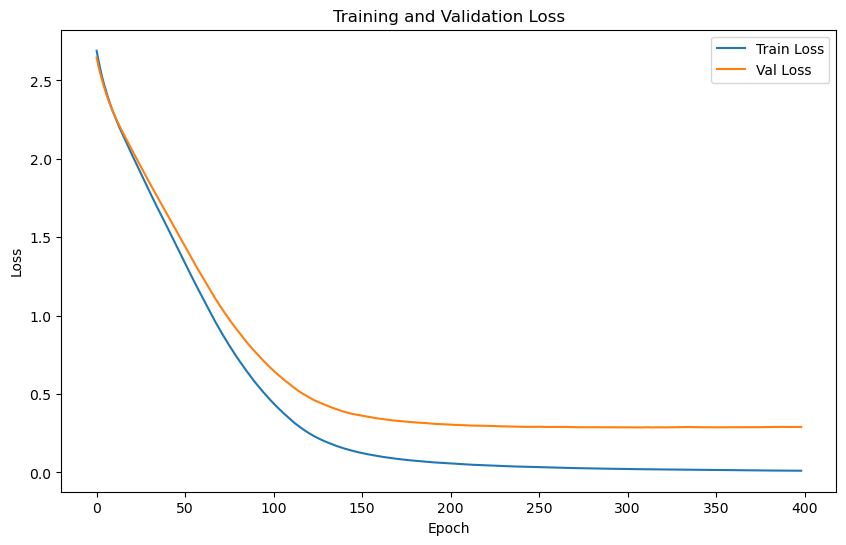

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3839 | Test Accuracy: 89.72%


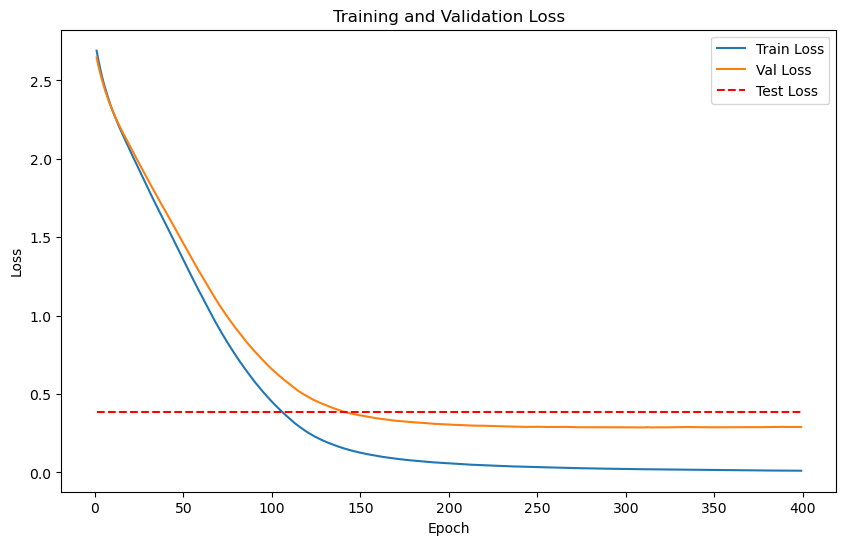

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


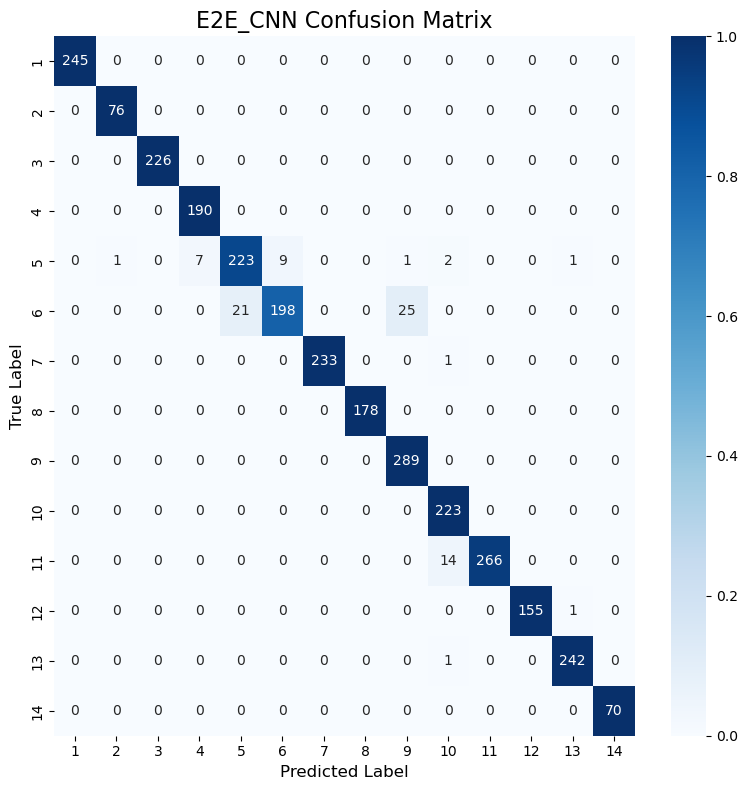

Classification Accuracy: 97.10%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


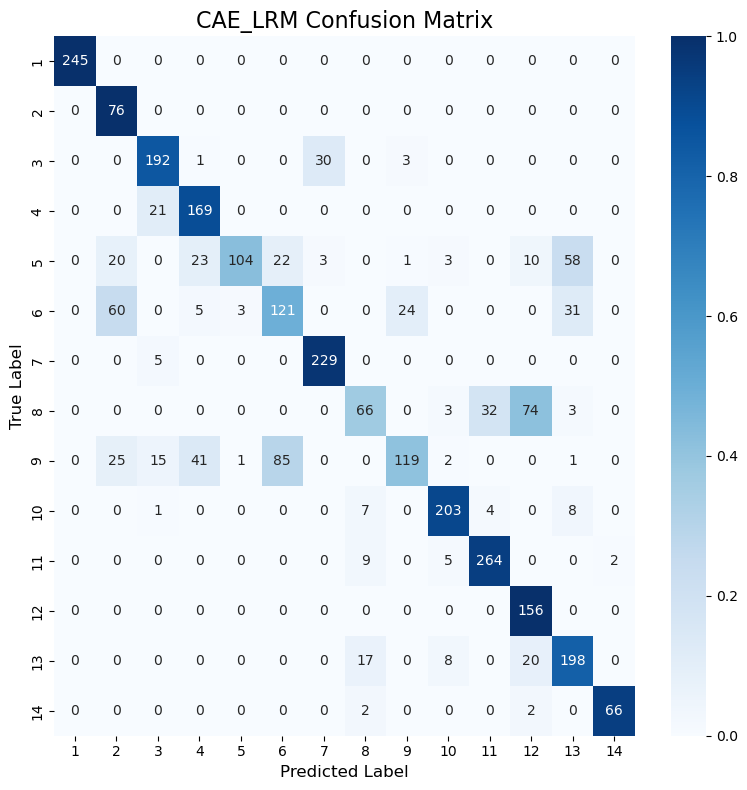

Classification Accuracy: 76.19%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


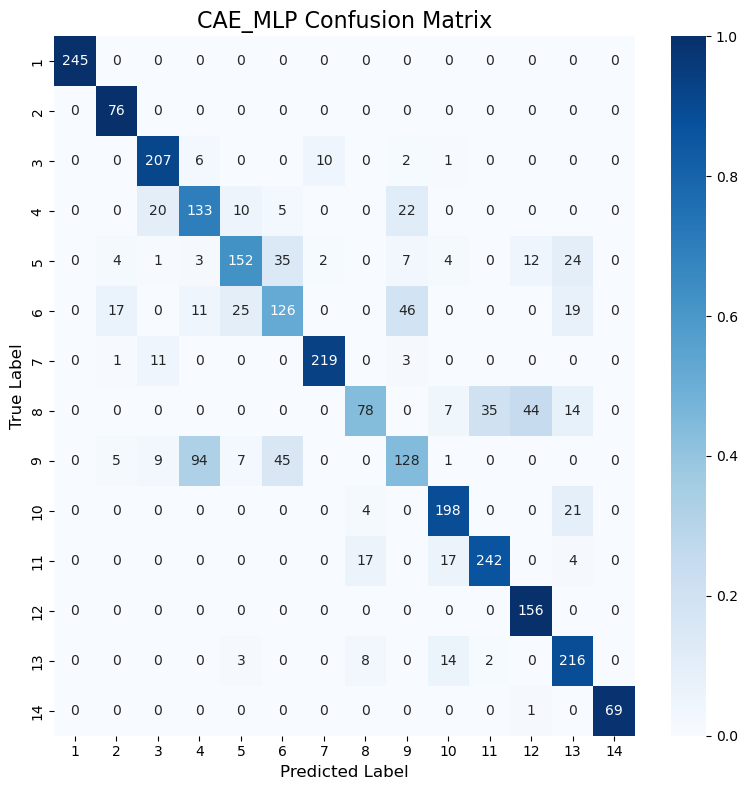

Classification Accuracy: 77.47%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


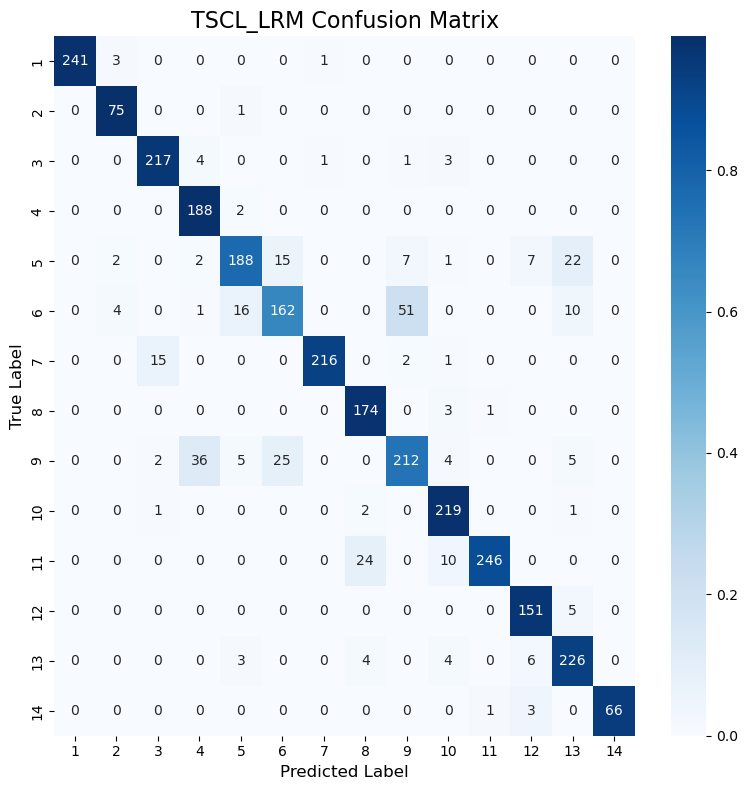

Classification Accuracy: 89.06%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


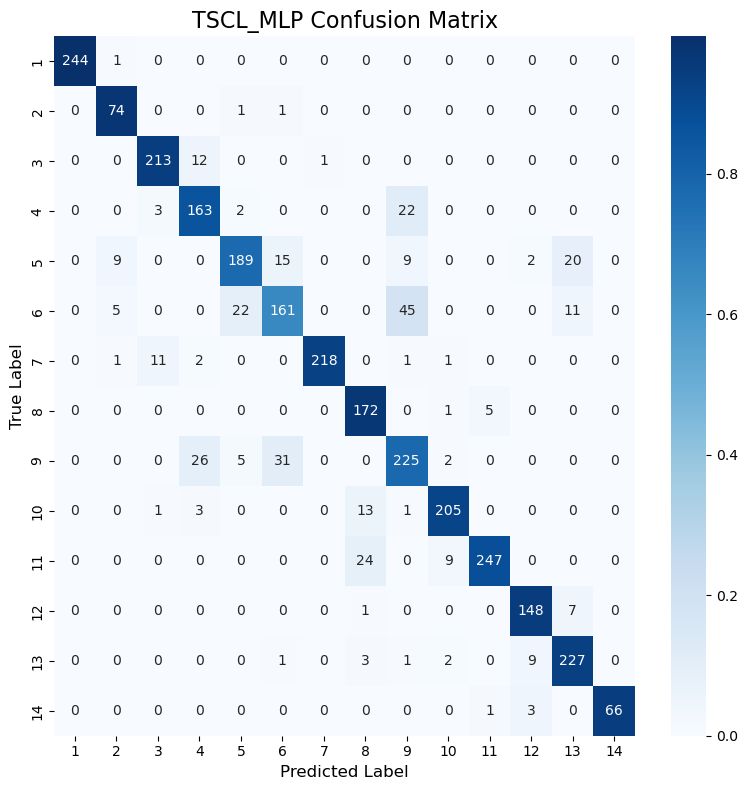

Classification Accuracy: 88.06%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


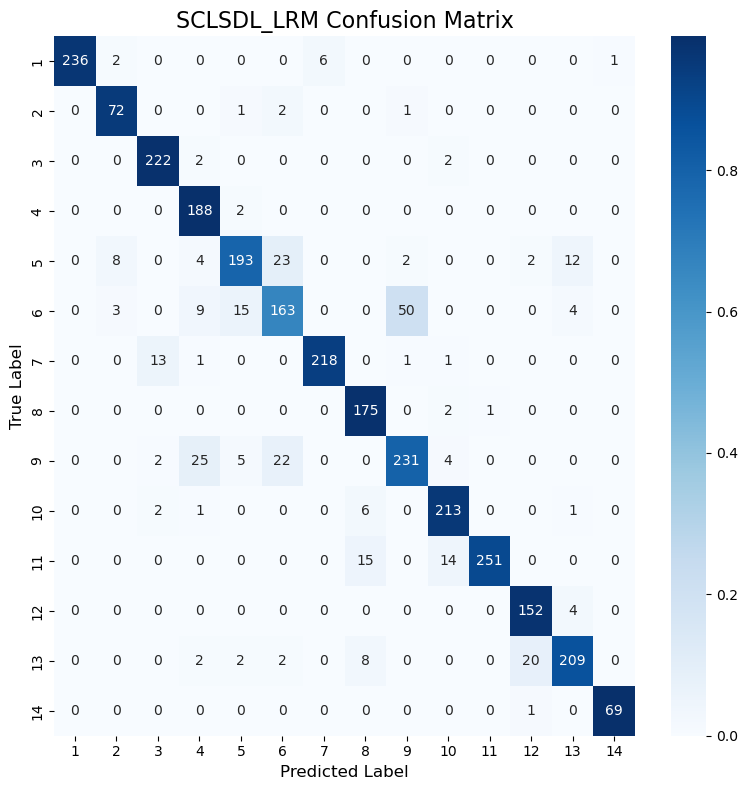

Classification Accuracy: 89.44%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


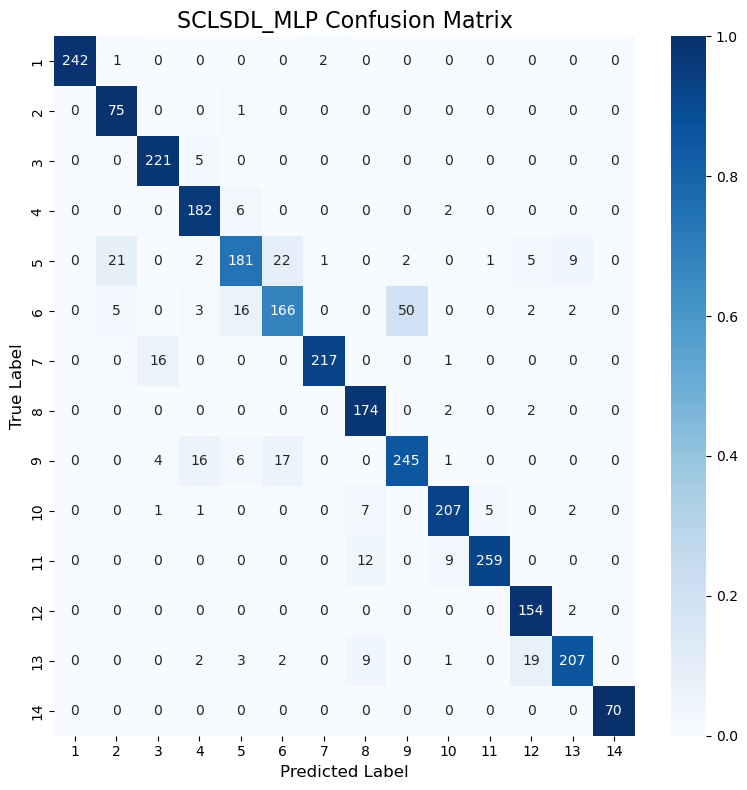

Classification Accuracy: 89.72%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.10
1    LRM (CAE)          76.19
2    MLP (CAE)          77.47
3     TSCL LRM          89.06
4     TSCL MLP          88.06
5  SCL_SDL LRM          89.44
6  SCL_SDL MLP          89.72

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.10
6  SCL_SDL MLP          89.72
5  SCL_SDL LRM          89.44
3     TSCL LRM          89.06
4     TSCL MLP          88.06
2    MLP (CAE)          77.47
1    LRM (CAE)          76.19
